[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/07-DCT/block_DCT_compression.ipynb)

# Block-DCT (Discrete Cosine Transform) Image Compression

Compressing color images with PNG in the YCoCg/DCT domain. No chroma subsampling. Remember to run [JPEG.ipynb](https://github.com/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/07-DCT/JPEG.ipynb) before!

## Parameters

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import os
import pylab
import cv2

!ln -sf ~/MRVC/src/image_3.py .
import image_3
!ln -sf ~/MRVC/src/image_1.py .
import image_1
!ln -sf ~/MRVC/src/block_DCT.py .
import block_DCT
!ln -sf ~/MRVC/src/YCoCg.py .
import YCoCg as YUV
#!ln -sf ~/MRVC/src/color_DCT.py .
#import color_DCT as YUV
#!ln -sf ~/MRVC/src/RGB.py .
#import RGB as YUV
!ln -sf ~/quantization/information.py .
import information
!ln -sf ~/quantization/distortion.py .
import distortion
!ln -sf ~/quantization/deadzone_quantizer.py .
import deadzone_quantizer as Q

In [110]:
HOME = os.environ["HOME"]
#test_image = "../sequences/stockholm/"
test_image = HOME + "/MRVC/images/lena_color/"
#test_image = "../images/lena_bw/"

In [3]:
block_y_side = block_x_side = 8 # Block-size used by JPEG
# block_y_side = block_x_side = 16

In [4]:
N_components = 3

In [5]:
entropy_estimator = "PNG"
# entropy_estimator = "entropy"
if entropy_estimator == "PNG":
    def compute_BPP(_image, filename_prefix):
        BPP = image_3.write(_image, filename_prefix, 0)*8/_image.size
        return BPP
else:
    def compute_BPP(_image, filename_prefix=''):
        entropy = information.entropy(_image.flatten().astype(np.int16))
        return entropy

## Testing `block_DCT.analyze_block()` and `block_DCT.synthesize_block()`

Let's see how the DCT concentrates the energy of the signal in a few coefficients. These methods compute the forward and the backward transforms of the input block (the input is not divided into blocks).

In [6]:
#a = np.random.randint(low=0, high=100, size=(4,4,3))
a = np.full(shape=(5, 4, 3), fill_value=10, dtype=np.int16) + np.random.randint(low=-5, high=5, size=(5, 4, 3))
# 5 is the number of rows
# 4 is the number of columns
# 3 is the number of (for example, RGB) channels

In [7]:
a

array([[[14, 11,  5],
        [ 5, 12, 13],
        [ 8,  5,  7],
        [ 5, 11,  8]],

       [[ 5,  6, 10],
        [ 5, 12,  7],
        [ 8,  5, 14],
        [10,  9,  5]],

       [[ 8, 10, 10],
        [ 9,  7,  5],
        [ 7,  9,  9],
        [ 9, 12, 13]],

       [[14, 10,  6],
        [14, 10, 13],
        [12, 11,  8],
        [ 6,  9,  8]],

       [[12, 10, 13],
        [14,  6,  6],
        [ 9, 14, 12],
        [12,  9,  7]]])

In [8]:
np.average(a)

9.216666666666667

component=0 max=1.0 min=0.0 dtype=float64
component=1 max=1.0 min=0.0 dtype=float64
component=2 max=1.0 min=0.0 dtype=float64


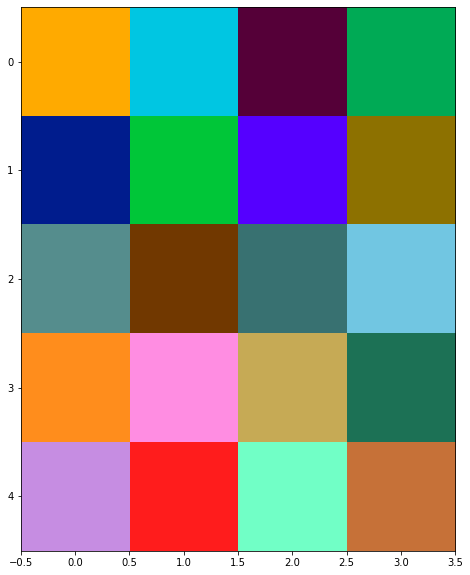

In [9]:
image_3.show(image_3.normalize(a))

In [10]:
b = block_DCT.analyze_block(a)

In [11]:
b

array([[[41.59086438, 42.03807798, 40.0256168 ],
        [ 3.57676535, -0.5134237 ,  0.15037832],
        [ 0.89442719,  1.34164079, -2.01246118],
        [ 0.45469731, -1.23951446,  2.11598354]],

       [[-7.85698947, -1.48699214, -1.31787837],
        [-1.42567582,  1.88185527, -1.09050386],
        [ 2.99074453,  1.80450287, -2.52088028],
        [ 4.51503508, -8.40223255, -2.56184476]],

       [[ 2.54407925,  0.90254629, -0.47434165],
        [ 3.02602066,  1.30247276,  2.64960773],
        [ 1.86548671, -0.48315303, -2.85486128],
        [ 1.28873054,  0.86049158, -1.13790442]],

       [[ 2.62539834,  2.40600382, -1.23012056],
        [ 7.30311821,  1.53573615, -1.77603967],
        [-1.47663373,  1.1152441 , -1.97361663],
        [ 2.99939513,  0.05121953, -9.67437005]],

       [[-0.7763123 ,  1.21877405,  0.47434165],
        [ 0.31964308, -1.25604547, -2.2669243 ],
        [ 2.02360059,  3.31158016,  5.6832884 ],
        [-1.52649954,  2.94711193,  0.21402489]]])

In [12]:
b.astype(np.int16)

array([[[41, 42, 40],
        [ 3,  0,  0],
        [ 0,  1, -2],
        [ 0, -1,  2]],

       [[-7, -1, -1],
        [-1,  1, -1],
        [ 2,  1, -2],
        [ 4, -8, -2]],

       [[ 2,  0,  0],
        [ 3,  1,  2],
        [ 1,  0, -2],
        [ 1,  0, -1]],

       [[ 2,  2, -1],
        [ 7,  1, -1],
        [-1,  1, -1],
        [ 2,  0, -9]],

       [[ 0,  1,  0],
        [ 0, -1, -2],
        [ 2,  3,  5],
        [-1,  2,  0]]], dtype=int16)

component=0 max=0.9913519159783083 min=0.03514396718968095 dtype=float64
component=1 max=1.0 min=0.02460021811917264 dtype=float64
component=2 max=0.9610836219023874 min=0.0 dtype=float64


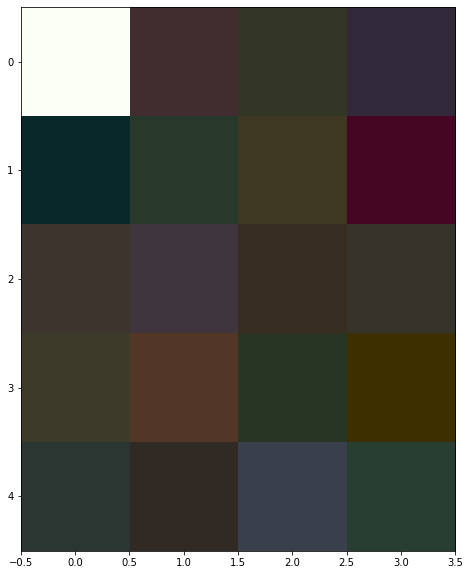

In [13]:
image_3.show(image_3.normalize(b))

In [14]:
c = block_DCT.synthesize_block(b)

In [15]:
c.astype(np.int16)

array([[[14, 11,  5],
        [ 5, 12, 13],
        [ 8,  5,  7],
        [ 5, 11,  8]],

       [[ 5,  6, 10],
        [ 5, 12,  7],
        [ 8,  5, 14],
        [10,  9,  4]],

       [[ 8, 10, 10],
        [ 9,  7,  5],
        [ 7,  9,  9],
        [ 9, 12, 13]],

       [[14, 10,  6],
        [14, 10, 13],
        [12, 11,  8],
        [ 6,  9,  8]],

       [[12, 10, 13],
        [14,  6,  6],
        [ 9, 14, 12],
        [12,  9,  7]]], dtype=int16)

component=0 max=1.0 min=1.9737298215558315e-16 dtype=float64
component=1 max=0.9999999999999992 min=2.960594732333747e-16 dtype=float64
component=2 max=0.9999999999999988 min=0.0 dtype=float64


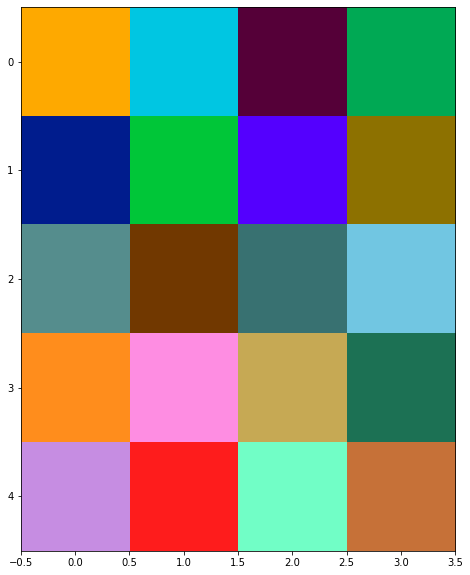

In [16]:
image_3.show(image_3.normalize(c))

In [17]:
(a == c.astype(np.int32)).all()

False

## Testing `block_DCT.analyze_image()` and `block_DCT.synthesize_image()`
Now we apply the block transform to an image that previously has been divided into blocks.

component=0 max=255 min=54 dtype=uint8
component=1 max=248 min=1 dtype=uint8
component=2 max=239 min=8 dtype=uint8


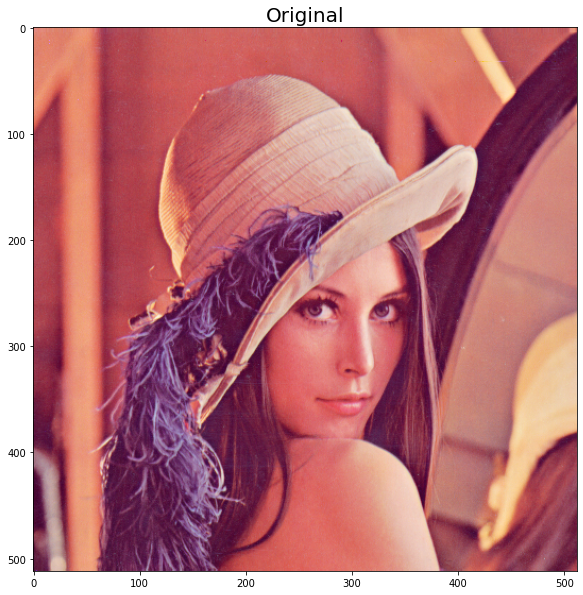

In [18]:
img = image_3.read(test_image, 0)
image_3.show(img, title="Original")

In [19]:
DCT_img = block_DCT.analyze_image(img, block_y_side, block_x_side)
#DCT_img = block_DCT.analyze_image(img, 2, 2)

component=0 max=1.0 min=0.02566908486187458 dtype=float32
component=1 max=0.8931590914726257 min=0.0 dtype=float32
component=2 max=0.8395910263061523 min=0.05100489780306816 dtype=float32


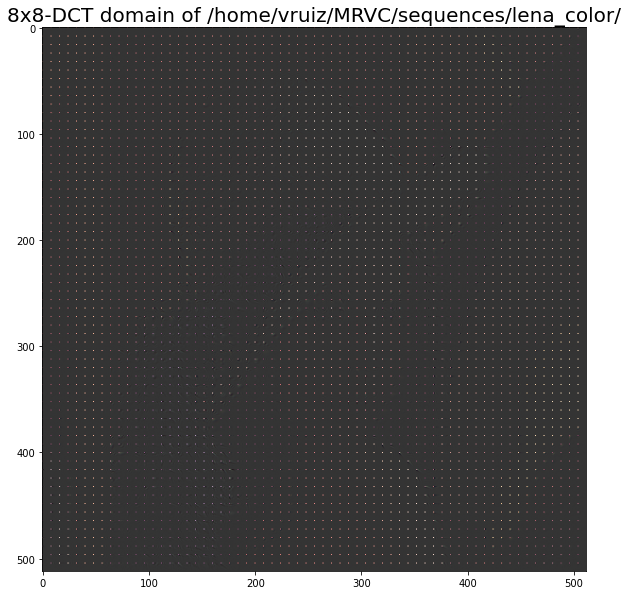

In [20]:
image_3.show(image_3.normalize(DCT_img), f"{block_y_side}x{block_x_side}-DCT domain of {test_image}")

component=0 max=1.0 min=0.0240169707685709 dtype=float32
component=1 max=0.6529723405838013 min=0.0 dtype=float32
component=2 max=0.5463293790817261 min=0.024998163804411888 dtype=float32


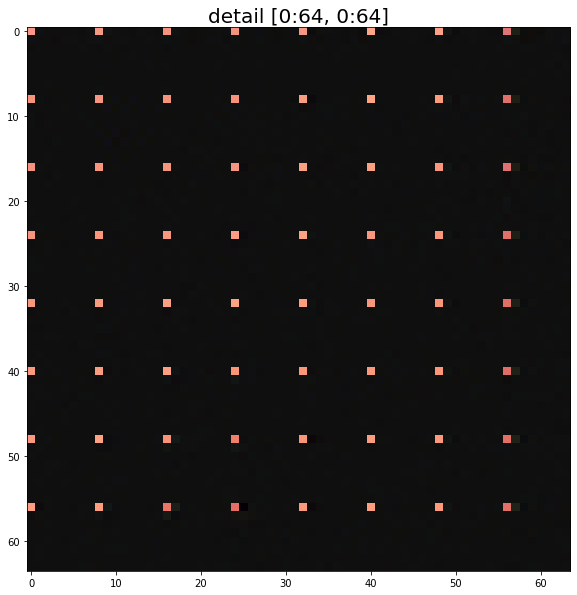

In [21]:
image_3.show(image_3.normalize(DCT_img[:64, :64]), "detail [0:64, 0:64]")

Again, as it can be seen, most of the energy of each block has been concentrated in the low-pass frequency component (DC component).

### Reconstruction and error

In [22]:
recons_img = block_DCT.synthesize_image(DCT_img, block_y_side, block_x_side)

component=0 max=255 min=54 dtype=uint8
component=1 max=247 min=0 dtype=uint8
component=2 max=239 min=7 dtype=uint8


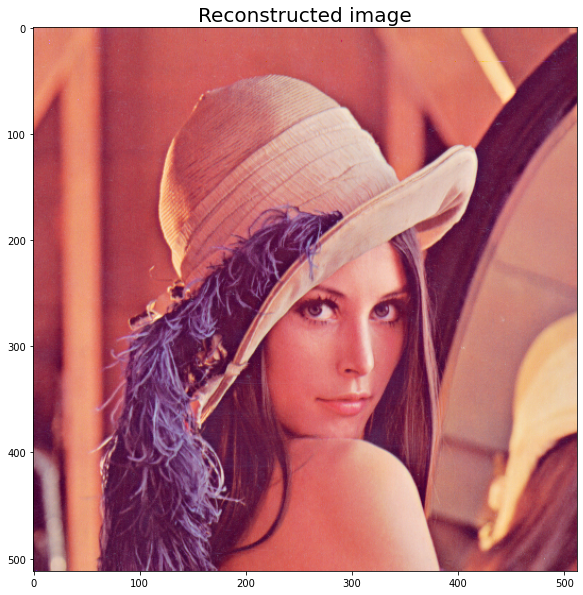

In [23]:
image_3.show(recons_img.astype(np.uint8), "Reconstructed image")

In [24]:
error = img - recons_img

component=0 max=1.0 min=0.0 dtype=float32
component=1 max=1.0 min=0.0 dtype=float32
component=2 max=1.0 min=0.0 dtype=float32


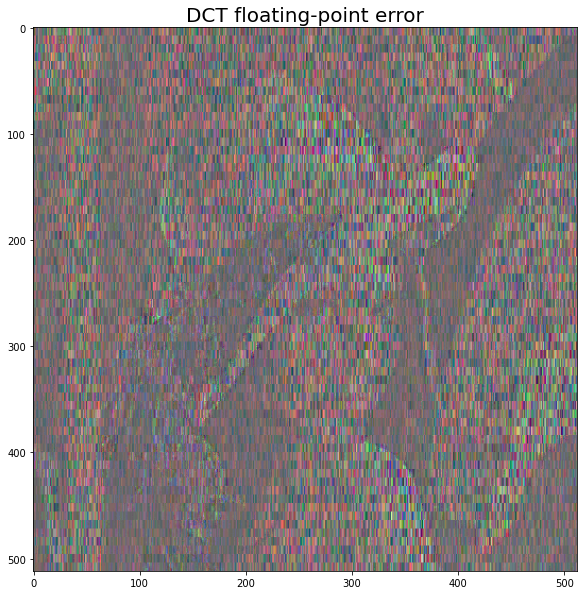

In [25]:
image_3.show(image_3.normalize(error), "DCT floating-point error")
#image_3.show(error, "DCT floating-point error")

This error es generated by the truncation of the floating point coefficients (remember that we work with 16 bits integers) after the analysis, and also by the truncation of the floating point pixels after the synthesis. 

## Switching between blocks and subbands

The coefficients of all DCT-blocks can be reorganized in subbands. A subband with coordinates (X, Y) is the 2D arragement of the coefficients that are in the coordinates (X, Y) of each block. The representation in subbands increases the spatial correlation between the coefficients (which also provides an improved visual comprehension of the content of the coefficients).

In [26]:
img = image_3.read(test_image)
DCT_blocks = block_DCT.analyze_image(img, block_y_side, block_x_side)
DCT_subbands = block_DCT.get_subbands(DCT_blocks, block_y_side, block_x_side)

component=0 max=1.0 min=0.02566908486187458 dtype=float32
component=1 max=0.8931590914726257 min=0.0 dtype=float32
component=2 max=0.8395910263061523 min=0.05100489780306816 dtype=float32


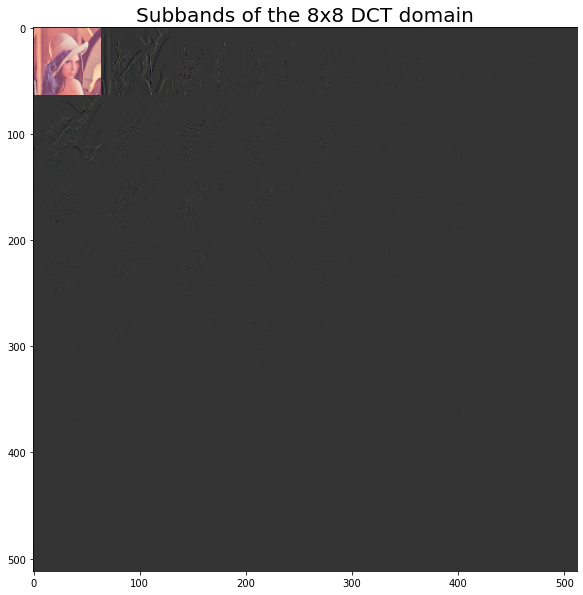

In [27]:
image_3.show(image_3.normalize(DCT_subbands), f"Subbands of the {block_y_side}x{block_x_side} DCT domain")

In [28]:
print(f"We have {block_y_side}x{block_x_side} subbands of {int(img.shape[0]/block_y_side)}x{int(img.shape[1]/block_x_side)} coefficients (each one)")

We have 8x8 subbands of 64x64 coefficients (each one)


The inverse process which reorder the coefficients into subbands is completely reversible (obviously).

In [29]:
_ = block_DCT.get_blocks(DCT_subbands, block_y_side, block_x_side)
(_ == DCT_blocks).all()

True

And, as it can be seen, the 2D correlation is higher in the low spatial frequencies (left up corner) than in the high frequencies (right down corner).

component=0 max=1.0 min=0.2699342966079712 dtype=float32
component=1 max=0.8601056337356567 min=0.0 dtype=float32
component=2 max=0.7899652123451233 min=0.17886126041412354 dtype=float32


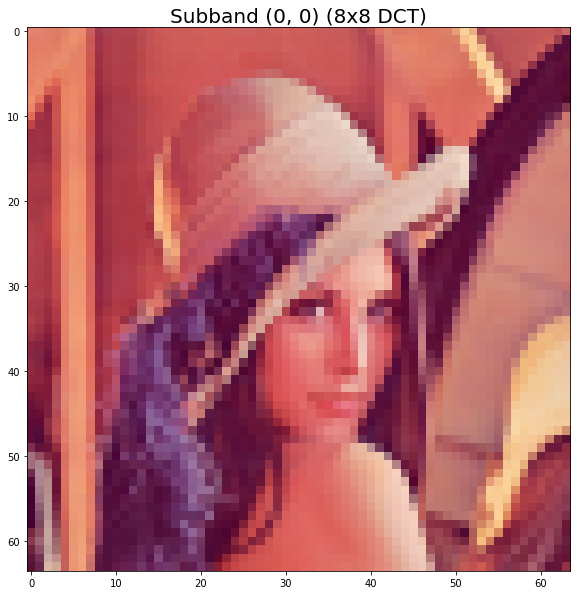

In [30]:
blocks_in_y = img.shape[0]//block_y_side
blocks_in_x = img.shape[1]//block_x_side
image_3.show(image_3.normalize(DCT_subbands[:blocks_in_y, :blocks_in_x]), f"Subband (0, 0) ({block_y_side}x{block_x_side} DCT)")

Subband (0,0) contains the low frequencies of the image.

component=0 max=0.9017226696014404 min=0.053422048687934875 dtype=float32
component=1 max=1.0 min=0.0 dtype=float32
component=2 max=0.788143515586853 min=0.1632125824689865 dtype=float32


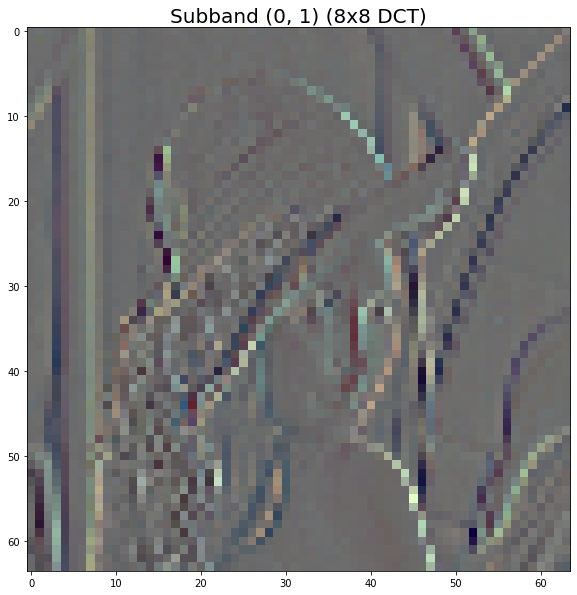

In [31]:
image_3.show(image_3.normalize(DCT_subbands[:blocks_in_y, blocks_in_x:2*blocks_in_x]), f"Subband (0, 1) ({block_y_side}x{block_x_side} DCT)")

The subband (0, 1) represents the slowest changes of the image in the horizontal direction.

component=0 max=0.9207989573478699 min=0.06307283043861389 dtype=float32
component=1 max=1.0 min=0.0 dtype=float32
component=2 max=0.8885713219642639 min=0.1059512123465538 dtype=float32


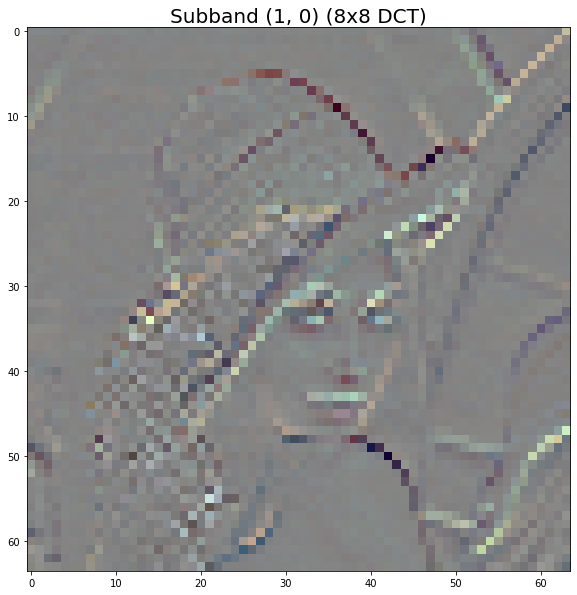

In [32]:
image_3.show(image_3.normalize(DCT_subbands[blocks_in_y:2*blocks_in_y, :blocks_in_x]), f"Subband (1, 0) ({block_y_side}x{block_x_side} DCT)")

The subband (1, 0) represents the slowest changes of the image in the vertical domain.

component=0 max=0.9280892014503479 min=0.10813528299331665 dtype=float32
component=1 max=1.0 min=0.0 dtype=float32
component=2 max=0.8496631383895874 min=0.16063201427459717 dtype=float32


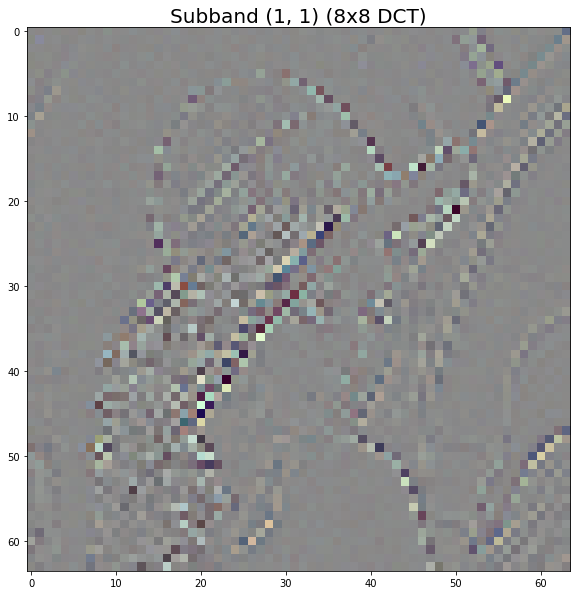

In [33]:
image_3.show(image_3.normalize(DCT_subbands[blocks_in_y:2*blocks_in_y, blocks_in_x:2*blocks_in_x]), f"Subband (1, 1) ({block_y_side}x{block_x_side} DCT)")

The subband (1, 1) represents slowest changes in the diagonal (left up corner to right down corner) of the image.

## Subband-components information

In [34]:
img = image_3.read(test_image, 0)
#YUV_img = YUV.from_RGB(img.astype(np.int16) - 128) # -128 decreases maximum value of the DC coefficients
###############################################################
# This reduces the energy (not the entropy) of the            #
# coefficients compared to the previous option.               #
# However, the averages should be encoded to                  #
# reconstruct the image.                                      #
YUV_img = YUV.from_RGB(img.astype(np.int16))                  #
YUV_img[...,0] -= np.average(YUV_img[...,0]).astype(np.int16) #
YUV_img[...,1] -= np.average(YUV_img[...,1]).astype(np.int16) #
YUV_img[...,2] -= np.average(YUV_img[...,2]).astype(np.int16) #
###############################################################
DCT_blocks = block_DCT.analyze_image(YUV_img, block_y_side, block_x_side)
DCT_subbands = block_DCT.get_subbands(DCT_blocks, block_y_side, block_x_side)
print("sorting subband-components by entropy")
print("subband component maximum mininum max-min average std-dev entropy        energy  avg-enegy")
accumulated_entropy = 0
blocks_in_y = img.shape[0]//block_y_side
blocks_in_x = img.shape[1]//block_x_side
list_of_subbands_components = []
for _y in range(block_y_side):
    for _x in range(block_x_side):
        for _c in range(N_components):
            subband = DCT_subbands[blocks_in_y*_y:blocks_in_y*(_y+1), blocks_in_x*_x:blocks_in_x*(_x+1), _c]
            entropy = information.entropy(subband.flatten().astype(np.int16))
            accumulated_entropy += entropy
            max = subband.max()
            min = subband.min()
            max_min = max - min
            avg = np.average(subband)
            dev = math.sqrt(np.var(subband))
            energy = information.energy(subband)
            avg_energy = energy/subband.size
            list_of_subbands_components.append((_y, _x, _c, max, min, max_min, avg, dev, entropy, energy, avg_energy))
            #print(f"{_y:2d} {_x:2d} {_c:9d} {max:7.1f} {min:7.1f} {max_min:7.1f} {avg:7.1f} {dev:7.1f} {entropy:7.1f} {energy:13.1f} {avg_energy:10.1f}")
sorted_list_of_subbands_components = sorted(list_of_subbands_components, key=lambda x: x[8])[::-1]
for _i in sorted_list_of_subbands_components:
    _y, _x, _c, max, min, max_min, avg, dev, entropy, energy, avg_energy = _i
    print(f"  {_y:2d} {_x:2d} {_c:9d} {max:7.1f} {min:7.1f} {max_min:7.1f} {avg:7.1f} {dev:7.1f} {entropy:7.1f} {energy:13.1f} {avg_energy:10.1f}")
avg_entropy = accumulated_entropy/(block_x_side*block_y_side*img.shape[2])
print("Average entropy in the DCT domain:", avg_entropy)
print("Entropy in the image domain:", information.entropy(img.flatten().astype(np.uint8)))

sorting subband-components by entropy
subband component maximum mininum max-min average std-dev entropy        energy  avg-enegy
   0  0         0   792.0  -662.1  1454.1     4.5   337.7    10.0   467295835.6   114085.9
   0  0         1   224.0  -360.1   584.1     1.3   137.3     8.9    77230906.4    18855.2
   0  1         0   607.3  -427.0  1034.3    -1.7    81.8     7.6    27412211.4     6692.4
   0  0         2   202.2  -137.6   339.9    -4.2    67.1     7.6    18505612.5     4518.0
   1  0         0   384.4  -426.9   811.3     0.9    51.3     6.8    10794307.5     2635.3
   0  2         0   275.6  -263.4   539.0     1.1    38.2     6.3     5995852.1     1463.8
   1  1         0   231.8  -271.7   503.6    -0.1    35.6     6.2     5193771.9     1268.0
   0  1         1   143.2  -198.4   341.6     0.0    24.0     6.1     2356139.7      575.2
   1  2         0   171.4  -221.4   392.7    -0.8    24.1     5.6     2378302.1      580.6
   0  3         0   167.7  -274.6   442.3    -0.1   

As it can be observed, the 8x8-DCT accumulates most of the energy (and information, for this reason the entropy is decreased) in the low-frequency subbands. Notice also the high correlation that exists between the entropy, the variance and the energy of the subbands.

## Lossless compression

** Processing: /tmp/lossless000.png
512x512 pixels, 3x16 bits/pixel, RGB
Input IDAT size = 671915 bytes
Input file size = 672956 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 542009
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 542009

Output IDAT size = 542009 bytes (129906 bytes decrease)
Output file size = 542066 bytes (130890 bytes = 19.45% decrease)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


output_length=542066
component=0 max=257 min=54 dtype=int16
component=1 max=247 min=-1 dtype=int16
component=2 max=237 min=7 dtype=int16


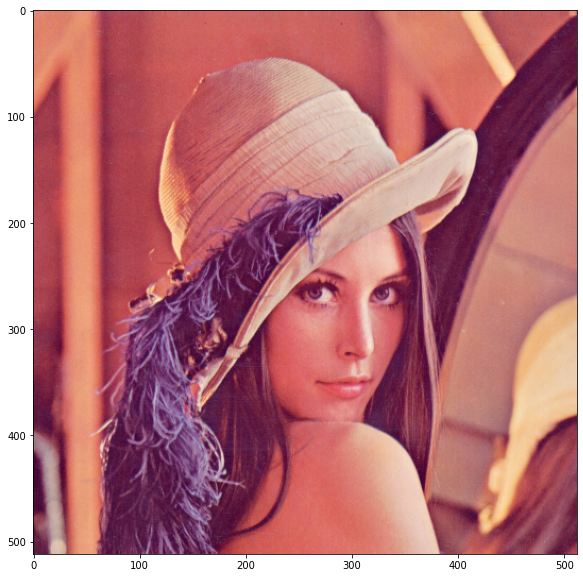

In [35]:
img = image_3.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16) - 128) # -128 decreases maximum value of the DC coefficients
DCT_blocks = block_DCT.analyze_image(YUV_img, block_y_side, block_x_side)
DCT_subbands = block_DCT.get_subbands(DCT_blocks, block_y_side, block_x_side)

img = image_3.read(test_image, 0)
YUV_img = YUV.from_RGB(img.astype(np.int16) - 128)
DCT_blocks = block_DCT.analyze_image(YUV_img, block_y_side, block_x_side)
DCT_subbands = block_DCT.get_subbands(DCT_blocks, block_y_side, block_x_side)
DCT_subbands = (DCT_subbands + 32768).astype(np.uint16)
output_len = image_3.write(DCT_subbands, "/tmp/lossless", 0)
print(f"output_length={output_len}")
_DCT_subbands = image_3.read("/tmp/lossless", 0)
_DCT_subbands = _DCT_subbands.astype(np.float32) - 32768
_DCT_blocks = block_DCT.get_blocks(_DCT_subbands, block_y_side, block_x_side)
_YUV_img = block_DCT.synthesize_image(_DCT_blocks, block_y_side, block_x_side)
_img = YUV.to_RGB(_YUV_img.astype(np.int16)) + 128
image_3.show(_img)

## Lossy compression

### Quantization steps

Considering the previous dynamic range values for the YCoCg/8x8-DCT coefficients, this parameter should allow to use 8 bits/pixel images, if we are using PNG as an entropy codec. As it can be seen, we need 11 bits for representing the DC coefficients and after quantization, we should use only 8. Therefore, the minimum quantization step should be 1<<3 = 8. Notice that 11 - 8 = 3.

In [115]:
#Q_steps = [128, 64, 32, 16, 8] #, 4, 2, 1]
#Q_steps = [(2**i)//16 for i in range(16, -1, -1)]
Q_steps = [i for i in range(128, 8, -4)]
#Q_steps = [128, 96, 64, 32, 16, 8] #, 4, 2, 1]

In [116]:
Q_steps

[128,
 124,
 120,
 116,
 112,
 108,
 104,
 100,
 96,
 92,
 88,
 84,
 80,
 76,
 72,
 68,
 64,
 60,
 56,
 52,
 48,
 44,
 40,
 36,
 32,
 28,
 24,
 20,
 16,
 12]

## Testing `block_DCT.uniform_quantize()` and `block_DCT.uniform_dequantize()` (MOVER A test_block_DCT)
Quantization removes information but also increases the compression ratios of the stored images. These methods quantize all coefficients with the same quantization step.

component=0 max=255 min=38 dtype=int16
component=1 max=245 min=0 dtype=int16
component=2 max=236 min=11 dtype=int16


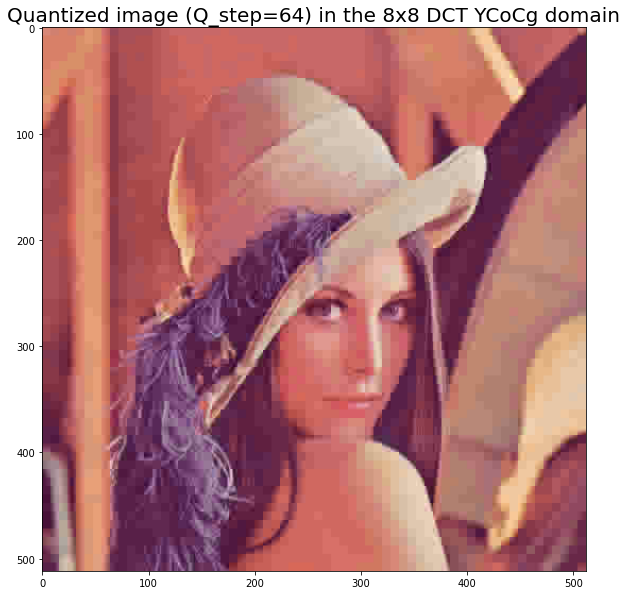

In [117]:
Q_step = 64
img = image_3.read(test_image, 0)
YUV_img = YUV.from_RGB(img.astype(np.int16) - 128)
DCT_blocks = block_DCT.analyze_image(YUV_img, block_y_side, block_x_side)
DCT_subbands = block_DCT.get_subbands(DCT_blocks, block_y_side, block_x_side)
DCT_subbands_k = block_DCT.uniform_quantize(DCT_subbands, block_y_side, block_x_side, N_components, Q_step)
DCT_subbands_dQ = block_DCT.uniform_dequantize(DCT_subbands_k, block_y_side, block_x_side, N_components, Q_step)
DCT_blocks_dQ = block_DCT.get_blocks(DCT_subbands_dQ, block_y_side, block_x_side)
YUV_img_dQ = block_DCT.synthesize_image(DCT_blocks_dQ, block_y_side, block_x_side)
img_dQ = YUV.to_RGB(YUV_img_dQ) + 128
image_3.show(np.clip(img_dQ, a_min=0, a_max=255), f"Quantized image (Q_step={Q_step}) in the {block_y_side}x{block_x_side} DCT {YUV.name} domain")

component=0 max=0.8901515151515151 min=0.14772727272727273 dtype=float64
component=1 max=0.9621212121212122 min=0.0 dtype=float64
component=2 max=1.0 min=0.08712121212121213 dtype=float64


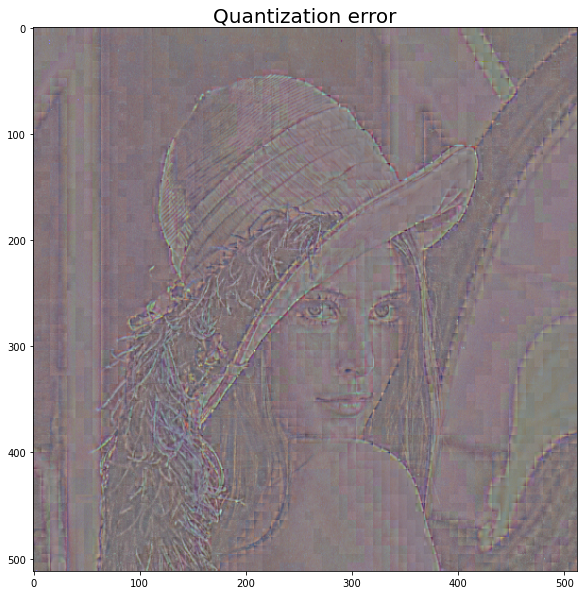

In [118]:
error = img - img_dQ
image_3.show(image_3.normalize(error), "Quantization error")

Therefore, quantization in the DCT domain tends to remove high frequencies (it works basically as a low pass filter).

## Coding subbands vs coding blocks
Let's see the effect of encoding the DCT coefficients grouped by blocks and subbands. For simplicity, we will use uniform quantization. Distortion is measured in the image domain.

In [119]:
#img = image_3.read(test_image, 0)
#YUV_img = YUV.from_RGB(img.astype(np.int16) - 128)
img = image_3.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16))
avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
RD_points_blocks = []
RD_points_subbands = []
for Q_step in Q_steps:
    DCT_blocks = block_DCT.analyze_image(YUV_img, block_y_side, block_x_side)
    # Notice that with uniform_quantize() does not matter if the DCT domain
    # is organized in subbands or blocks.
    DCT_blocks_k = block_DCT.uniform_quantize(DCT_blocks, block_y_side, block_x_side, N_components, Q_step)
    BPP = image_3.write((DCT_blocks_k + 128).astype(np.uint8), f"/tmp/{Q_step}_", 0)*8/YUV_img.size
    # Check that we can recover the code-stream ################
    __ = image_3.read(f"/tmp/{Q_step}_", 0)                    #
    try:                                                       #
        assert ((DCT_blocks_k + 128) == __).all()              #
    except AssertionError:                                     #
        counter = 0                                            #
        for _i in range(img.shape[0]):                         #
            for _j in range(img.shape[1]):                     #
                if (DCT_blocks_k[_i, _j] != __[_i, _j]).any(): #
                    print(DCT_blocks_k[_i, _j], __[_i, _j])    #
                    if counter > 10:                           #
                        break                                  #
                    counter += 1                               #
            if counter > 10:                                   #
                break                                          #
    ############################################################
    DCT_blocks_dQ = block_DCT.uniform_dequantize(DCT_blocks_k, block_y_side, block_x_side, N_components, Q_step)
    YUV_img_dQ = block_DCT.synthesize_image(DCT_blocks_dQ, block_y_side, block_x_side)
    #img_dQ = YUV.to_RGB(YUV_img_dQ) + 128
    for c in range(3):
        YUV_img_dQ[..., c] += int(avgs[c])
    img_dQ = YUV.to_RGB(YUV_img_dQ)

    # Notice that to compute the distortion, the DCT domain could be
    # also used because the DCT is unitary.
    RMSE = distortion.RMSE(img, img_dQ)
    RD_points_blocks.append((BPP, RMSE))
    DCT_subbands_k = block_DCT.get_subbands(DCT_blocks_k, block_y_side, block_x_side)
    BPP = compute_BPP((DCT_subbands_k + 128).astype(np.uint8), f"/tmp/{Q_step}_")
    # Check that we can recover the code-stream #################
    __ = image_3.read(f"/tmp/{Q_step}_", 0)                     #
    try:                                                        #
        assert ((DCT_subbands_k + 128) == __).all()             #
    except AssertionError:                                      #
        counter = 0                                             #
        for _i in range(img.shape[0]):                          #
            for _j in range(img.shape[1]):                      #
                if (DCT_subbands_k[_i, _j] != __[_i, _j]).any():#
                    print(DCT_subbands_k[_i, _j], __[_i, _j])   #
                    if counter > 10:                            #
                        break                                   #
                    counter += 1                                #
            if counter > 10:                                    # 
                break                                           #
    #############################################################
    RD_points_subbands.append((BPP, RMSE))
    print(f"Q_step={Q_step} BPP={BPP} image-domain-RMSE={RMSE}")


avgs=[120.56250381469727, 37.16556930541992, -21.529052734375]


** Processing: /tmp/128_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 11084 bytes
Input file size = 11153 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5265
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 5264
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 5264

Output IDAT size = 5264 bytes (5820 bytes decrease)
Output file size = 5456 bytes (5697 bytes = 51.08% decrease)

** Processing: /tmp/128_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



Q_step=128 BPP=0.046101888020833336 image-domain-RMSE=17.40203020960063


** Processing: /tmp/124_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 43 colors in palette
Input IDAT size = 11250 bytes
Input file size = 11319 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5351
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 5350
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 5350

Output IDAT size = 5350 bytes (5900 bytes decrease)
Output file size = 5548 bytes (5771 bytes = 50.99% decrease)

** Processing: /tmp/124_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 43 colors in palette
Input IDAT size = 6312 bytes
Input file size = 6369 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4423
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4423

Output IDAT size = 4423 bytes (1889 bytes decrease)
Output file size = 4621 bytes (1748 bytes = 27.45% decrease)



Q_step=124 BPP=0.047007242838541664 image-domain-RMSE=17.24332206575763


** Processing: /tmp/120_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 44 colors in palette
Input IDAT size = 11501 bytes
Input file size = 11570 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5470
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 5470
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 5470

Output IDAT size = 5470 bytes (6031 bytes decrease)
Output file size = 5671 bytes (5899 bytes = 50.99% decrease)

** Processing: /tmp/120_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 44 colors in palette
Input IDAT size = 6520 bytes
Input file size = 6577 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4541
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4541

Output IDAT size = 4541 bytes (1979 bytes decrease)
Output file size = 4742 bytes (1835 bytes = 27.90% decrease)



Q_step=120 BPP=0.048238118489583336 image-domain-RMSE=16.85507344312424


** Processing: /tmp/116_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 48 colors in palette
Input IDAT size = 11832 bytes
Input file size = 11901 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5602
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 5601
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 5601

Output IDAT size = 5601 bytes (6231 bytes decrease)
Output file size = 5814 bytes (6087 bytes = 51.15% decrease)

** Processing: /tmp/116_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 48 colors in palette
Input IDAT size = 6700 bytes
Input file size = 6757 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4647
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4647

Output IDAT size = 4647 bytes (2053 bytes decrease)
Output file size = 4860 bytes (1897 bytes = 28.07% decrease)



Q_step=116 BPP=0.0494384765625 image-domain-RMSE=16.73969361657223


** Processing: /tmp/112_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 52 colors in palette
Input IDAT size = 12282 bytes
Input file size = 12351 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5814
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 5812
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 5812

Output IDAT size = 5812 bytes (6470 bytes decrease)
Output file size = 6037 bytes (6314 bytes = 51.12% decrease)

** Processing: /tmp/112_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 52 colors in palette
Input IDAT size = 6992 bytes
Input file size = 7049 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4828
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4828

Output IDAT size = 4828 bytes (2164 bytes decrease)
Output file size = 5053 bytes (1996 bytes = 28.32% decrease)



Q_step=112 BPP=0.051401774088541664 image-domain-RMSE=16.29075032004328


** Processing: /tmp/108_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 59 colors in palette
Input IDAT size = 12847 bytes
Input file size = 12916 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6093
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 6091
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 6091

Output IDAT size = 6091 bytes (6756 bytes decrease)
Output file size = 6337 bytes (6579 bytes = 50.94% decrease)

** Processing: /tmp/108_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 59 colors in palette
Input IDAT size = 7276 bytes
Input file size = 7333 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5052
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5052

Output IDAT size = 5052 bytes (2224 bytes decrease)
Output file size = 5298 bytes (2035 bytes = 27.75% decrease)



Q_step=108 BPP=0.05389404296875 image-domain-RMSE=16.11579127388358


** Processing: /tmp/104_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 63 colors in palette
Input IDAT size = 13165 bytes
Input file size = 13234 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6231
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 6231
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 6231

Output IDAT size = 6231 bytes (6934 bytes decrease)
Output file size = 6489 bytes (6745 bytes = 50.97% decrease)

** Processing: /tmp/104_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 63 colors in palette
Input IDAT size = 7519 bytes
Input file size = 7576 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5189
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5189

Output IDAT size = 5189 bytes (2330 bytes decrease)
Output file size = 5447 bytes (2129 bytes = 28.10% decrease)



Q_step=104 BPP=0.055409749348958336 image-domain-RMSE=15.694843979572767


** Processing: /tmp/100_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 70 colors in palette
Input IDAT size = 13719 bytes
Input file size = 13788 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6484
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6484

Output IDAT size = 6484 bytes (7235 bytes decrease)
Output file size = 6763 bytes (7025 bytes = 50.95% decrease)

** Processing: /tmp/100_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 70 colors in palette
Input IDAT size = 7851 bytes
Input file size = 7908 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5408
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5408

Output IDAT size = 5408 bytes (2443 bytes decrease)
Output file size = 5687 bytes (2221 bytes = 28.09% decrease)



Q_step=100 BPP=0.057851155598958336 image-domain-RMSE=15.583255801628479


** Processing: /tmp/96_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 73 colors in palette
Input IDAT size = 14308 bytes
Input file size = 14377 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6755
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6755

Output IDAT size = 6755 bytes (7553 bytes decrease)
Output file size = 7043 bytes (7334 bytes = 51.01% decrease)

** Processing: /tmp/96_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 73 colors in palette
Input IDAT size = 8182 bytes
Input file size = 8239 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5610
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5610

Output IDAT size = 5610 bytes (2572 bytes decrease)
Output file size = 5898 bytes (2341 bytes = 28.41% decrease)



Q_step=96 BPP=0.05999755859375 image-domain-RMSE=15.163075717144508


** Processing: /tmp/92_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 87 colors in palette
Input IDAT size = 14918 bytes
Input file size = 14987 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 7124
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 7124
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 7124

Output IDAT size = 7124 bytes (7794 bytes decrease)
Output file size = 7454 bytes (7533 bytes = 50.26% decrease)

** Processing: /tmp/92_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 87 colors in palette
Input IDAT size = 8567 bytes
Input file size = 8636 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5891
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5891

Output IDAT size = 5891 bytes (2676 bytes decrease)
Output file size = 6221 bytes (2415 bytes = 27.96% decrease)



Q_step=92 BPP=0.06328328450520833 image-domain-RMSE=14.973876839678603


** Processing: /tmp/88_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 97 colors in palette
Input IDAT size = 15738 bytes
Input file size = 15807 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 7435
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 7433
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 7433

Output IDAT size = 7433 bytes (8305 bytes decrease)
Output file size = 7793 bytes (8014 bytes = 50.70% decrease)

** Processing: /tmp/88_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 97 colors in palette
Input IDAT size = 9042 bytes
Input file size = 9111 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6195
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6195

Output IDAT size = 6195 bytes (2847 bytes decrease)
Output file size = 6555 bytes (2556 bytes = 28.05% decrease)



Q_step=88 BPP=0.066680908203125 image-domain-RMSE=14.476613444886974


** Processing: /tmp/84_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 111 colors in palette
Input IDAT size = 16384 bytes
Input file size = 16453 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 7735
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 7734
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 7734

Output IDAT size = 7734 bytes (8650 bytes decrease)
Output file size = 8136 bytes (8317 bytes = 50.55% decrease)

** Processing: /tmp/84_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 111 colors in palette
Input IDAT size = 9455 bytes
Input file size = 9524 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6449
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6449

Output IDAT size = 6449 bytes (3006 bytes decrease)
Output file size = 6851 bytes (2673 bytes = 28.07% decrease)



Q_step=84 BPP=0.06969197591145833 image-domain-RMSE=14.246271995417446


** Processing: /tmp/80_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 126 colors in palette
Input IDAT size = 17072 bytes
Input file size = 17153 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 8156
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 8155
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 8155

Output IDAT size = 8155 bytes (8917 bytes decrease)
Output file size = 8602 bytes (8551 bytes = 49.85% decrease)

** Processing: /tmp/80_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 126 colors in palette
Input IDAT size = 9964 bytes
Input file size = 10033 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6776
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 6776

Output IDAT size = 6776 bytes (3188 bytes decrease)
Output file size = 7223 bytes (2810 bytes = 28.01% decrease)



Q_step=80 BPP=0.07347615559895833 image-domain-RMSE=13.787801671582596


** Processing: /tmp/76_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 143 colors in palette
Input IDAT size = 17757 bytes
Input file size = 17838 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 8446
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 8444
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 8444

Output IDAT size = 8444 bytes (9313 bytes decrease)
Output file size = 8942 bytes (8896 bytes = 49.87% decrease)

** Processing: /tmp/76_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 143 colors in palette
Input IDAT size = 10444 bytes
Input file size = 10513 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 7078
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 7078

Output IDAT size = 7078 bytes (3366 bytes decrease)
Output file size = 7576 bytes (2937 bytes = 27.94% decrease)

** Processing: /tmp/72_000.png
5

Q_step=76 BPP=0.07706705729166667 image-domain-RMSE=13.48095390974431


                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 9046

Output IDAT size = 9046 bytes (9755 bytes decrease)
Output file size = 9598 bytes (9284 bytes = 49.17% decrease)

** Processing: /tmp/72_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 161 colors in palette
Input IDAT size = 11253 bytes
Input file size = 11322 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 7633
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 7633

Output IDAT size = 7633 bytes (3620 bytes decrease)
Output file size = 8185 bytes (3137 bytes = 27.71% decrease)



Q_step=72 BPP=0.08326212565104167 image-domain-RMSE=12.976886057011276


** Processing: /tmp/68_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 180 colors in palette
Input IDAT size = 19200 bytes
Input file size = 19281 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 9556
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 9555
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 9555

Output IDAT size = 9555 bytes (9645 bytes decrease)
Output file size = 10164 bytes (9117 bytes = 47.28% decrease)

** Processing: /tmp/68_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 180 colors in palette
Input IDAT size = 11804 bytes
Input file size = 11873 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 8072
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 8072

Output IDAT size = 8072 bytes (3732 bytes decrease)
Output file size = 8681 bytes (3192 bytes = 26.88% decrease)

** Processing: /tmp/64_000.png


Q_step=68 BPP=0.08830769856770833 image-domain-RMSE=12.667485528544542


		IDAT size = 10207
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 10207

Output IDAT size = 10207 bytes (8667 bytes decrease)
Output file size = 10945 bytes (8010 bytes = 42.26% decrease)

** Processing: /tmp/64_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 223 colors in palette
Input IDAT size = 12529 bytes
Input file size = 12598 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 8554
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 8554

Output IDAT size = 8554 bytes (3975 bytes decrease)
Output file size = 9292 bytes (3306 bytes = 26.24% decrease)



Q_step=64 BPP=0.09452311197916667 image-domain-RMSE=12.10800390213264


** Processing: /tmp/60_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 252 colors in palette
Input IDAT size = 18358 bytes
Input file size = 18439 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 10801
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 10801

Output IDAT size = 10801 bytes (7557 bytes decrease)
Output file size = 11626 bytes (6813 bytes = 36.95% decrease)

** Processing: /tmp/60_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 252 colors in palette
Input IDAT size = 13240 bytes
Input file size = 13309 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 9132
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 9132

Output IDAT size = 9132 bytes (4108 bytes decrease)
Output file size = 9957 bytes (3352 bytes = 25.19% decrease)



Q_step=60 BPP=0.101287841796875 image-domain-RMSE=11.774780979805774


** Processing: /tmp/56_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 18752 bytes
Input file size = 18833 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 14537
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 14389
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 14389

Output IDAT size = 14389 bytes (4363 bytes decrease)
Output file size = 14446 bytes (4387 bytes = 23.29% decrease)

** Processing: /tmp/56_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14136 bytes
Input file size = 14205 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 12723
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 12586
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 12586

Output IDAT size = 12586 bytes (1550 bytes decrease)
Output file size = 12643 bytes (1562 bytes = 11.00% decrease)



Q_step=56 BPP=0.12861124674479166 image-domain-RMSE=11.219146409819139


** Processing: /tmp/52_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 19738 bytes
Input file size = 19819 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15610
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15441
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15441

Output IDAT size = 15441 bytes (4297 bytes decrease)
Output file size = 15498 bytes (4321 bytes = 21.80% decrease)

** Processing: /tmp/52_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 15162 bytes
Input file size = 15231 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13693
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13563
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13563

Output IDAT size = 13563 bytes (1599 bytes decrease)
Output file size = 13620 bytes (1611 bytes = 10.58% decrease)



Q_step=52 BPP=0.1385498046875 image-domain-RMSE=10.85715894889117


** Processing: /tmp/48_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 20909 bytes
Input file size = 20990 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 16682
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 16471
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 16471

Output IDAT size = 16471 bytes (4438 bytes decrease)
Output file size = 16528 bytes (4462 bytes = 21.26% decrease)

** Processing: /tmp/48_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16324 bytes
Input file size = 16393 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 14617
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 14473
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 14473

Output IDAT size = 14473 bytes (1851 bytes decrease)
Output file size = 14530 bytes (1863 bytes = 11.36% decrease)



Q_step=48 BPP=0.14780680338541666 image-domain-RMSE=10.26432586918934


** Processing: /tmp/44_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 22403 bytes
Input file size = 22484 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 17865
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 17628
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 17628

Output IDAT size = 17628 bytes (4775 bytes decrease)
Output file size = 17685 bytes (4799 bytes = 21.34% decrease)

** Processing: /tmp/44_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 17662 bytes
Input file size = 17743 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15810
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15688
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15688

Output IDAT size = 15688 bytes (1974 bytes decrease)
Output file size = 15745 bytes (1998 bytes = 11.26% decrease)



Q_step=44 BPP=0.16016642252604166 image-domain-RMSE=9.925511836539473


** Processing: /tmp/40_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24466 bytes
Input file size = 24547 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 19557
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19273
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19273

Output IDAT size = 19273 bytes (5193 bytes decrease)
Output file size = 19330 bytes (5217 bytes = 21.25% decrease)

** Processing: /tmp/40_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 19430 bytes
Input file size = 19511 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 17358
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 17219
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 17219

Output IDAT size = 17219 bytes (2211 bytes decrease)
Output file size = 17276 bytes (2235 bytes = 11.46% decrease)



Q_step=40 BPP=0.17574055989583334 image-domain-RMSE=9.342668927953458


** Processing: /tmp/36_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26656 bytes
Input file size = 26749 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 21265
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 20966
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 20966

Output IDAT size = 20966 bytes (5690 bytes decrease)
Output file size = 21023 bytes (5726 bytes = 21.41% decrease)

** Processing: /tmp/36_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 21254 bytes
Input file size = 21335 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 18917
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 18746
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 18746

Output IDAT size = 18746 bytes (2508 bytes decrease)
Output file size = 18803 bytes (2532 bytes = 11.87% decrease)



Q_step=36 BPP=0.19127400716145834 image-domain-RMSE=8.979380688399424


** Processing: /tmp/32_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 29566 bytes
Input file size = 29659 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23374
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23035
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23035

Output IDAT size = 23035 bytes (6531 bytes decrease)
Output file size = 23092 bytes (6567 bytes = 22.14% decrease)

** Processing: /tmp/32_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 23662 bytes
Input file size = 23743 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 20956
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 20527
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 20527

Output IDAT size = 20527 bytes (3135 bytes decrease)
Output file size = 20584 bytes (3159 bytes = 13.30% decrease)



Q_step=32 BPP=0.20939127604166666 image-domain-RMSE=8.364231835403084


** Processing: /tmp/28_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 33115 bytes
Input file size = 33220 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 26076
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 25748
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 25748

Output IDAT size = 25748 bytes (7367 bytes decrease)
Output file size = 25805 bytes (7415 bytes = 22.32% decrease)

** Processing: /tmp/28_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26767 bytes
Input file size = 26860 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23548
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22505
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22505

Output IDAT size = 22505 bytes (4262 bytes decrease)
Output file size = 22562 bytes (4298 bytes = 16.00% decrease)

** Processing: /tmp/24_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT si

Q_step=28 BPP=0.22951253255208334 image-domain-RMSE=7.967640918019749


		IDAT size = 29847
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 29379
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 29379

Output IDAT size = 29379 bytes (8651 bytes decrease)
Output file size = 29436 bytes (8699 bytes = 22.81% decrease)

** Processing: /tmp/24_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30177 bytes
Input file size = 30270 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 26577
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 26159
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 26159

Output IDAT size = 26159 bytes (4018 bytes decrease)
Output file size = 26216 bytes (4054 bytes = 13.39% decrease)

** Processing: /tmp/20_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 44620 bytes
Input file size = 44737 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

Q_step=24 BPP=0.2666829427083333 image-domain-RMSE=7.314218433317616


		IDAT size = 34704
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 34111
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 34111

Output IDAT size = 34111 bytes (10509 bytes decrease)
Output file size = 34168 bytes (10569 bytes = 23.62% decrease)

** Processing: /tmp/20_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 36077 bytes
Input file size = 36182 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 31206
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 31058
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 31058

Output IDAT size = 31058 bytes (5019 bytes decrease)
Output file size = 31115 bytes (5067 bytes = 14.00% decrease)

** Processing: /tmp/16_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 54412 bytes
Input file size = 54541 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

Q_step=20 BPP=0.3165181477864583 image-domain-RMSE=6.828253400746155


		IDAT size = 41753
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40985
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40985

Output IDAT size = 40985 bytes (13427 bytes decrease)
Output file size = 41042 bytes (13499 bytes = 24.75% decrease)

** Processing: /tmp/16_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 44957 bytes
Input file size = 45074 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38201
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 38071
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 37506
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 37506

Output IDAT size = 37506 bytes (7451 bytes decrease)
Output file size = 37563 bytes (7511 bytes = 16.66% decrease)



Q_step=16 BPP=0.382110595703125 image-domain-RMSE=6.124083366054181


** Processing: /tmp/12_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 70764 bytes
Input file size = 70917 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 53863
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 52754
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52284
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52284

Output IDAT size = 52284 bytes (18480 bytes decrease)
Output file size = 52341 bytes (18576 bytes = 26.19% decrease)

** Processing: /tmp/12_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 59690 bytes
Input file size = 59831 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 50065
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 49418
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 48476
  zc = 9  zm = 8  zs = 3  f = 5

Q_step=12 BPP=0.4937032063802083 image-domain-RMSE=5.478137868549489


                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 48476

Output IDAT size = 48476 bytes (11214 bytes decrease)
Output file size = 48533 bytes (11298 bytes = 18.88% decrease)



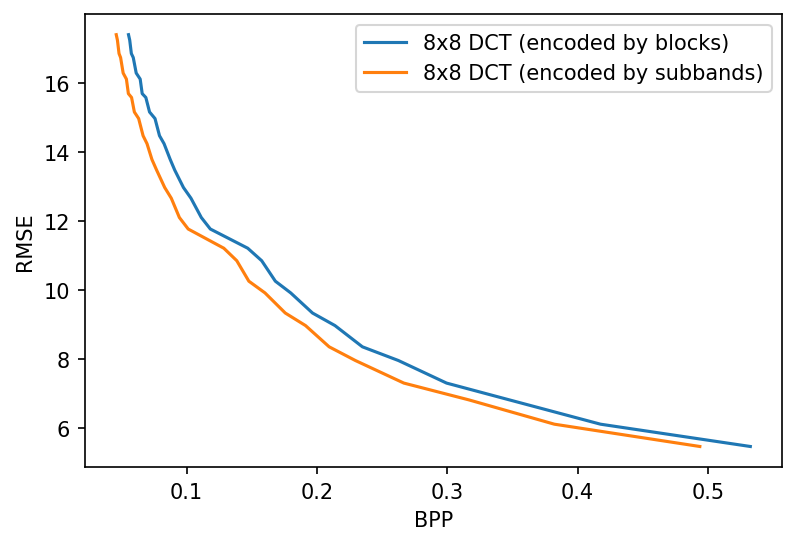

In [120]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_blocks), label=f"{block_y_side}x{block_x_side} DCT (encoded by blocks)")
pylab.plot(*zip(*RD_points_subbands), label=f"{block_y_side}x{block_x_side} DCT (encoded by subbands)")
pylab.title("")
pylab.xlabel("BPP")
pylab.ylabel("RMSE")
plt.legend(loc="best")
pylab.show()

Coding by subbands is more efficient because PNG can exploit better the spatial correlation between the coefficients.

In [41]:
with open('DCT_uniform.txt', 'w') as f:
    for item in RD_points_subbands:
        f.write(f"{item[0]}\t{item[1]}\n")

## Can we do it better?

Let's compute the optimal sequence of quantization steps for the set of possible combinations of subbands and components. We will compute the distortion of each subband-component in the YCoCg/8x8-DCT domain for a set of quantization steps, considering that the YCoCg transform is near-orthogonal and that the 8x8-DCT is full-orthogonal. Thanks to orthogonality, we can assume that the quantization error generated in one subband does not influence on the quantization error added to the other subbands because the DCT coefficients are uncorrelated, or in other words, that the quantization error generated in one coefficient (or subband) is not correlated with the quantization error generated in other coefficients (or subbands).

Algorithm:
1. Read the image.
2. Transform it to the YCoCg domain.
3. Transform each YCoCg component to the 8x8-DCT domain.
4. Find a set RD points for each subband-component.
5. Compute the slope of each point and put all the slopes in the same list.
6. Sort the previous list by the slope field.
7. Find the RD curve that progressively uses smaller slopes.

### Read the image and move to the 0-mean YCoCg domain

In [42]:
img = image_3.read(test_image, 0)
#xx = YUV.from_RGB(img.astype(np.int16) - 128)
YUV_img = YUV.from_RGB(img.astype(np.int16))

# Shift the YCoCg components to the zero mean.
# We will not need this information later (in this notebook)
# because we will not reconstruct the images.
# The distortion is computed in the DCT domain.
#YUV_img[...,0] -= np.average(YUV_img[...,0]).astype(np.int16)
#YUV_img[...,1] -= np.average(YUV_img[...,1]).astype(np.int16)
#YUV_img[...,2] -= np.average(YUV_img[...,2]).astype(np.int16)

avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])

avgs=[120.56250381469727, 37.16556930541992, -21.529052734375]


### Move each component to the 8x8-DCT domain

In [43]:
DCT_blocks = block_DCT.analyze_image(YUV_img, block_y_side, block_x_side)
DCT_subbands = block_DCT.get_subbands(DCT_blocks, block_y_side, block_x_side)

component=0 max=1.0 min=0.0 dtype=float32
component=1 max=0.6093870997428894 min=0.20768503844738007 dtype=float32
component=2 max=0.594429612159729 min=0.36069801449775696 dtype=float32


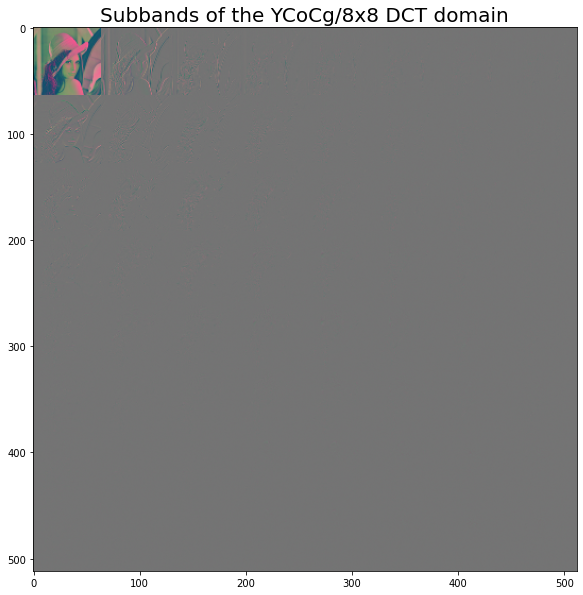

In [44]:
image_3.show(image_3.normalize(DCT_subbands), f"Subbands of the {YUV.name}/{block_y_side}x{block_x_side} DCT domain")

### Find the slope of each quantization step for each subband-component
Create a list per subband-component of RD points and a list per subband-component of RD slopes. The first RD point is computed for 0 BPP, where the MSE distortion is equal to the average energy of the subband-component (notice that the average of each subband-component should be 0).

In [45]:
RD_points = []
RD_slopes = []
N_components = YUV_img.shape[2]
for _y in range(block_y_side):
    for _x in range(block_x_side):
        for _c in range(N_components):
            sbc = DCT_subbands[blocks_in_y*_y : blocks_in_y*(_y + 1), blocks_in_x*_x : blocks_in_x*(_x + 1), _c]
            sbc_energy = information.average_energy(sbc)
            # The first point of each RD curve has a maximum distortion equal
            # to the energy of the subband and a rate = 0
            RD_points.append([(0, sbc_energy)])
            RD_slopes.append([])

In [46]:
RD_points # (BPP, RMSE)

[[(0, 114085.89736557007)],
 [(0, 18855.201763153076)],
 [(0, 4517.971809387207)],
 [(0, 6692.434434646009)],
 [(0, 575.2294208166115)],
 [(0, 241.96876757885042)],
 [(0, 1463.8310900520453)],
 [(0, 119.50899008072562)],
 [(0, 62.72982090742795)],
 [(0, 448.75477591633137)],
 [(0, 40.79334151622254)],
 [(0, 20.86655889434661)],
 [(0, 209.47016525268555)],
 [(0, 26.341045379638672)],
 [(0, 9.850608825683594)],
 [(0, 99.04060714291407)],
 [(0, 20.92946583306132)],
 [(0, 4.970486224429395)],
 [(0, 47.1054747629399)],
 [(0, 18.03110209685457)],
 [(0, 3.909155996952479)],
 [(0, 27.388296074728814)],
 [(0, 15.386471753672215)],
 [(0, 3.790593069860683)],
 [(0, 2635.328986024704)],
 [(0, 257.86671608443385)],
 [(0, 91.9032223880431)],
 [(0, 1268.0107230820104)],
 [(0, 110.96571890060997)],
 [(0, 50.78263807828082)],
 [(0, 580.6401667240789)],
 [(0, 47.03534907907053)],
 [(0, 24.66041764205599)],
 [(0, 289.3268885216904)],
 [(0, 24.547226649646134)],
 [(0, 14.479498876145167)],
 [(0, 115.76283

In [47]:
len(RD_points)

192

In [48]:
8*8*3

192

Now populate the rest of points of each subband-component. **Distortion is estimated in the transform domain** because we are searching RD points for sorting the quantization patterns, not for obtaining true distortion measures that would demand more computation.

In [49]:
for _y in range(block_y_side):
    for _x in range(block_x_side):
        for _c in range(N_components):
            sbc = DCT_subbands[blocks_in_y*_y : blocks_in_y*(_y + 1), blocks_in_x*_x : blocks_in_x*(_x + 1), _c]
            counter = 0
            for Q_step in Q_steps:
                sbc_k = Q.quantize(sbc, Q_step)
                sbc_dQ = Q.dequantize(sbc_k, Q_step)
                RMSE = distortion.RMSE(sbc, sbc_dQ)
                BPP = image_1.write(sbc_k.astype(np.uint8), f"/tmp/{_y}_{_x}_{_c}_{Q_step}_", 0)*8/YUV_img.size
                point = (BPP, RMSE)
                RD_points[(_y * block_x_side * N_components + _x * N_components ) + _c].append(point)
                print("Q_step =", Q_step, "BPP =", point[0], "RMSE =", point[1])
                delta_BPP = BPP - RD_points[(_y*block_x_side + _x)*N_components + _c][counter][0]
                delta_RMSE = RD_points[(_y*block_x_side + _x)*N_components + _c][counter][1] - RMSE
                if delta_BPP > 0:
                    slope = delta_RMSE/delta_BPP
                    RD_slopes[(_y*block_x_side + _x)*N_components + _c].append((slope, (_y, _x, _c), Q_step))
                else:
                    slope = 0
                #RD_slopes[(_y * block_x_side * N_components + _x * N_components) + _c].append((Q_step, slope, (_y, _x, _c)))
                counter += 1

** Processing: /tmp/0_0_0_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 12 colors in palette
Input IDAT size = 1199 bytes
Input file size = 1256 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 1157
  zc = 1  zm = 8  zs = 2  f = 5		IDAT size = 1114
                               
Selecting parameters:
  zc = 1  zm = 8  zs = 2  f = 5		IDAT size = 1114

Output IDAT size = 1114 bytes (85 bytes decrease)
Output file size = 1219 bytes (37 bytes = 2.95% decrease)

** Processing: /tmp/0_0_0_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Input IDAT size = 1627 bytes
Input file size = 1684 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 1627
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 1500
  zc = 1  zm = 8  zs = 2  f = 5		IDAT size = 1369
                               
Selecting parameters:
  zc = 1  zm = 8  zs = 2  f = 5		IDAT size = 1369

Output IDAT size = 1369 bytes (258 bytes decrease)
Output file size = 1426 bytes (258 bytes =

Q_step = 128 BPP = 0.012400309244791666 RMSE = 69.81447864211312
Q_step = 64 BPP = 0.014506022135416666 RMSE = 35.73927535737215
Q_step = 32 BPP = 0.019551595052083332 RMSE = 18.33879570937166
Q_step = 16 BPP = 0.024627685546875 RMSE = 9.113804258928779
Q_step = 8 BPP = 0.030110677083333332 RMSE = 4.562543058845402
Q_step = 128 BPP = 0.005808512369791667 RMSE = 64.50998140329197
Q_step = 64 BPP = 0.009755452473958334 RMSE = 34.91086033604838
Q_step = 32 BPP = 0.0123291015625 RMSE = 18.107766739111597
Q_step = 16 BPP = 0.017120361328125 RMSE = 9.043763253097472
Q_step = 8 BPP = 0.022115071614583332 RMSE = 4.50727552789112
Q_step = 128 BPP = 0.0024007161458333335 RMSE = 55.483344319599254
Q_step = 64 BPP = 0.006886800130208333 RMSE = 38.263007551513866
Q_step = 32 BPP = 0.010477701822916666 RMSE = 17.721233644619865
Q_step = 16 BPP = 0.012481689453125 RMSE = 9.069401079989076
Q_step = 8 BPP = 0.0172119140625 RMSE = 4.557160061343801
Q_step = 128 BPP = 0.005696614583333333 RMSE = 43.64433

  zc = 1  zm = 8  zs = 2  f = 5		IDAT size = 1750
                               
Selecting parameters:
  zc = 1  zm = 8  zs = 2  f = 5		IDAT size = 1750

Output IDAT size = 1750 bytes (204 bytes decrease)
Output file size = 1807 bytes (204 bytes = 10.14% decrease)

** Processing: /tmp/0_1_0_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Input IDAT size = 2519 bytes
Input file size = 2576 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 2425
  zc = 1  zm = 8  zs = 2  f = 0		IDAT size = 2387
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 2368
  zc = 1  zm = 8  zs = 2  f = 5		IDAT size = 2326
                               
Selecting parameters:
  zc = 1  zm = 8  zs = 2  f = 5		IDAT size = 2326

Output IDAT size = 2326 bytes (193 bytes decrease)
Output file size = 2383 bytes (193 bytes = 7.49% decrease)

** Processing: /tmp/0_1_1_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 36 bytes
Input file size = 93 

Q_step = 16 BPP = 0.018381754557291668 RMSE = 8.493782353932485
Q_step = 8 BPP = 0.024241129557291668 RMSE = 4.457127723562366
Q_step = 128 BPP = 0.000946044921875 RMSE = 23.611420420481426
Q_step = 64 BPP = 0.002777099609375 RMSE = 17.908840781912517
Q_step = 32 BPP = 0.00634765625 RMSE = 11.583672998888028
Q_step = 16 BPP = 0.010080973307291666 RMSE = 7.525432834443259
Q_step = 8 BPP = 0.015146891276041666 RMSE = 4.236676967921911
Q_step = 128 BPP = 0.0008544921875 RMSE = 15.555345305677095
Q_step = 64 BPP = 0.0017191569010416667 RMSE = 13.08184075050052
Q_step = 32 BPP = 0.0035909016927083335 RMSE = 9.44762651330815
Q_step = 16 BPP = 0.007314046223958333 RMSE = 6.073618068244368
Q_step = 8 BPP = 0.011027018229166666 RMSE = 3.701299934278811
Q_step = 128 BPP = 0.002288818359375 RMSE = 29.195254748997634
Q_step = 64 BPP = 0.004852294921875 RMSE = 19.62320605254535
Q_step = 32 BPP = 0.008209228515625 RMSE = 12.185760976304522
Q_step = 16 BPP = 0.012034098307291666 RMSE = 7.305777107687

                               
Selecting parameters:
  zc = 1  zm = 8  zs = 2  f = 0		IDAT size = 1597

Output IDAT size = 1597 bytes (189 bytes decrease)
Output file size = 1654 bytes (189 bytes = 10.26% decrease)

** Processing: /tmp/0_2_1_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/0_2_1_128_000.png is already optimized.

** Processing: /tmp/0_2_1_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 43 bytes
Input file size = 100 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 32
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 32
                               
/tmp/0_2_1_64_000.png is already opt

Q_step = 8 BPP = 0.016825358072916668 RMSE = 4.101504056649417
Q_step = 128 BPP = 0.0008544921875 RMSE = 10.932016743525672
Q_step = 64 BPP = 0.0010172526041666667 RMSE = 10.580831647777915
Q_step = 32 BPP = 0.0024007161458333335 RMSE = 8.557351640840452
Q_step = 16 BPP = 0.0057373046875 RMSE = 5.985603098320858
Q_step = 8 BPP = 0.009857177734375 RMSE = 3.8249312548614345
Q_step = 128 BPP = 0.0008544921875 RMSE = 7.92021596343357
Q_step = 64 BPP = 0.0009663899739583334 RMSE = 7.617649893807166
Q_step = 32 BPP = 0.0016988118489583333 RMSE = 6.362202903678109
Q_step = 16 BPP = 0.0038350423177083335 RMSE = 4.637581951422566
Q_step = 8 BPP = 0.007110595703125 RMSE = 3.143909001289572
Q_step = 128 BPP = 0.0012003580729166667 RMSE = 19.140786304307838
Q_step = 64 BPP = 0.00244140625 RMSE = 14.906523349302716
Q_step = 32 BPP = 0.004933675130208333 RMSE = 10.04012275642332
Q_step = 16 BPP = 0.007710774739583333 RMSE = 6.580924791015072
Q_step = 8 BPP = 0.012542724609375 RMSE = 3.93754713009367

** Processing: /tmp/0_3_2_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 50 bytes
Input file size = 107 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 29
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 29
                               
/tmp/0_3_2_32_000.png is already optimized.

** Processing: /tmp/0_3_2_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 5 colors in palette
Input IDAT size = 131 bytes
Input file size = 188 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 128
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 128
                               
/tmp/0_3_2_16_000.png is already optimized.

** Processing: /tmp/0_3_2_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 8 colors in palette
Input IDAT size = 357 bytes
Input file size = 414 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 347
  zc = 9  zm = 8  zs = 1  f =

Q_step = 32 BPP = 0.0010884602864583333 RMSE = 4.356132797098322
Q_step = 16 BPP = 0.0019124348958333333 RMSE = 3.710334610379355
Q_step = 8 BPP = 0.00421142578125 RMSE = 2.870816730547997
Q_step = 128 BPP = 0.0008951822916666666 RMSE = 14.229750182370932
Q_step = 64 BPP = 0.0016276041666666667 RMSE = 11.856459589720936
Q_step = 32 BPP = 0.0035400390625 RMSE = 8.164773397203719
Q_step = 16 BPP = 0.006123860677083333 RMSE = 5.67576478350588
Q_step = 8 BPP = 0.010009765625 RMSE = 3.652167755619332
Q_step = 128 BPP = 0.0008544921875 RMSE = 5.132352811298018
Q_step = 64 BPP = 0.0008544921875 RMSE = 5.132352811298018
Q_step = 32 BPP = 0.000946044921875 RMSE = 5.050064826775857
Q_step = 16 BPP = 0.001922607421875 RMSE = 4.409820192438539
Q_step = 8 BPP = 0.005299886067708333 RMSE = 3.3251131425695384
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.1385679577927883
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.1385679577927883
Q_step = 32 BPP = 0.0008951822916666666 RMSE = 3.0861686523395955
Q_step 

** Processing: /tmp/0_5_1_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 8 colors in palette
Input IDAT size = 399 bytes
Input file size = 456 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 389
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 382
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 375
                               
/tmp/0_5_1_8_000.png is already optimized.

** Processing: /tmp/0_5_2_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/0_5_2_128_000.png is already optimized.

** Processing: /tmp/0_5_2_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input 

Q_step = 8 BPP = 0.004638671875 RMSE = 3.294257964711449
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.229458729025813
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.229458729025813
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.229458729025813
Q_step = 16 BPP = 0.0008951822916666666 RMSE = 2.215306901523476
Q_step = 8 BPP = 0.001495361328125 RMSE = 2.0561416127425356
Q_step = 128 BPP = 0.0008544921875 RMSE = 6.863342827146251
Q_step = 64 BPP = 0.000946044921875 RMSE = 6.6949980087949985
Q_step = 32 BPP = 0.0014546712239583333 RMSE = 5.852168246038036
Q_step = 16 BPP = 0.0031026204427083335 RMSE = 4.53132746814666
Q_step = 8 BPP = 0.006327311197916667 RMSE = 3.3314056335114386
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.246304522388211
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.246304522388211
Q_step = 32 BPP = 0.0009256998697916666 RMSE = 4.166282238211644
Q_step = 16 BPP = 0.0013631184895833333 RMSE = 3.9561532287979504
Q_step = 8 BPP = 0.00408935546875 RMSE = 3.215296864329122
Q_step = 128 BP

** Processing: /tmp/0_7_1_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 7 colors in palette
Input IDAT size = 270 bytes
Input file size = 327 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 265
                               
/tmp/0_7_1_8_000.png is already optimized.

** Processing: /tmp/0_7_2_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/0_7_2_128_000.png is already optimized.

** Processing: /tmp/0_7_2_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs

 BPP = 0.003326416015625 RMSE = 3.1948303686844612
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.9469445471971416
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.9469445471971416
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.9469445471971416
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.9469445471971416
Q_step = 8 BPP = 0.0010172526041666667 RMSE = 1.928402247986118
Q_step = 128 BPP = 0.0031636555989583335 RMSE = 33.002145767527814
Q_step = 64 BPP = 0.006256103515625 RMSE = 21.910286744491273
Q_step = 32 BPP = 0.009724934895833334 RMSE = 13.5582182792332
Q_step = 16 BPP = 0.014068603515625 RMSE = 7.924027837342975
Q_step = 8 BPP = 0.019938151041666668 RMSE = 4.355266689334408
Q_step = 128 BPP = 0.0008544921875 RMSE = 16.058228921161692
Q_step = 64 BPP = 0.0017598470052083333 RMSE = 12.972482780528601
Q_step = 32 BPP = 0.0037943522135416665 RMSE = 9.554893082707276
Q_step = 16 BPP = 0.007283528645833333 RMSE = 6.6781240996511455
Q_step = 8 BPP = 0.011637369791666666 RMSE = 4.097295325354397
Q_step =

** Processing: /tmp/1_1_0_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 8 colors in palette
Input IDAT size = 375 bytes
Input file size = 432 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 374
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 365
                               
/tmp/1_1_0_64_000.png is already optimized.

** Processing: /tmp/1_1_0_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 16 colors in palette
Input IDAT size = 739 bytes
Input file size = 796 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 726
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 705
  zc = 1  zm = 8  zs = 2  f = 0		IDAT size = 671
                               
Selecting parameters:
  zc = 1  zm = 8  zs = 2  f = 0		IDAT size = 671

Output IDAT size = 671 bytes (68 bytes decrease)
Output file size = 788 bytes (8 bytes = 1.01% decrease)

** Processing: /tmp/1_1_0_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Input ID

Q_step = 32 BPP = 0.008015950520833334 RMSE = 11.883106580334541
Q_step = 16 BPP = 0.0115966796875 RMSE = 6.896852013917699
Q_step = 8 BPP = 0.016265869140625 RMSE = 4.012248526793805
Q_step = 128 BPP = 0.0008544921875 RMSE = 10.53402671824075
Q_step = 64 BPP = 0.0009765625 RMSE = 10.259101730268698
Q_step = 32 BPP = 0.002197265625 RMSE = 8.081591113735307
Q_step = 16 BPP = 0.005055745442708333 RMSE = 5.809799023579192
Q_step = 8 BPP = 0.009531656901041666 RMSE = 3.7319505751549533
Q_step = 128 BPP = 0.0008544921875 RMSE = 7.1261938002190774
Q_step = 64 BPP = 0.0008544921875 RMSE = 7.1261938002190774
Q_step = 32 BPP = 0.001434326171875 RMSE = 6.032808903301298
Q_step = 16 BPP = 0.0033060709635416665 RMSE = 4.415626780995824
Q_step = 8 BPP = 0.006663004557291667 RMSE = 2.99749540197827
Q_step = 128 BPP = 0.001312255859375 RMSE = 21.414672986772178
Q_step = 64 BPP = 0.0028788248697916665 RMSE = 15.46382934335549
Q_step = 32 BPP = 0.005635579427083333 RMSE = 10.199132858042931
Q_step = 16

** Processing: /tmp/1_2_1_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 13 colors in palette
Input IDAT size = 642 bytes
Input file size = 699 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 633
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 612
  zc = 1  zm = 8  zs = 2  f = 0		IDAT size = 563
                               
Selecting parameters:
  zc = 1  zm = 8  zs = 2  f = 0		IDAT size = 563

Output IDAT size = 563 bytes (79 bytes decrease)
Output file size = 671 bytes (28 bytes = 4.01% decrease)

** Processing: /tmp/1_2_2_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/1_2_2_128_000.png is already optimized.

** Processing: /tmp/1_

Q_step = 64 BPP = 0.0008544921875 RMSE = 4.965925658128199
Q_step = 32 BPP = 0.00103759765625 RMSE = 4.715538842360143
Q_step = 16 BPP = 0.0021260579427083335 RMSE = 3.8305466635705208
Q_step = 8 BPP = 0.004811604817708333 RMSE = 2.7367888932598485
Q_step = 128 BPP = 0.000946044921875 RMSE = 16.540579673248637
Q_step = 64 BPP = 0.0018717447916666667 RMSE = 13.047193291113926
Q_step = 32 BPP = 0.0040283203125 RMSE = 8.957423782020115
Q_step = 16 BPP = 0.0064697265625 RMSE = 5.8565413010548815
Q_step = 8 BPP = 0.010762532552083334 RMSE = 3.6558233986190807
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.95451578357019
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.95451578357019
Q_step = 32 BPP = 0.0009256998697916666 RMSE = 4.885076426469399
Q_step = 16 BPP = 0.001800537109375 RMSE = 4.333876666154101
Q_step = 8 BPP = 0.005147298177083333 RMSE = 3.2680818760180235
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.8051936713057284
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.8051936713057284
Q_step = 32

** Processing: /tmp/1_4_0_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Input IDAT size = 840 bytes
Input file size = 897 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 840
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 798
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 769
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 769

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 769

Output IDAT size = 769 bytes (71 bytes decrease)
Output file size = 826 bytes (71 bytes = 7.92% decrease)

** Processing: /tmp/1_4_1_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/1_4_1_128_000.png is already optimized.

** Processing: /tmp/1_4_1_64_000.png
64x64 pixels, 8 bits

 3.461599900710987
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.404544546872237
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.404544546872237
Q_step = 32 BPP = 0.00091552734375 RMSE = 4.339181232372267
Q_step = 16 BPP = 0.0014444986979166667 RMSE = 4.039559740562459
Q_step = 8 BPP = 0.004384358723958333 RMSE = 3.190057599846158
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.6049750555487385
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.6049750555487385
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.6049750555487385
Q_step = 16 BPP = 0.0010172526041666667 RMSE = 2.485910419097595
Q_step = 8 BPP = 0.0019327799479166667 RMSE = 2.1558123870450023
Q_step = 128 BPP = 0.0008544921875 RMSE = 8.01520780407064
Q_step = 64 BPP = 0.0009867350260416667 RMSE = 7.7254038791945225
Q_step = 32 BPP = 0.0017598470052083333 RMSE = 6.454770241046401
Q_step = 16 BPP = 0.003448486328125 RMSE = 4.8518655655275245
Q_step = 8 BPP = 0.007049560546875 RMSE = 3.311148930921499
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.1698572

** Processing: /tmp/1_6_0_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/1_6_0_128_000.png is already optimized.

** Processing: /tmp/1_6_0_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 2 colors in palette
Input IDAT size = 32 bytes
Input file size = 89 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 19
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 19
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 19
                               
/tmp/1_6_0_64_000.png is already optimized.

** Processing: /tmp/1_6_0_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 4 color

Q_step = 64 BPP = 0.0009053548177083334 RMSE = 5.850909719957182
Q_step = 32 BPP = 0.001251220703125 RMSE = 5.394320244182781
Q_step = 16 BPP = 0.002593994140625 RMSE = 4.333222460157973
Q_step = 8 BPP = 0.005421956380208333 RMSE = 3.227194826802173
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.9676517871937533
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.9676517871937533
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.9676517871937533
Q_step = 16 BPP = 0.0012105305989583333 RMSE = 3.817978808597957
Q_step = 8 BPP = 0.003570556640625 RMSE = 3.1538767553532283
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.9053956113488486
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.9053956113488486
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.9053956113488486
Q_step = 16 BPP = 0.0009053548177083334 RMSE = 1.883626585690262
Q_step = 8 BPP = 0.0010579427083333333 RMSE = 1.8572219395182903
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.561551103906433
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.561551103906433
Q_step = 32 B

** Processing: /tmp/2_0_0_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 6 colors in palette
Input IDAT size = 172 bytes
Input file size = 229 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 172
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 168
                               
/tmp/2_0_0_64_000.png is already optimized.

** Processing: /tmp/2_0_0_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 11 colors in palette
Input IDAT size = 418 bytes
Input file size = 475 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 405
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 398
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 372
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 372

Output IDAT size = 372 bytes (46 bytes decrease)
Output file size = 474 bytes (1 byte = 0.21% decrease)

** Processing: /tmp/2_0_0_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Input IDA

Q_step = 32 BPP = 0.00482177734375 RMSE = 9.797253704992631
Q_step = 16 BPP = 0.007649739583333333 RMSE = 6.282501442677476
Q_step = 8 BPP = 0.012227376302083334 RMSE = 3.8565883662808464
Q_step = 128 BPP = 0.0008544921875 RMSE = 8.1186715772609
Q_step = 64 BPP = 0.0009765625 RMSE = 7.7694472592220185
Q_step = 32 BPP = 0.001708984375 RMSE = 6.554893606521862
Q_step = 16 BPP = 0.0034891764322916665 RMSE = 4.981319163625345
Q_step = 8 BPP = 0.006988525390625 RMSE = 3.51589421756407
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.113935972292139
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.113935972292139
Q_step = 32 BPP = 0.000946044921875 RMSE = 3.975518658731914
Q_step = 16 BPP = 0.0017598470052083333 RMSE = 3.3091442946050003
Q_step = 8 BPP = 0.00360107421875 RMSE = 2.5716353334300375
Q_step = 128 BPP = 0.00103759765625 RMSE = 19.82979981004473
Q_step = 64 BPP = 0.0024820963541666665 RMSE = 14.794482604994327
Q_step = 32 BPP = 0.004954020182291667 RMSE = 9.63973792504926
Q_step = 16 BPP = 0

** Processing: /tmp/2_1_1_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 13 colors in palette
Input IDAT size = 612 bytes
Input file size = 669 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 596
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 569
  zc = 1  zm = 8  zs = 2  f = 0		IDAT size = 559
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 550
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 550

Output IDAT size = 550 bytes (62 bytes decrease)
Output file size = 658 bytes (11 bytes = 1.64% decrease)

** Processing: /tmp/2_1_2_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/2_1_2_128_000.

Q_step = 128 BPP = 0.0008544921875 RMSE = 4.294673900880556
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.294673900880556
Q_step = 32 BPP = 0.0009765625 RMSE = 4.150716084527316
Q_step = 16 BPP = 0.0018412272135416667 RMSE = 3.489968954817873
Q_step = 8 BPP = 0.004109700520833333 RMSE = 2.521446039485732
Q_step = 128 BPP = 0.00103759765625 RMSE = 17.62000522072589
Q_step = 64 BPP = 0.0021260579427083335 RMSE = 13.503263312560112
Q_step = 32 BPP = 0.004302978515625 RMSE = 9.077900904306981
Q_step = 16 BPP = 0.006693522135416667 RMSE = 5.815292739887291
Q_step = 8 BPP = 0.010640462239583334 RMSE = 3.6044585935618954
Q_step = 128 BPP = 0.0008544921875 RMSE = 5.556692661240357
Q_step = 64 BPP = 0.0008544921875 RMSE = 5.556692661240357
Q_step = 32 BPP = 0.001007080078125 RMSE = 5.367080832887516
Q_step = 16 BPP = 0.0024007161458333335 RMSE = 4.319977372733604
Q_step = 8 BPP = 0.005462646484375 RMSE = 3.225934662114903
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.035227707387487
Q_step = 64 BPP 

** Processing: /tmp/2_3_0_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Input IDAT size = 915 bytes
Input file size = 972 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 910
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 852
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 831
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 831

Output IDAT size = 831 bytes (84 bytes decrease)
Output file size = 888 bytes (84 bytes = 8.64% decrease)

** Processing: /tmp/2_3_1_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/2_3_1_128_000.png is already optimized.

** Processing: /tmp/2_3_1_64_000.png
64x64 pixels, 8 bits/pixel, grayscale


Q_step = 128 BPP = 0.0008544921875 RMSE = 4.610530417609656
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.610530417609656
Q_step = 32 BPP = 0.0008544921875 RMSE = 4.610530417609656
Q_step = 16 BPP = 0.0016988118489583333 RMSE = 4.12272974248989
Q_step = 8 BPP = 0.004475911458333333 RMSE = 3.120783902218036
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.1386410611506883
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.1386410611506883
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.1386410611506883
Q_step = 16 BPP = 0.0013529459635416667 RMSE = 2.8196820990477764
Q_step = 8 BPP = 0.0027669270833333335 RMSE = 2.2447147075158376
Q_step = 128 BPP = 0.0008544921875 RMSE = 9.257100732824004
Q_step = 64 BPP = 0.0009969075520833333 RMSE = 8.704784230655182
Q_step = 32 BPP = 0.0020751953125 RMSE = 6.7799834316206695
Q_step = 16 BPP = 0.004130045572916667 RMSE = 4.901431971946852
Q_step = 8 BPP = 0.007120768229166667 RMSE = 3.346324311835641
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.224346069117426
Q_step = 64

** Processing: /tmp/2_5_0_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 14 colors in palette
Input IDAT size = 538 bytes
Input file size = 595 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 535
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 524
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 512
                               
/tmp/2_5_0_8_000.png is already optimized.

** Processing: /tmp/2_5_1_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/2_5_1_128_000.png is already optimized.

** Processing: /tmp/2_5_1_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input

Q_step = 64 BPP = 0.0008544921875 RMSE = 3.973751126414216
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.973751126414216
Q_step = 16 BPP = 0.0011800130208333333 RMSE = 3.7698994758740403
Q_step = 8 BPP = 0.0033671061197916665 RMSE = 3.1379947929802987
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.9864607483552092
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.9864607483552092
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.9864607483552092
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.9864607483552092
Q_step = 8 BPP = 0.0012613932291666667 RMSE = 1.8986345034931658
Q_step = 128 BPP = 0.0008544921875 RMSE = 5.024864542223927
Q_step = 64 BPP = 0.0008544921875 RMSE = 5.024864542223927
Q_step = 32 BPP = 0.0009663899739583334 RMSE = 4.929474170947333
Q_step = 16 BPP = 0.0020243326822916665 RMSE = 4.163980967340345
Q_step = 8 BPP = 0.00482177734375 RMSE = 3.1615551599546023
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.665913525582697
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.665913525582697
Q_step = 32 BPP =

** Processing: /tmp/2_7_1_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 39 bytes
Input file size = 96 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 28
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 28
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 28
                               
/tmp/2_7_1_16_000.png is already optimized.

** Processing: /tmp/2_7_1_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 5 colors in palette
Input IDAT size = 176 bytes
Input file size = 233 bytes

Trying:
                               
/tmp/2_7_1_8_000.png is already optimized.

** Processing: /tmp/2_7_2_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT

Q_step = 128 BPP = 0.0008544921875 RMSE = 1.7819596246242673
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.7819596246242673
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.7819596246242673
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.7819596246242673
Q_step = 8 BPP = 0.00103759765625 RMSE = 1.7488250983483205
Q_step = 128 BPP = 0.0008544921875 RMSE = 11.495855320505793
Q_step = 64 BPP = 0.0012715657552083333 RMSE = 10.056182904233948
Q_step = 32 BPP = 0.002532958984375 RMSE = 7.623254345549705
Q_step = 16 BPP = 0.004933675130208333 RMSE = 5.417686600785986
Q_step = 8 BPP = 0.008748372395833334 RMSE = 3.5362207906361793
Q_step = 128 BPP = 0.0008544921875 RMSE = 5.235176948984013
Q_step = 64 BPP = 0.000885009765625 RMSE = 5.127532346643495
Q_step = 32 BPP = 0.001007080078125 RMSE = 5.01268767439855
Q_step = 16 BPP = 0.0020548502604166665 RMSE = 4.157754559681184
Q_step = 8 BPP = 0.004791259765625 RMSE = 3.1959217369694914
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.722560383205817
Q_step = 64 BPP 

  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 402
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 402

Output IDAT size = 402 bytes (70 bytes decrease)
Output file size = 507 bytes (22 bytes = 4.16% decrease)

** Processing: /tmp/3_1_0_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Input IDAT size = 829 bytes
Input file size = 886 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 829
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 783
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 760
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 760

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 760

Output IDAT size = 760 bytes (69 bytes decrease)
Output file size = 817 bytes (69 bytes = 7.79% decrease)

** Processing: /tmp/3_1_1_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDA

Q_step = 8 BPP = 0.008310953776041666 RMSE = 3.433694102876178
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.6714002551206315
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.6714002551206315
Q_step = 32 BPP = 0.0009663899739583334 RMSE = 4.579084457078125
Q_step = 16 BPP = 0.0018513997395833333 RMSE = 3.9972014809181453
Q_step = 8 BPP = 0.004496256510416667 RMSE = 3.096586543812274
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.8945778970579075
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.8945778970579075
Q_step = 32 BPP = 0.0008951822916666666 RMSE = 2.8374127799104305
Q_step = 16 BPP = 0.0011189778645833333 RMSE = 2.694919121845245
Q_step = 8 BPP = 0.0023600260416666665 RMSE = 2.243946448532141
Q_step = 128 BPP = 0.0008544921875 RMSE = 10.973576585799586
Q_step = 64 BPP = 0.0011800130208333333 RMSE = 10.097632628640486
Q_step = 32 BPP = 0.0025227864583333335 RMSE = 7.574148175190125
Q_step = 16 BPP = 0.005035400390625 RMSE = 5.0977059378347205
Q_step = 8 BPP = 0.008015950520833334 RMSE = 3.39864

** Processing: /tmp/3_2_2_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/3_2_2_64_000.png is already optimized.

** Processing: /tmp/3_2_2_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/3_2_2_32_000.png is already optimized.

** Processing: /tmp/3_2_2_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 55 

Q_step = 8 BPP = 0.0026448567708333335 RMSE = 2.221187847530958
Q_step = 128 BPP = 0.0008544921875 RMSE = 9.25947729973521
Q_step = 64 BPP = 0.0011088053385416667 RMSE = 8.794377085655347
Q_step = 32 BPP = 0.0020548502604166665 RMSE = 7.010886594878914
Q_step = 16 BPP = 0.004282633463541667 RMSE = 4.958886567867393
Q_step = 8 BPP = 0.007008870442708333 RMSE = 3.2935689197466194
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.495616588413189
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.495616588413189
Q_step = 32 BPP = 0.0008951822916666666 RMSE = 4.429597469372529
Q_step = 16 BPP = 0.0017801920572916667 RMSE = 3.8771603190239876
Q_step = 8 BPP = 0.004140218098958333 RMSE = 2.9783370317824636
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.682451817708956
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.682451817708956
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.682451817708956
Q_step = 16 BPP = 0.0010986328125 RMSE = 2.5565408133506917
Q_step = 8 BPP = 0.0021565755208333335 RMSE = 2.1837187089833203
Q_

64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 5 colors in palette
Input IDAT size = 98 bytes
Input file size = 155 bytes

Trying:
                               
/tmp/3_4_1_16_000.png is already optimized.

** Processing: /tmp/3_4_1_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 10 colors in palette
Input IDAT size = 279 bytes
Input file size = 336 bytes

Trying:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 269
                               
/tmp/3_4_1_8_000.png is already optimized.

** Processing: /tmp/3_4_2_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/3_4_2_128_000.png is already optimized.

** Processing: /tmp/3_4_

Q_step = 32 BPP = 0.0008544921875 RMSE = 2.3818853346448527
Q_step = 16 BPP = 0.001007080078125 RMSE = 2.298285582086103
Q_step = 8 BPP = 0.00177001953125 RMSE = 2.020411691165442
Q_step = 128 BPP = 0.0008544921875 RMSE = 5.651872593272129
Q_step = 64 BPP = 0.0008544921875 RMSE = 5.651872593272129
Q_step = 32 BPP = 0.0012105305989583333 RMSE = 5.120158057384913
Q_step = 16 BPP = 0.002349853515625 RMSE = 4.168401185041275
Q_step = 8 BPP = 0.005126953125 RMSE = 3.0807335363094794
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.973872236134009
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.973872236134009
Q_step = 32 BPP = 0.0009053548177083334 RMSE = 3.9407242337528525
Q_step = 16 BPP = 0.00140380859375 RMSE = 3.605409311990441
Q_step = 8 BPP = 0.0032552083333333335 RMSE = 3.036066775126394
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.9583402642134078
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.9583402642134078
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.9583402642134078
Q_step = 16 BPP = 0.0009053

** Processing: /tmp/3_6_2_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/3_6_2_64_000.png is already optimized.

** Processing: /tmp/3_6_2_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/3_6_2_32_000.png is already optimized.

** Processing: /tmp/3_6_2_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 by

Q_step = 64 BPP = 0.0008544921875 RMSE = 3.538453863571838
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.538453863571838
Q_step = 16 BPP = 0.0011189778645833333 RMSE = 3.4088493555530452
Q_step = 8 BPP = 0.00286865234375 RMSE = 2.8547010650243476
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.04307848394225
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.04307848394225
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.04307848394225
Q_step = 16 BPP = 0.0008951822916666666 RMSE = 3.015940079963654
Q_step = 8 BPP = 0.0018717447916666667 RMSE = 2.7898790486078493
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.7557279278072078
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.7557279278072078
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.7557279278072078
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.7557279278072078
Q_step = 8 BPP = 0.001007080078125 RMSE = 1.7218822432970042
Q_step = 128 BPP = 0.0008544921875 RMSE = 6.876354569591947
Q_step = 64 BPP = 0.000946044921875 RMSE = 6.569867458080722
Q_step = 32 BPP = 0.00136311

** Processing: /tmp/4_0_2_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 33 bytes
Input file size = 90 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 22
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 22

/tmp/4_0_2_16_000.png is already optimized.

** Processing: /tmp/4_0_2_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 5 colors in palette
Input IDAT size = 90 bytes
Input file size = 147 bytes

Trying:
                               
/tmp/4_0_2_8_000.png is already optimized.

** Processing: /tmp/4_1_0_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs 

Q_step = 32 BPP = 0.0012003580729166667 RMSE = 6.201197056203291
Q_step = 16 BPP = 0.0031636555989583335 RMSE = 4.564268892035304
Q_step = 8 BPP = 0.006418863932291667 RMSE = 3.2466423183731994
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.9485307380632775
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.9485307380632775
Q_step = 32 BPP = 0.0009256998697916666 RMSE = 3.8591959434624745
Q_step = 16 BPP = 0.0013936360677083333 RMSE = 3.5446834084329355
Q_step = 8 BPP = 0.00341796875 RMSE = 2.8625469501779737
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.2497226123152063
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.2497226123152063
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.2497226123152063
Q_step = 16 BPP = 0.0009053548177083334 RMSE = 2.225202211448685
Q_step = 8 BPP = 0.0015055338541666667 RMSE = 2.0366719367385717
Q_step = 128 BPP = 0.0008544921875 RMSE = 6.596109275697815
Q_step = 64 BPP = 0.0008544921875 RMSE = 6.596109275697815
Q_step = 32 BPP = 0.001220703125 RMSE = 6.082946772326706
Q_step =

** Processing: /tmp/4_2_2_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 5 colors in palette
Input IDAT size = 135 bytes
Input file size = 192 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 132
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 132
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 125
                               
/tmp/4_2_2_8_000.png is already optimized.

** Processing: /tmp/4_3_0_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/4_3_0_128_000.png is already optimized.

** Processing: /tmp/4_3_0_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 2 colors in palette
Input IDAT size = 31 bytes
Input

Q_step = 16 BPP = 0.0030721028645833335 RMSE = 4.522173980090862
Q_step = 8 BPP = 0.006154378255208333 RMSE = 3.129405154473963
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.04342359707257
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.04342359707257
Q_step = 32 BPP = 0.0009053548177083334 RMSE = 4.006741332683148
Q_step = 16 BPP = 0.00146484375 RMSE = 3.6139462621487315
Q_step = 8 BPP = 0.003509521484375 RMSE = 2.8257093063564374
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.4086050758428734
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.4086050758428734
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.4086050758428734
Q_step = 16 BPP = 0.0008951822916666666 RMSE = 2.3700872538721507
Q_step = 8 BPP = 0.0018208821614583333 RMSE = 1.9941775296000064
Q_step = 128 BPP = 0.0008544921875 RMSE = 5.520604811443295
Q_step = 64 BPP = 0.0008544921875 RMSE = 5.520604811443295
Q_step = 32 BPP = 0.0012105305989583333 RMSE = 5.077190043137135
Q_step = 16 BPP = 0.0022176106770833335 RMSE = 4.203041047459667
Q_step = 8

** Processing: /tmp/4_5_0_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/4_5_0_64_000.png is already optimized.

** Processing: /tmp/4_5_0_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 41 bytes
Input file size = 98 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 30
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 30
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 30
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 30
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 30

/tmp/4_5_0_32_000.png is already optimized.

** Processing: /tmp/4_5_0_16_000.png
64x64 pixels,

Q_step = 128 BPP = 0.0008544921875 RMSE = 3.5735272422000945
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.5735272422000945
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.5735272422000945
Q_step = 16 BPP = 0.0011393229166666667 RMSE = 3.397070630726497
Q_step = 8 BPP = 0.0029398600260416665 RMSE = 2.8255335358687153
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.8665759477201807
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.8665759477201807
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.8665759477201807
Q_step = 16 BPP = 0.0009053548177083334 RMSE = 1.847149068354416
Q_step = 8 BPP = 0.0011698404947916667 RMSE = 1.7605159471870455
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.6463606589509054
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.6463606589509054
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.6463606589509054
Q_step = 16 BPP = 0.0011393229166666667 RMSE = 3.44640172570687
Q_step = 8 BPP = 0.0030924479166666665 RMSE = 2.794473199041598
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.2440109141190216
Q_step =

** Processing: /tmp/4_7_1_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/4_7_1_128_000.png is already optimized.

** Processing: /tmp/4_7_1_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/4_7_1_64_000.png is already optimized.

** Processing: /tmp/4_7_1_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 

Q_step = 128 BPP = 0.0008544921875 RMSE = 1.6462992933193603
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.6462992933193603
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.6462992933193603
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.6462992933193603
Q_step = 8 BPP = 0.0009053548177083334 RMSE = 1.6312799018046624
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.6696539839211
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.6696539839211
Q_step = 32 BPP = 0.0009663899739583334 RMSE = 4.565057061406609
Q_step = 16 BPP = 0.0016581217447916667 RMSE = 4.025275285405483
Q_step = 8 BPP = 0.004486083984375 RMSE = 3.083902773117303
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.402452911285075
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.402452911285075
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.402452911285075
Q_step = 16 BPP = 0.0011393229166666667 RMSE = 3.2136139071910055
Q_step = 8 BPP = 0.002685546875 RMSE = 2.7956635847988593
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.9627018574693995
Q_step = 64 BPP = 0.000854

** Processing: /tmp/5_1_1_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 48 bytes
Input file size = 105 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 37
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 37
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 37
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 37
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 37

/tmp/5_1_1_16_000.png is already optimized.

** Processing: /tmp/5_1_1_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 5 colors in palette
Input IDAT size = 158 bytes
Input file size = 215 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 155
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 150
                               
/tmp/5_1_1_8_000.png is already optimized.

** Processing: /tmp/5_1_2_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 c

Q_step = 16 BPP = 0.0008951822916666666 RMSE = 1.937244733828498
Q_step = 8 BPP = 0.0012410481770833333 RMSE = 1.8402240271473458
Q_step = 128 BPP = 0.0008544921875 RMSE = 4.609376467150829
Q_step = 64 BPP = 0.0008544921875 RMSE = 4.609376467150829
Q_step = 32 BPP = 0.0009765625 RMSE = 4.483837673127043
Q_step = 16 BPP = 0.0018412272135416667 RMSE = 3.9226658822838476
Q_step = 8 BPP = 0.004292805989583333 RMSE = 2.9320088870459435
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.298789499441369
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.298789499441369
Q_step = 32 BPP = 0.0008951822916666666 RMSE = 3.2517976149777144
Q_step = 16 BPP = 0.00128173828125 RMSE = 2.9880997401963225
Q_step = 8 BPP = 0.0025126139322916665 RMSE = 2.5139989423773246
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.0582083094370085
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.0582083094370085
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.0582083094370085
Q_step = 16 BPP = 0.0009053548177083334 RMSE = 2.0194676344157223
Q_step 

** Processing: /tmp/5_3_2_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/5_3_2_64_000.png is already optimized.

** Processing: /tmp/5_3_2_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/5_3_2_32_000.png is already optimized.

** Processing: /tmp/5_3_2_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 by

Q_step = 64 BPP = 0.0008544921875 RMSE = 4.070485004393335
Q_step = 32 BPP = 0.0008544921875 RMSE = 4.070485004393335
Q_step = 16 BPP = 0.0014444986979166667 RMSE = 3.672431042437354
Q_step = 8 BPP = 0.00372314453125 RMSE = 2.903723172123823
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.289796088661547
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.289796088661547
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.289796088661547
Q_step = 16 BPP = 0.0011088053385416667 RMSE = 3.148335576344093
Q_step = 8 BPP = 0.00262451171875 RMSE = 2.638907738804647
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.8636558783520634
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.8636558783520634
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.8636558783520634
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.8636558783520634
Q_step = 8 BPP = 0.0012003580729166667 RMSE = 1.7706724332971375
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.5649942217772845
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.5649942217772845
Q_step = 32 BPP = 0.000854492

** Processing: /tmp/5_5_2_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/5_5_2_16_000.png is already optimized.

** Processing: /tmp/5_5_2_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 49 bytes
Input file size = 106 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 38
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 38
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 38
                               
/tmp/5_5_2_8_000.png is already optimized.

** Processing: /tmp/5_6_0_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color i

Q_step = 16 BPP = 0.0011189778645833333 RMSE = 3.0926278943203234
Q_step = 8 BPP = 0.00250244140625 RMSE = 2.671825045170123
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.8788601125194693
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.8788601125194693
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.8788601125194693
Q_step = 16 BPP = 0.0008544921875 RMSE = 2.8788601125194693
Q_step = 8 BPP = 0.0017191569010416667 RMSE = 2.654017075389886
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.6917989951278625
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.6917989951278625
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.6917989951278625
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.6917989951278625
Q_step = 8 BPP = 0.0011088053385416667 RMSE = 1.6313224206204975
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.005183380527635
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.005183380527635
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.005183380527635
Q_step = 16 BPP = 0.001068115234375 RMSE = 2.890664973411194
Q_step = 8 BPP = 0.001932

** Processing: /tmp/5_7_2_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/5_7_2_16_000.png is already optimized.

** Processing: /tmp/5_7_2_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 45 bytes
Input file size = 102 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 36
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 36
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 36
                               
/tmp/5_7_2_8_000.png is already optimized.

** Processing: /tmp/6_0_0_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color i

Q_step = 16 BPP = 0.0013427734375 RMSE = 3.3502979257650916
Q_step = 8 BPP = 0.0028788248697916665 RMSE = 2.830993342124739
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.924553786632961
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.924553786632961
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.924553786632961
Q_step = 16 BPP = 0.0009663899739583334 RMSE = 2.880702625263662
Q_step = 8 BPP = 0.001922607421875 RMSE = 2.6328973888602407
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.7562579712988324
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.7562579712988324
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.7562579712988324
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.7562579712988324
Q_step = 8 BPP = 0.0009867350260416667 RMSE = 1.7248439697861355
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.4710397217684923
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.4710397217684923
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.4710397217684923
Q_step = 16 BPP = 0.0011494954427083333 RMSE = 3.2822784683909
Q_step = 8 BPP = 0.002

** Processing: /tmp/6_1_2_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 39 bytes
Input file size = 96 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 30
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 30
                               
/tmp/6_1_2_8_000.png is already optimized.

** Processing: /tmp/6_2_0_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/6_2_0_128_000.png is already optimized.

** Processing: /tmp/6_2_0_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file 

2.6630164904467497
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.5834729649617327
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.5834729649617327
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.5834729649617327
Q_step = 16 BPP = 0.0009867350260416667 RMSE = 2.515812878985289
Q_step = 8 BPP = 0.0015767415364583333 RMSE = 2.333203484710641
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.6745676481843093
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.6745676481843093
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.6745676481843093
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.6745676481843093
Q_step = 8 BPP = 0.001007080078125 RMSE = 1.653387146372176
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.4105574758914603
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.4105574758914603
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.4105574758914603
Q_step = 16 BPP = 0.0012003580729166667 RMSE = 3.2117351419926745
Q_step = 8 BPP = 0.002685546875 RMSE = 2.732646111557962
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.836913125708729
Q_step

** Processing: /tmp/6_4_0_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 5 colors in palette
Input IDAT size = 210 bytes
Input file size = 267 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 207
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 204
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 193
                               
/tmp/6_4_0_8_000.png is already optimized.

** Processing: /tmp/6_4_1_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/6_4_1_128_000.png is already optimized.

** Processing: /tmp/6_4_1_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input 

Q_step = 8 BPP = 0.0019632975260416665 RMSE = 2.4831283159523063
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.7456688688272781
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.7456688688272781
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.7456688688272781
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.7456688688272781
Q_step = 8 BPP = 0.0011393229166666667 RMSE = 1.6549148074290967
Q_step = 128 BPP = 0.0008544921875 RMSE = 3.070979737180169
Q_step = 64 BPP = 0.0008544921875 RMSE = 3.070979737180169
Q_step = 32 BPP = 0.0008544921875 RMSE = 3.070979737180169
Q_step = 16 BPP = 0.001007080078125 RMSE = 3.006206861423271
Q_step = 8 BPP = 0.002166748046875 RMSE = 2.6678235107822
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.845217760034462
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.845217760034462
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.845217760034462
Q_step = 16 BPP = 0.0009663899739583334 RMSE = 2.7857557153637207
Q_step = 8 BPP = 0.0017903645833333333 RMSE = 2.5597638225978154
Q_step = 128 BPP = 0.00

** Processing: /tmp/6_6_1_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 41 bytes
Input file size = 98 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 26
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 26
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 26
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 26
                               
/tmp/6_6_1_16_000.png is already optimized.

** Processing: /tmp/6_6_1_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 6 colors in palette
Input IDAT size = 114 bytes
Input file size = 171 bytes

Trying:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 110
                               
/tmp/6_6_1_8_000.png is already optimized.

** Processing: /tmp/6_6_2_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDA

Q_step = 8 BPP = 0.0010274251302083333 RMSE = 1.6346645299630838
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.692983983343589
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.692983983343589
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.692983983343589
Q_step = 16 BPP = 0.00091552734375 RMSE = 2.667483302806584
Q_step = 8 BPP = 0.0016581217447916667 RMSE = 2.4866513910631167
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.6380568825569664
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.6380568825569664
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.6380568825569664
Q_step = 16 BPP = 0.0009256998697916666 RMSE = 2.612488647211014
Q_step = 8 BPP = 0.0014241536458333333 RMSE = 2.4714392806507295
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.6149620362275379
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.6149620362275379
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.6149620362275379
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.6149620362275379
Q_step = 8 BPP = 0.0010172526041666667 RMSE = 1.5795761629665699
Q_step = 128 BP

** Processing: /tmp/7_0_2_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/7_0_2_32_000.png is already optimized.

** Processing: /tmp/7_0_2_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/7_0_2_16_000.png is already optimized.

** Processing: /tmp/7_0_2_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 3 colors in palette
Input IDAT size = 36 b

Q_step = 8 BPP = 0.0020650227864583335 RMSE = 2.639218620474833
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.29789180682962
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.29789180682962
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.29789180682962
Q_step = 16 BPP = 0.0008544921875 RMSE = 2.29789180682962
Q_step = 8 BPP = 0.0012105305989583333 RMSE = 2.215639406957778
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.6298364582486053
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.6298364582486053
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.6298364582486053
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.6298364582486053
Q_step = 8 BPP = 0.0010782877604166667 RMSE = 1.585386892287777
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.823790250030949
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.823790250030949
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.823790250030949
Q_step = 16 BPP = 0.0009358723958333334 RMSE = 2.7778325167947515
Q_step = 8 BPP = 0.001861572265625 RMSE = 2.5621629114623867
Q_step = 128 BPP = 0.00085449

** Processing: /tmp/7_3_0_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/7_3_0_32_000.png is already optimized.

** Processing: /tmp/7_3_0_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 2 colors in palette
Input IDAT size = 34 bytes
Input file size = 91 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 21
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 20
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 20

/tmp/7_3_0_16_000.png is already optimized.

** Processing: /tmp/7_3_0_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 4 colors in palette
Input IDAT size = 128

Q_step = 16 BPP = 0.0009358723958333334 RMSE = 2.3427542988245973
Q_step = 8 BPP = 0.0013326009114583333 RMSE = 2.219340914045866
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.5820384202512487
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.5820384202512487
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.5820384202512487
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.5820384202512487
Q_step = 8 BPP = 0.0009969075520833333 RMSE = 1.5468761114661163
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.8538770689846973
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.8538770689846973
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.8538770689846973
Q_step = 16 BPP = 0.0009562174479166666 RMSE = 2.8014600456889016
Q_step = 8 BPP = 0.0018107096354166667 RMSE = 2.542719024668483
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.5315872220273157
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.5315872220273157
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.5315872220273157
Q_step = 16 BPP = 0.0009256998697916666 RMSE = 2.4584449133267077
Q_step

** Processing: /tmp/7_5_0_16_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 2 colors in palette
Input IDAT size = 31 bytes
Input file size = 88 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 17
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 17
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 16
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 16

/tmp/7_5_0_16_000.png is already optimized.

** Processing: /tmp/7_5_0_8_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 4 colors in palette
Input IDAT size = 127 bytes
Input file size = 184 bytes

Trying:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 125
                               
/tmp/7_5_0_8_000.png is already optimized.

** Processing: /tmp/7_5_1_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs

Q_step = 8 BPP = 0.001617431640625 RMSE = 2.4020301188742144
Q_step = 128 BPP = 0.0008544921875 RMSE = 1.6365150164867683
Q_step = 64 BPP = 0.0008544921875 RMSE = 1.6365150164867683
Q_step = 32 BPP = 0.0008544921875 RMSE = 1.6365150164867683
Q_step = 16 BPP = 0.0008544921875 RMSE = 1.6365150164867683
Q_step = 8 BPP = 0.00103759765625 RMSE = 1.5912432721756407
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.629333179009527
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.629333179009527
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.629333179009527
Q_step = 16 BPP = 0.0008951822916666666 RMSE = 2.615195317079927
Q_step = 8 BPP = 0.0014546712239583333 RMSE = 2.4730531503527553
Q_step = 128 BPP = 0.0008544921875 RMSE = 2.6520629710864396
Q_step = 64 BPP = 0.0008544921875 RMSE = 2.6520629710864396
Q_step = 32 BPP = 0.0008544921875 RMSE = 2.6520629710864396
Q_step = 16 BPP = 0.0008951822916666666 RMSE = 2.6357764174211127
Q_step = 8 BPP = 0.0015157063802083333 RMSE = 2.4424565188416314
Q_step = 128 BPP =

** Processing: /tmp/7_7_1_128_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/7_7_1_128_000.png is already optimized.

** Processing: /tmp/7_7_1_64_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 15
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 14
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14

/tmp/7_7_1_64_000.png is already optimized.

** Processing: /tmp/7_7_1_32_000.png
64x64 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 27 

In [50]:
RD_points

[[(0, 114085.89736557007),
  (0.012400309244791666, 69.81447864211312),
  (0.014506022135416666, 35.73927535737215),
  (0.019551595052083332, 18.33879570937166),
  (0.024627685546875, 9.113804258928779),
  (0.030110677083333332, 4.562543058845402)],
 [(0, 18855.201763153076),
  (0.005808512369791667, 64.50998140329197),
  (0.009755452473958334, 34.91086033604838),
  (0.0123291015625, 18.107766739111597),
  (0.017120361328125, 9.043763253097472),
  (0.022115071614583332, 4.50727552789112)],
 [(0, 4517.971809387207),
  (0.0024007161458333335, 55.483344319599254),
  (0.006886800130208333, 38.263007551513866),
  (0.010477701822916666, 17.721233644619865),
  (0.012481689453125, 9.069401079989076),
  (0.0172119140625, 4.557160061343801)],
 [(0, 6692.434434646009),
  (0.005696614583333333, 43.644331321503515),
  (0.009318033854166666, 26.11878920369149),
  (0.013071695963541666, 15.288328545728332),
  (0.018381754557291668, 8.493782353932485),
  (0.024241129557291668, 4.457127723562366)],
 [(

In [51]:
RD_slopes # (Qstep, slope, subband-component_index)

[[(9194616.088692835, (0, 0, 0), 128),
  (16182.264655570898, (0, 0, 0), 64),
  (3448.6628050746785, (0, 0, 0), 32),
  (1817.3418026940615, (0, 0, 0), 16),
  (830.0689814712363, (0, 0, 0), 8)],
 [(3235026.5585168665, (0, 0, 1), 128),
  (7499.257725243077, (0, 0, 1), 64),
  (6528.898470171043, (0, 0, 1), 32),
  (1891.7787657943366, (0, 0, 1), 16),
  (908.2584304250211, (0, 0, 1), 8)],
 [(1858815.534194941, (0, 0, 2), 128),
  (3838.612212357973, (0, 0, 2), 64),
  (5720.505785108521, (0, 0, 2), 32),
  (4317.308367682563, (0, 0, 2), 16),
  (953.9168625739895, (0, 0, 2), 8)],
 [(1167147.6112807363, (0, 1, 0), 128),
  (4839.41261895897, (0, 1, 0), 64),
  (2885.305161301925, (0, 1, 0), 32),
  (1279.5614345561278, (0, 1, 0), 16),
  (688.9223902498335, (0, 1, 0), 8)],
 [(583078.0205477546, (0, 1, 1), 128),
  (3114.368826610434, (0, 1, 1), 64),
  (1771.479469351679, (0, 1, 1), 32),
  (1087.0333545656094, (0, 1, 1), 16),
  (649.1924833383828, (0, 1, 1), 8)],
 [(264968.3936088337, (0, 1, 2), 128),

### Remove points that do not belong to the convex-hull

In [52]:
def filter_slopes(slopes):
    filtered_slopes = []
    slopes_iterator = iter(slopes)
    prev = next(slopes_iterator)
    for curr in slopes_iterator:
        if prev[0] < curr[0]:
            print(f"deleted {prev}")
        else:
            filtered_slopes.append(prev)
        prev = curr
    filtered_slopes.append(prev)
    return filtered_slopes

filtered_slopes = []
for i in RD_slopes:
    filtered_slopes.append(filter_slopes(i))

deleted (3838.612212357973, (0, 0, 2), 64)
deleted (701.6651205685159, (1, 3, 2), 32)
deleted (1828.8484577962727, (3, 3, 0), 64)
deleted (1727.7109507071145, (3, 4, 0), 64)
deleted (651.7162452154381, (3, 5, 1), 32)


In [53]:
filtered_slopes

[[(9194616.088692835, (0, 0, 0), 128),
  (16182.264655570898, (0, 0, 0), 64),
  (3448.6628050746785, (0, 0, 0), 32),
  (1817.3418026940615, (0, 0, 0), 16),
  (830.0689814712363, (0, 0, 0), 8)],
 [(3235026.5585168665, (0, 0, 1), 128),
  (7499.257725243077, (0, 0, 1), 64),
  (6528.898470171043, (0, 0, 1), 32),
  (1891.7787657943366, (0, 0, 1), 16),
  (908.2584304250211, (0, 0, 1), 8)],
 [(1858815.534194941, (0, 0, 2), 128),
  (5720.505785108521, (0, 0, 2), 32),
  (4317.308367682563, (0, 0, 2), 16),
  (953.9168625739895, (0, 0, 2), 8)],
 [(1167147.6112807363, (0, 1, 0), 128),
  (4839.41261895897, (0, 1, 0), 64),
  (2885.305161301925, (0, 1, 0), 32),
  (1279.5614345561278, (0, 1, 0), 16),
  (688.9223902498335, (0, 1, 0), 8)],
 [(583078.0205477546, (0, 1, 1), 128),
  (3114.368826610434, (0, 1, 1), 64),
  (1771.479469351679, (0, 1, 1), 32),
  (1087.0333545656094, (0, 1, 1), 16),
  (649.1924833383828, (0, 1, 1), 8)],
 [(264968.3936088337, (0, 1, 2), 128),
  (2860.6516681420944, (0, 1, 2), 64)

### Sort the RD points by their slope

In [54]:
single_list = []
for l in filtered_slopes:
    #l = filter_slopes(l)
    for i in l:
        #if i[1] > 0:
        single_list.append(i)

In [55]:
single_list

[(9194616.088692835, (0, 0, 0), 128),
 (16182.264655570898, (0, 0, 0), 64),
 (3448.6628050746785, (0, 0, 0), 32),
 (1817.3418026940615, (0, 0, 0), 16),
 (830.0689814712363, (0, 0, 0), 8),
 (3235026.5585168665, (0, 0, 1), 128),
 (7499.257725243077, (0, 0, 1), 64),
 (6528.898470171043, (0, 0, 1), 32),
 (1891.7787657943366, (0, 0, 1), 16),
 (908.2584304250211, (0, 0, 1), 8),
 (1858815.534194941, (0, 0, 2), 128),
 (5720.505785108521, (0, 0, 2), 32),
 (4317.308367682563, (0, 0, 2), 16),
 (953.9168625739895, (0, 0, 2), 8),
 (1167147.6112807363, (0, 1, 0), 128),
 (4839.41261895897, (0, 1, 0), 64),
 (2885.305161301925, (0, 1, 0), 32),
 (1279.5614345561278, (0, 1, 0), 16),
 (688.9223902498335, (0, 1, 0), 8),
 (583078.0205477546, (0, 1, 1), 128),
 (3114.368826610434, (0, 1, 1), 64),
 (1771.479469351679, (0, 1, 1), 32),
 (1087.0333545656094, (0, 1, 1), 16),
 (649.1924833383828, (0, 1, 1), 8),
 (264968.3936088337, (0, 1, 2), 128),
 (2860.6516681420944, (0, 1, 2), 64),
 (1941.6184585486892, (0, 1, 

In [56]:
sorted_slopes = sorted(single_list, key=lambda x: x[0])[::-1]

In [57]:
sorted_slopes

[(9194616.088692835, (0, 0, 0), 128),
 (3235026.5585168665, (0, 0, 1), 128),
 (1858815.534194941, (0, 0, 2), 128),
 (1167147.6112807363, (0, 1, 0), 128),
 (822569.5746129949, (1, 0, 0), 128),
 (634707.9179667615, (1, 1, 0), 128),
 (626801.9606828035, (0, 2, 0), 128),
 (583078.0205477546, (0, 1, 1), 128),
 (426155.8367159085, (1, 2, 0), 128),
 (396883.56959411193, (2, 1, 0), 128),
 (367721.9655635269, (2, 0, 0), 128),
 (357904.8613120369, (0, 3, 0), 128),
 (307365.61858034454, (2, 2, 0), 128),
 (288343.9280111529, (1, 3, 0), 128),
 (282985.01812021795, (1, 0, 1), 128),
 (264968.3936088337, (0, 1, 2), 128),
 (218101.2927621842, (0, 4, 0), 128),
 (183112.36587850354, (2, 3, 0), 128),
 (141205.3100011468, (3, 0, 0), 128),
 (137660.1234039497, (3, 1, 0), 128),
 (128082.86383380108, (3, 2, 0), 128),
 (127066.080796906, (0, 2, 1), 128),
 (122884.11810670218, (1, 4, 0), 128),
 (117533.77462256695, (1, 1, 1), 128),
 (104259.22401466477, (0, 5, 0), 128),
 (96333.9475243535, (1, 0, 2), 128),
 (89

### Build the optimal RD curve
We use the sorted list of slopes (with quantization and subband-component information) to generate the optimal RD list of RD points. Notice that, although the YCoCg components gains ($\frac{3}{2}\Delta_{\text{Y}} = \Delta_{\text{Co}} = \frac{3}{2}\Delta_{\text{Cg}}$) have not been taken into consideration, the RD points are sorted by their slope, and therefore this information has already influenced on the RD points.

Notice that initially, all the subband-components are initialized to zero, and the quantization steps (one per subband) are set to zero the subbands (see `Q_steps_combination`). Then, starting with the subband with the highest contribution (information that is provided by `sorted_slopes`) the, subband-components are progressively  quantized and dequantized.

Notice that the distortion can measured in the YCoCg/block-DCT domain because both transforms are considered orthogonal, making unnecessary the inverse transforms. Otherwise, the distortion should be measured in the image domain.

In [58]:
optimal_RD_points = []
DCT_subbands_prog = np.zeros_like(DCT_subbands)
Q_steps_combination = np.full(shape=(block_x_side, block_y_side, N_components), fill_value=99999999)
for s in sorted_slopes:
    sbc_index = s[1]
    _y = sbc_index[0]
    _x = sbc_index[1]
    _c = sbc_index[2]
    Q_steps_combination[_y, _x, _c] = s[2]
    #DCT_subbands_prog[blocks_in_y*_y : blocks_in_y*(_y + 1), blocks_in_x*_x : blocks_in_x*(_x + 1), _c] \
    #    = DCT_subbands[blocks_in_y*_y : blocks_in_y*(_y + 1), blocks_in_x*_x : blocks_in_x*(_x + 1), _c]
    DCT_subbands_prog = DCT_subbands.copy()
    DCT_subbands_prog_k = block_DCT.quantize(DCT_subbands_prog, Q_steps_combination)
    DCT_subbands_prog_dQ = block_DCT.dequantize(DCT_subbands_prog_k, Q_steps_combination)
    
    # Uncomment the following line to measure the distortion in the YUV+DCT domain.
    # Use only if both, the spatial transform and the color transform are orthogonal.
    #RMSE = distortion.RMSE(DCT_subbands, DCT_subbands_prog_dQ)

    # Uncomment the following 3 lines to measure the distortion in the YUV domain.
    # Use only if the color transform is orthogonal.
    #DCT_blocks_prog_dQ = block_DCT.get_blocks(DCT_subbands_prog_dQ, block_y_side, block_x_side)
    #YUV_img_prog = block_DCT.synthesize_image(DCT_blocks_prog_dQ, block_y_side, block_x_side)
    #RMSE = distortion.RMSE(YUV_img, YUV_img_prog)
    
    # Uncomment the following 7 lines to measure the distortion in the RGB domain.
    # Notice that if the color transform domain is not orthogonal,
    # the RMSE should be measured in the RGB domain.
    DCT_blocks_prog_dQ = block_DCT.get_blocks(DCT_subbands_prog_dQ, block_y_side, block_x_side)
    YUV_img_prog = block_DCT.synthesize_image(DCT_blocks_prog_dQ, block_y_side, block_x_side)
    for c in range(3):
        YUV_img_prog[..., c] += int(avgs[c])
    img_prog = YUV.to_RGB(YUV_img_prog)
    RMSE = distortion.RMSE(img, img_prog)

    # Add 128 to convert 2's complement 8-bits integers to unsigned 8-bit integers.
    BPP = image_3.write((DCT_subbands_prog_k + 128).astype(np.uint8), f"/tmp/{_y}_{_x}_{_c}_{s[0]}_", 0)*8/YUV_img.size
    point = (BPP, RMSE)
    print("sbc =", sbc_index, "Q_step =", s[2], "BPP =", BPP, "RMSE =", RMSE)
    optimal_RD_points.append(point)

** Processing: /tmp/0_0_0_9194616.088692835_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 4 bits/pixel, 12 colors in palette
Input IDAT size = 3396 bytes
Input file size = 3453 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 2041
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 1944
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 1826
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 1826

Output IDAT size = 1826 bytes (1570 bytes decrease)
Output file size = 1931 bytes (1522 bytes = 44.08% decrease)



sbc = (0, 0, 0) Q_step = 128 BPP = 0.019643147786458332 RMSE = 24.149523826311725


** Processing: /tmp/0_0_1_3235026.5585168665_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 34 colors in palette
Input IDAT size = 3925 bytes
Input file size = 3982 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 2929
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 2811
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 2811

Output IDAT size = 2811 bytes (1114 bytes decrease)
Output file size = 2982 bytes (1000 bytes = 25.11% decrease)



sbc = (0, 0, 1) Q_step = 128 BPP = 0.03033447265625 RMSE = 20.734473060772732


** Processing: /tmp/0_0_2_1858815.534194941_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 40 colors in palette
Input IDAT size = 4005 bytes
Input file size = 4062 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 2981
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 2868
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 2868

Output IDAT size = 2868 bytes (1137 bytes decrease)
Output file size = 3057 bytes (1005 bytes = 24.74% decrease)



sbc = (0, 0, 2) Q_step = 128 BPP = 0.031097412109375 RMSE = 20.31155340092015


** Processing: /tmp/0_1_0_1167147.6112807363_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 40 colors in palette
Input IDAT size = 4791 bytes
Input file size = 4848 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 3611
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 3611

Output IDAT size = 3611 bytes (1180 bytes decrease)
Output file size = 3800 bytes (1048 bytes = 21.62% decrease)



sbc = (0, 1, 0) Q_step = 128 BPP = 0.038655598958333336 RMSE = 18.576316615010626


** Processing: /tmp/1_0_0_822569.5746129949_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 40 colors in palette
Input IDAT size = 5365 bytes
Input file size = 5422 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 3921
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 3921

Output IDAT size = 3921 bytes (1444 bytes decrease)
Output file size = 4110 bytes (1312 bytes = 24.20% decrease)



sbc = (1, 0, 0) Q_step = 128 BPP = 0.04180908203125 RMSE = 17.97791698204397


** Processing: /tmp/1_1_0_634707.9179667615_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 40 colors in palette
Input IDAT size = 5598 bytes
Input file size = 5655 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4065
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4065

Output IDAT size = 4065 bytes (1533 bytes decrease)
Output file size = 4254 bytes (1401 bytes = 24.77% decrease)



sbc = (1, 1, 0) Q_step = 128 BPP = 0.04327392578125 RMSE = 17.794933629617365


** Processing: /tmp/0_2_0_626801.9606828035_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 40 colors in palette
Input IDAT size = 5845 bytes
Input file size = 5902 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4206
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4206

Output IDAT size = 4206 bytes (1639 bytes decrease)
Output file size = 4395 bytes (1507 bytes = 25.53% decrease)



sbc = (0, 2, 0) Q_step = 128 BPP = 0.044708251953125 RMSE = 17.55228946311949


** Processing: /tmp/0_1_1_583078.0205477546_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 5854 bytes
Input file size = 5911 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4208
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4208

Output IDAT size = 4208 bytes (1646 bytes decrease)
Output file size = 4400 bytes (1511 bytes = 25.56% decrease)



sbc = (0, 1, 1) Q_step = 128 BPP = 0.044759114583333336 RMSE = 17.547069499793945


** Processing: /tmp/1_2_0_426155.8367159085_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 5927 bytes
Input file size = 5984 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4246
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4246

Output IDAT size = 4246 bytes (1681 bytes decrease)
Output file size = 4438 bytes (1546 bytes = 25.84% decrease)



sbc = (1, 2, 0) Q_step = 128 BPP = 0.045145670572916664 RMSE = 17.498011884836373


** Processing: /tmp/2_1_0_396883.56959411193_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 5967 bytes
Input file size = 6024 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4267
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4267

Output IDAT size = 4267 bytes (1700 bytes decrease)
Output file size = 4459 bytes (1565 bytes = 25.98% decrease)



sbc = (2, 1, 0) Q_step = 128 BPP = 0.045359293619791664 RMSE = 17.48224676711684


** Processing: /tmp/2_0_0_367721.9655635269_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6023 bytes
Input file size = 6080 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4292
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4292

Output IDAT size = 4292 bytes (1731 bytes decrease)
Output file size = 4484 bytes (1596 bytes = 26.25% decrease)



sbc = (2, 0, 0) Q_step = 128 BPP = 0.045613606770833336 RMSE = 17.454626425762402


** Processing: /tmp/0_3_0_357904.8613120369_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6067 bytes
Input file size = 6124 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4316
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4316

Output IDAT size = 4316 bytes (1751 bytes decrease)
Output file size = 4508 bytes (1616 bytes = 26.39% decrease)



sbc = (0, 3, 0) Q_step = 128 BPP = 0.045857747395833336 RMSE = 17.421440066623493


** Processing: /tmp/2_2_0_307365.61858034454_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6089 bytes
Input file size = 6146 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4328
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4328

Output IDAT size = 4328 bytes (1761 bytes decrease)
Output file size = 4520 bytes (1626 bytes = 26.46% decrease)



sbc = (2, 2, 0) Q_step = 128 BPP = 0.045979817708333336 RMSE = 17.411100797170704


** Processing: /tmp/1_3_0_288343.9280111529_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6103 bytes
Input file size = 6160 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4338
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4338

Output IDAT size = 4338 bytes (1765 bytes decrease)
Output file size = 4530 bytes (1630 bytes = 26.46% decrease)



sbc = (1, 3, 0) Q_step = 128 BPP = 0.04608154296875 RMSE = 17.40477815405757


** Processing: /tmp/1_0_1_282985.01812021795_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6103 bytes
Input file size = 6160 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4338
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4338

Output IDAT size = 4338 bytes (1765 bytes decrease)
Output file size = 4530 bytes (1630 bytes = 26.46% decrease)



sbc = (1, 0, 1) Q_step = 128 BPP = 0.04608154296875 RMSE = 17.40477815405757


** Processing: /tmp/0_1_2_264968.3936088337_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6103 bytes
Input file size = 6160 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4338
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4338

Output IDAT size = 4338 bytes (1765 bytes decrease)
Output file size = 4530 bytes (1630 bytes = 26.46% decrease)



sbc = (0, 1, 2) Q_step = 128 BPP = 0.04608154296875 RMSE = 17.40477815405757


** Processing: /tmp/0_4_0_218101.2927621842_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (0, 4, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/2_3_0_183112.36587850354_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (2, 3, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_0_0_141205.3100011468_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 0, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_1_0_137660.1234039497_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 1, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_2_0_128082.86383380108_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 2, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/0_2_1_127066.080796906_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (0, 2, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_4_0_122884.11810670218_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 4, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_1_1_117533.77462256695_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 1, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/0_5_0_104259.22401466477_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (0, 5, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_0_2_96333.9475243535_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 0, 2) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_3_0_89501.6287841443_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 3, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/2_4_0_89452.91058594578_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (2, 4, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/2_0_1_67635.67584070284_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (2, 0, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_5_0_65803.23279826855_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 5, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/0_2_2_64142.89767160028_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (0, 2, 2) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_4_0_55105.15766126601_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 4, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/2_5_0_52624.6255551746_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (2, 5, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_1_2_51090.51307512597_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 1, 2) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/2_1_1_49071.9679467529_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (2, 1, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/4_0_0_47288.78530227183_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (4, 0, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/0_6_0_47094.792116860226_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (0, 6, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_2_1_47018.70591026327_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 2, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/4_1_0_45272.67045078454_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (4, 1, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/4_3_0_43669.315019904134_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (4, 3, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/4_2_0_43198.22795483305_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (4, 2, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/0_3_1_40265.28912115584_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (0, 3, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_6_0_36036.38318663676_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 6, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_5_0_30768.907664598748_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 5, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/2_2_1_29631.79891008901_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (2, 2, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/4_4_0_29206.203447808075_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (4, 4, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_0_1_25947.458692464115_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 0, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/0_7_0_25927.57844589747_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (0, 7, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/0_4_1_24820.22993140666_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (0, 4, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/2_6_0_23668.32537655629_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (2, 6, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_2_2_23048.182618905208_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 2, 2) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_3_1_22929.069630699163_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 3, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_1_1_20071.078869191497_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 1, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/5_0_0_20054.032788484797_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (5, 0, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/2_3_1_19481.114699008547_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (2, 3, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/5_2_0_19470.01411147838_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (5, 2, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/0_5_1_19139.545988800157_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (0, 5, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_6_0_19089.361062071803_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 6, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/0_3_2_19073.97897728318_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (0, 3, 2) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_7_0_19012.692693160014_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 7, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_2_1_18812.613663924592_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 2, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/5_1_0_18564.415736224393_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (5, 1, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/3_3_1_18390.983734538422_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (3, 3, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/4_5_0_18198.617128958034_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (4, 5, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/5_3_0_18152.23262959422_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (5, 3, 0) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/1_4_1_17548.982118118805_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (1, 4, 1) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/2_1_2_16559.016244983584_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 6109 bytes
Input file size = 6166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4340

Output IDAT size = 4340 bytes (1769 bytes decrease)
Output file size = 4532 bytes (1634 bytes = 26.50% decrease)



sbc = (2, 1, 2) Q_step = 128 BPP = 0.046101888020833336 RMSE = 17.40203020960063


** Processing: /tmp/0_0_0_16182.264655570898_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (0, 0, 0) Q_step = 64 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/0_6_1_16132.151675718345_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (0, 6, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/2_4_1_15940.173405681866_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (2, 4, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/3_4_1_15623.426952847223_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (3, 4, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/1_5_1_15468.66343318833_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (1, 5, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/4_0_1_15194.21670452628_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (4, 0, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/2_0_2_14991.98401018397_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (2, 0, 2) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/2_7_0_14671.812648878054_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (2, 7, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/5_4_0_14626.655865824023_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (5, 4, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/4_3_1_14401.361379668215_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (4, 3, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/2_2_2_14333.466264816127_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (2, 2, 2) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/3_5_1_13830.188837136326_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (3, 5, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/2_5_1_13829.204129808426_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (2, 5, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/4_4_1_13795.107132923353_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (4, 4, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/1_6_1_13779.656607133147_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (1, 6, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/4_1_1_13624.89256388579_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (4, 1, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/0_7_1_13416.052930847307_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (0, 7, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/1_3_2_12491.98689114924_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (1, 3, 2) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/4_2_1_12335.298454951015_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (4, 2, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/2_6_1_11437.212176345924_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (2, 6, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/4_6_0_11292.771937945863_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (4, 6, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/3_6_1_10817.979706259237_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (3, 6, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/6_0_0_10790.263863660339_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (6, 0, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/4_5_1_10762.614150344258_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (4, 5, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/5_5_0_10701.314433642076_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (5, 5, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/3_7_0_10511.742544228504_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (3, 7, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/1_7_1_10290.615181887444_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (1, 7, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/6_1_0_10037.63071657832_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (6, 1, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/5_3_1_10000.81230202532_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (5, 3, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/6_3_0_9621.322395610163_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (6, 3, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/5_0_1_9566.187990720759_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (5, 0, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/2_7_1_9365.691549922232_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (2, 7, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/6_4_0_9139.421055521212_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (6, 4, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/5_2_1_8874.53714980076_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (5, 2, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/5_4_1_8815.718068003127_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (5, 4, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/4_7_0_8784.91301750526_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (4, 7, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/6_2_0_8770.785110988856_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (6, 2, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/4_6_1_8519.207083802985_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (4, 6, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/5_6_0_8426.205761576963_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (5, 6, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/5_5_1_7953.256181867558_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (5, 5, 1) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/7_0_0_7871.620767285615_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (7, 0, 0) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/2_3_2_7855.457016206403_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (2, 3, 2) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/0_4_2_7855.0055413944965_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 6969 bytes
Input file size = 7026 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 4984

Output IDAT size = 4984 bytes (1985 bytes decrease)
Output file size = 5287 bytes (1739 bytes = 24.75% decrease)



sbc = (0, 4, 2) Q_step = 128 BPP = 0.053782145182291664 RMSE = 16.062183659032303


** Processing: /tmp/0_0_1_7499.257725243077_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 144 colors in palette
Input IDAT size = 7487 bytes
Input file size = 7544 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464

Output IDAT size = 5464 bytes (2023 bytes decrease)
Output file size = 5965 bytes (1579 bytes = 20.93% decrease)



sbc = (0, 0, 1) Q_step = 64 BPP = 0.060679117838541664 RMSE = 15.074382817005787


** Processing: /tmp/6_5_0_7442.943191322049_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 144 colors in palette
Input IDAT size = 7487 bytes
Input file size = 7544 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464

Output IDAT size = 5464 bytes (2023 bytes decrease)
Output file size = 5965 bytes (1579 bytes = 20.93% decrease)



sbc = (6, 5, 0) Q_step = 128 BPP = 0.060679117838541664 RMSE = 15.074382817005787


** Processing: /tmp/3_7_1_7275.9567219448845_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 144 colors in palette
Input IDAT size = 7487 bytes
Input file size = 7544 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464

Output IDAT size = 5464 bytes (2023 bytes decrease)
Output file size = 5965 bytes (1579 bytes = 20.93% decrease)



sbc = (3, 7, 1) Q_step = 128 BPP = 0.060679117838541664 RMSE = 15.074382817005787


** Processing: /tmp/5_7_0_7052.075909204105_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 144 colors in palette
Input IDAT size = 7487 bytes
Input file size = 7544 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464

Output IDAT size = 5464 bytes (2023 bytes decrease)
Output file size = 5965 bytes (1579 bytes = 20.93% decrease)



sbc = (5, 7, 0) Q_step = 128 BPP = 0.060679117838541664 RMSE = 15.074382817005787


** Processing: /tmp/4_7_1_6892.004180939082_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 144 colors in palette
Input IDAT size = 7487 bytes
Input file size = 7544 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464

Output IDAT size = 5464 bytes (2023 bytes decrease)
Output file size = 5965 bytes (1579 bytes = 20.93% decrease)



sbc = (4, 7, 1) Q_step = 128 BPP = 0.060679117838541664 RMSE = 15.074382817005787


** Processing: /tmp/5_1_1_6877.065634146302_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 144 colors in palette
Input IDAT size = 7487 bytes
Input file size = 7544 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464

Output IDAT size = 5464 bytes (2023 bytes decrease)
Output file size = 5965 bytes (1579 bytes = 20.93% decrease)



sbc = (5, 1, 1) Q_step = 128 BPP = 0.060679117838541664 RMSE = 15.074382817005787


** Processing: /tmp/7_1_0_6827.826722294915_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 144 colors in palette
Input IDAT size = 7487 bytes
Input file size = 7544 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464

Output IDAT size = 5464 bytes (2023 bytes decrease)
Output file size = 5965 bytes (1579 bytes = 20.93% decrease)



sbc = (7, 1, 0) Q_step = 128 BPP = 0.060679117838541664 RMSE = 15.074382817005787


** Processing: /tmp/6_0_1_6586.90757693584_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 144 colors in palette
Input IDAT size = 7487 bytes
Input file size = 7544 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 5464

Output IDAT size = 5464 bytes (2023 bytes decrease)
Output file size = 5965 bytes (1579 bytes = 20.93% decrease)



sbc = (6, 0, 1) Q_step = 128 BPP = 0.060679117838541664 RMSE = 15.074382817005787


** Processing: /tmp/0_0_1_6528.898470171043_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)

** Processing: /tmp/6_4_1_6514.705635930378_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5

sbc = (0, 0, 1) Q_step = 32 BPP = 0.08229573567708333 RMSE = 14.759860175210479


		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)



sbc = (6, 4, 1) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


** Processing: /tmp/3_2_2_6514.364986465743_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)

** Processing: /tmp/3_1_2_6417.850725028741_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5

sbc = (3, 2, 2) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)

** Processing: /tmp/5_6_1_6330.046680428125_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (3, 1, 2) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)

** Processing: /tmp/7_4_0_6191.674228609596_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5

sbc = (5, 6, 1) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)

** Processing: /tmp/6_5_1_6144.054233358406_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (7, 4, 0) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)



sbc = (6, 5, 1) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


** Processing: /tmp/6_3_1_6098.54956352043_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)

** Processing: /tmp/6_6_0_6051.602453548424_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5

sbc = (6, 3, 1) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)



sbc = (6, 6, 0) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


** Processing: /tmp/7_2_0_6026.972746475695_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)

** Processing: /tmp/7_3_0_6011.3672995650995_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5

sbc = (7, 2, 0) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)



sbc = (7, 3, 0) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


** Processing: /tmp/7_5_0_5912.852587754649_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)

** Processing: /tmp/6_6_1_5904.582483238672_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5

sbc = (7, 5, 0) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)

** Processing: /tmp/5_7_1_5752.856857105396_000.png


sbc = (6, 6, 1) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8159 bytes
Input file size = 8216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8159
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8033

Output IDAT size = 8033 bytes (126 bytes decrease)
Output file size = 8090 bytes (126 bytes = 1.53% decrease)

** Processing: /tmp/0_0_2_5720.505785108521_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (5, 7, 1) Q_step = 128 BPP = 0.08229573567708333 RMSE = 14.759860175210479


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)



sbc = (0, 0, 2) Q_step = 32 BPP = 0.08434041341145833 RMSE = 13.495489332371381


** Processing: /tmp/3_0_2_5488.376284301589_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)

** Processing: /tmp/6_7_0_5335.541761406117_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 1  zm = 8  zs = 2  f = 0

sbc = (3, 0, 2) Q_step = 128 BPP = 0.08434041341145833 RMSE = 13.495489332371381


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)

** Processing: /tmp/3_3_2_5281.6117018286095_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (6, 7, 0) Q_step = 128 BPP = 0.08434041341145833 RMSE = 13.495489332371381


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)



sbc = (3, 3, 2) Q_step = 128 BPP = 0.08434041341145833 RMSE = 13.495489332371381


** Processing: /tmp/6_1_1_5130.079124839684_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)

** Processing: /tmp/7_6_1_5127.460608317607_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0

sbc = (6, 1, 1) Q_step = 128 BPP = 0.08434041341145833 RMSE = 13.495489332371381


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)

** Processing: /tmp/7_0_1_5079.032831928494_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5

sbc = (7, 6, 1) Q_step = 128 BPP = 0.08434041341145833 RMSE = 13.495489332371381


		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)



sbc = (7, 0, 1) Q_step = 128 BPP = 0.08434041341145833 RMSE = 13.495489332371381


** Processing: /tmp/6_7_1_5057.140716162735_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)

** Processing: /tmp/7_6_0_5013.573968142125_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 1  zm = 8  zs = 2  f = 0

sbc = (6, 7, 1) Q_step = 128 BPP = 0.08434041341145833 RMSE = 13.495489332371381


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)

** Processing: /tmp/7_5_1_4995.529674069738_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5

sbc = (7, 6, 0) Q_step = 128 BPP = 0.08434041341145833 RMSE = 13.495489332371381


		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)



sbc = (7, 5, 1) Q_step = 128 BPP = 0.08434041341145833 RMSE = 13.495489332371381


** Processing: /tmp/1_4_2_4892.870930411422_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 8726 bytes
Input file size = 8795 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 8726
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 8474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8234

Output IDAT size = 8234 bytes (492 bytes decrease)
Output file size = 8291 bytes (504 bytes = 5.73% decrease)

** Processing: /tmp/0_1_0_4839.41261895897_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9373 bytes
Input file size = 9442 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0

sbc = (1, 4, 2) Q_step = 128 BPP = 0.08434041341145833 RMSE = 13.495489332371381


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9373
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9084
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8432

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8432

Output IDAT size = 8432 bytes (941 bytes decrease)
Output file size = 8489 bytes (953 bytes = 10.09% decrease)

** Processing: /tmp/6_2_1_4787.474544027277_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9373 bytes
Input file size = 9442 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5

sbc = (0, 1, 0) Q_step = 64 BPP = 0.08635457356770833 RMSE = 12.854349605962867


		IDAT size = 9373
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9084
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8432

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8432

Output IDAT size = 8432 bytes (941 bytes decrease)
Output file size = 8489 bytes (953 bytes = 10.09% decrease)



sbc = (6, 2, 1) Q_step = 128 BPP = 0.08635457356770833 RMSE = 12.854349605962867


** Processing: /tmp/7_4_1_4537.603382950374_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9373 bytes
Input file size = 9442 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9373
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9084
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8432

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8432

Output IDAT size = 8432 bytes (941 bytes decrease)
Output file size = 8489 bytes (953 bytes = 10.09% decrease)

** Processing: /tmp/2_4_2_4402.748267034699_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9373 bytes
Input file size = 9442 bytes

Trying:
  zc = 1  zm = 8  zs = 2  f = 0

sbc = (7, 4, 1) Q_step = 128 BPP = 0.08635457356770833 RMSE = 12.854349605962867


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9373
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9084
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8432

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8432

Output IDAT size = 8432 bytes (941 bytes decrease)
Output file size = 8489 bytes (953 bytes = 10.09% decrease)

** Processing: /tmp/7_7_0_4347.740116308656_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9373 bytes
Input file size = 9442 bytes

Trying:
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (2, 4, 2) Q_step = 128 BPP = 0.08635457356770833 RMSE = 12.854349605962867


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9373
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9084
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8432

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8432

Output IDAT size = 8432 bytes (941 bytes decrease)
Output file size = 8489 bytes (953 bytes = 10.09% decrease)



sbc = (7, 7, 0) Q_step = 128 BPP = 0.08635457356770833 RMSE = 12.854349605962867


** Processing: /tmp/1_6_0_4339.090969927192_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9382 bytes
Input file size = 9451 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9382
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9093
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8437

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8437

Output IDAT size = 8437 bytes (945 bytes decrease)
Output file size = 8494 bytes (957 bytes = 10.13% decrease)

** Processing: /tmp/0_0_2_4317.308367682563_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9838 bytes
Input file size = 9907 bytes

Trying:
  zc = 1  zm = 8  zs = 2  f = 0

sbc = (1, 6, 0) Q_step = 64 BPP = 0.08640543619791667 RMSE = 12.852991644985778


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9838
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9475
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8588

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8588

Output IDAT size = 8588 bytes (1250 bytes decrease)
Output file size = 8645 bytes (1262 bytes = 12.74% decrease)



sbc = (0, 0, 2) Q_step = 16 BPP = 0.08794148763020833 RMSE = 12.764621802591082


** Processing: /tmp/7_7_1_4220.034658273874_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9838 bytes
Input file size = 9907 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9838
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9475
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8588

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8588

Output IDAT size = 8588 bytes (1250 bytes decrease)
Output file size = 8645 bytes (1262 bytes = 12.74% decrease)

** Processing: /tmp/4_2_2_4017.5174781447636_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9838 bytes
Input file size = 9907 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (7, 7, 1) Q_step = 128 BPP = 0.08794148763020833 RMSE = 12.764621802591082


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9838
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9475
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8588

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8588

Output IDAT size = 8588 bytes (1250 bytes decrease)
Output file size = 8645 bytes (1262 bytes = 12.74% decrease)

** Processing: /tmp/4_3_2_3970.5141663839736_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9838 bytes
Input file size = 9907 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0

sbc = (4, 2, 2) Q_step = 128 BPP = 0.08794148763020833 RMSE = 12.764621802591082


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9838
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9475
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8588

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8588

Output IDAT size = 8588 bytes (1250 bytes decrease)
Output file size = 8645 bytes (1262 bytes = 12.74% decrease)

** Processing: /tmp/7_3_1_3926.5414583225675_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9838 bytes
Input file size = 9907 bytes

Trying:
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (4, 3, 2) Q_step = 128 BPP = 0.08794148763020833 RMSE = 12.764621802591082


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9838
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9475
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8588

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8588

Output IDAT size = 8588 bytes (1250 bytes decrease)
Output file size = 8645 bytes (1262 bytes = 12.74% decrease)



sbc = (7, 3, 1) Q_step = 128 BPP = 0.08794148763020833 RMSE = 12.764621802591082


** Processing: /tmp/2_4_0_3878.208673514561_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9862 bytes
Input file size = 9931 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9862
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9500
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8623

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8623

Output IDAT size = 8623 bytes (1239 bytes decrease)
Output file size = 8680 bytes (1251 bytes = 12.60% decrease)

** Processing: /tmp/3_4_2_3851.9865493227458_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9862 bytes
Input file size = 9931 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0

sbc = (2, 4, 0) Q_step = 64 BPP = 0.08829752604166667 RMSE = 12.759238044127693


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9862
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9500
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8623

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8623

Output IDAT size = 8623 bytes (1239 bytes decrease)
Output file size = 8680 bytes (1251 bytes = 12.60% decrease)

** Processing: /tmp/2_5_0_3841.784506054759_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 9867 bytes
Input file size = 9936 bytes

Trying:
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (3, 4, 2) Q_step = 128 BPP = 0.08829752604166667 RMSE = 12.759238044127693


  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 9867
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9504
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8626

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8626

Output IDAT size = 8626 bytes (1241 bytes decrease)
Output file size = 8683 bytes (1253 bytes = 12.61% decrease)



sbc = (2, 5, 0) Q_step = 64 BPP = 0.08832804361979167 RMSE = 12.757877534232204


** Processing: /tmp/1_2_0_3798.647620275546_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 10221 bytes
Input file size = 10290 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 10221
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 9867
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8811

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 8811

Output IDAT size = 8811 bytes (1410 bytes decrease)
Output file size = 8868 bytes (1422 bytes = 13.82% decrease)

** Processing: /tmp/2_2_0_3782.1700611245665_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 10458 bytes
Input file size = 10527 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0

sbc = (1, 2, 0) Q_step = 64 BPP = 0.0902099609375 RMSE = 12.636003187655145


		IDAT size = 10449
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 10105
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 9099

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 9099

Output IDAT size = 9099 bytes (1359 bytes decrease)
Output file size = 9156 bytes (1371 bytes = 13.02% decrease)

** Processing: /tmp/1_3_0_3773.7786253776985_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 10659 bytes
Input file size = 10728 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 10555
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (2, 2, 0) Q_step = 64 BPP = 0.0931396484375 RMSE = 12.564925078332982


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 10300
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 9325

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 9325

Output IDAT size = 9325 bytes (1334 bytes decrease)
Output file size = 9382 bytes (1346 bytes = 12.55% decrease)

** Processing: /tmp/0_2_0_3734.0106153017673_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 11071 bytes
Input file size = 11140 bytes

Trying:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 10944
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (1, 3, 0) Q_step = 64 BPP = 0.09543863932291667 RMSE = 12.506773677387098


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 10732
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 9851

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 9851

Output IDAT size = 9851 bytes (1220 bytes decrease)
Output file size = 9908 bytes (1232 bytes = 11.06% decrease)

** Processing: /tmp/1_1_0_3713.603341701448_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 11584 bytes
Input file size = 11653 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 11548
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 11343
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (0, 2, 0) Q_step = 64 BPP = 0.10078938802083333 RMSE = 12.24337386935619


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 11249
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 10419

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 10419

Output IDAT size = 10419 bytes (1165 bytes decrease)
Output file size = 10476 bytes (1177 bytes = 10.10% decrease)

** Processing: /tmp/1_0_0_3586.756938817711_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 12134 bytes
Input file size = 12203 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 12018
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 11820
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (1, 1, 0) Q_step = 64 BPP = 0.1065673828125 RMSE = 11.991966101376475


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 11803
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11006

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11006

Output IDAT size = 11006 bytes (1128 bytes decrease)
Output file size = 11063 bytes (1140 bytes = 9.34% decrease)

** Processing: /tmp/3_0_1_3527.2983294941077_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 12143 bytes
Input file size = 12212 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 12022
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 11824
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (1, 0, 0) Q_step = 64 BPP = 0.11253865559895833 RMSE = 11.626162781893571


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 11811
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11012

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11012

Output IDAT size = 11012 bytes (1131 bytes decrease)
Output file size = 11069 bytes (1143 bytes = 9.36% decrease)

** Processing: /tmp/0_5_0_3518.058466802844_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 12203 bytes
Input file size = 12272 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 12051
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 11849
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (3, 0, 1) Q_step = 64 BPP = 0.11259969075520833 RMSE = 11.625674539226734


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11067

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11067

Output IDAT size = 11067 bytes (1136 bytes decrease)
Output file size = 11124 bytes (1148 bytes = 9.35% decrease)

** Processing: /tmp/2_0_0_3517.566813769953_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 12465 bytes
Input file size = 12534 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 12234
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 12031
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (0, 5, 0) Q_step = 64 BPP = 0.1131591796875 RMSE = 11.612168097158543


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11319

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11319

Output IDAT size = 11319 bytes (1146 bytes decrease)
Output file size = 11376 bytes (1158 bytes = 9.24% decrease)

** Processing: /tmp/7_1_1_3490.2776089630133_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 12465 bytes
Input file size = 12534 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 12234
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 12031
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (2, 0, 0) Q_step = 64 BPP = 0.11572265625 RMSE = 11.522697330130656


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11319

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11319

Output IDAT size = 11319 bytes (1146 bytes decrease)
Output file size = 11376 bytes (1158 bytes = 9.24% decrease)

** Processing: /tmp/2_1_0_3485.857905107569_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 12738 bytes
Input file size = 12807 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 12442
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 12238
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (7, 1, 1) Q_step = 128 BPP = 0.11572265625 RMSE = 11.522697330130656


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11618

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11618

Output IDAT size = 11618 bytes (1120 bytes decrease)
Output file size = 11675 bytes (1132 bytes = 8.84% decrease)

** Processing: /tmp/3_0_0_3451.842858760671_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 12817 bytes
Input file size = 12886 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 12490
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 12287
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (2, 1, 0) Q_step = 64 BPP = 0.11876424153645833 RMSE = 11.414536066172687


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11687

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 11687

Output IDAT size = 11687 bytes (1130 bytes decrease)
Output file size = 11744 bytes (1142 bytes = 8.86% decrease)

** Processing: /tmp/0_0_0_3448.6628050746785_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 13582 bytes
Input file size = 13651 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13382
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (3, 0, 0) Q_step = 64 BPP = 0.11946614583333333 RMSE = 11.394435055230453


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 13214
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12305

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12305

Output IDAT size = 12305 bytes (1277 bytes decrease)
Output file size = 12362 bytes (1289 bytes = 9.44% decrease)

** Processing: /tmp/0_3_0_3411.8441436788808_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 13798 bytes
Input file size = 13867 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13538
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (0, 0, 0) Q_step = 32 BPP = 0.12575276692708334 RMSE = 10.746061328028759


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 13435
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12523

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12523

Output IDAT size = 12523 bytes (1275 bytes decrease)
Output file size = 12580 bytes (1287 bytes = 9.28% decrease)

** Processing: /tmp/1_0_1_3408.327961896578_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 13902 bytes
Input file size = 13971 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13605
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13601
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (0, 3, 0) Q_step = 64 BPP = 0.12797037760416666 RMSE = 10.650568755578334


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 13522
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12580

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12580

Output IDAT size = 12580 bytes (1322 bytes decrease)
Output file size = 12637 bytes (1334 bytes = 9.55% decrease)

** Processing: /tmp/3_1_0_3359.1812886044086_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 13984 bytes
Input file size = 14053 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13647
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13645
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (1, 0, 1) Q_step = 64 BPP = 0.12855021158854166 RMSE = 10.607249133574737


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 13610
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12639

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12639

Output IDAT size = 12639 bytes (1345 bytes decrease)
Output file size = 12696 bytes (1357 bytes = 9.66% decrease)

** Processing: /tmp/4_0_0_3347.6565566666054_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14005 bytes
Input file size = 14074 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13660
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13655
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (3, 1, 0) Q_step = 64 BPP = 0.129150390625 RMSE = 10.588967172929946


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 13632
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12652

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12652

Output IDAT size = 12652 bytes (1353 bytes decrease)
Output file size = 12709 bytes (1365 bytes = 9.70% decrease)

** Processing: /tmp/7_2_1_3294.588177471709_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14005 bytes
Input file size = 14074 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13660
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13655
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (4, 0, 0) Q_step = 64 BPP = 0.12928263346354166 RMSE = 10.586099958874094


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 13632
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12652

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12652

Output IDAT size = 12652 bytes (1353 bytes decrease)
Output file size = 12709 bytes (1365 bytes = 9.70% decrease)

** Processing: /tmp/4_1_2_3290.292481518035_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14005 bytes
Input file size = 14074 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13660
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13655
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (7, 2, 1) Q_step = 128 BPP = 0.12928263346354166 RMSE = 10.586099958874094


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 13632
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12652

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12652

Output IDAT size = 12652 bytes (1353 bytes decrease)
Output file size = 12709 bytes (1365 bytes = 9.70% decrease)

** Processing: /tmp/4_0_2_3259.5485627547832_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14005 bytes
Input file size = 14074 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13660
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13655
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (4, 1, 2) Q_step = 128 BPP = 0.12928263346354166 RMSE = 10.586099958874094


  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 13632
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12652

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12652

Output IDAT size = 12652 bytes (1353 bytes decrease)
Output file size = 12709 bytes (1365 bytes = 9.70% decrease)

** Processing: /tmp/0_4_0_3240.3327558314604_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14140 bytes
Input file size = 14209 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13735
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13728
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (4, 0, 2) Q_step = 128 BPP = 0.12928263346354166 RMSE = 10.586099958874094


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12780

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12780

Output IDAT size = 12780 bytes (1360 bytes decrease)
Output file size = 12837 bytes (1372 bytes = 9.66% decrease)

** Processing: /tmp/0_5_2_3207.7853203351633_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14140 bytes
Input file size = 14209 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13735
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13728
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (0, 4, 0) Q_step = 64 BPP = 0.130584716796875 RMSE = 10.543782580976757


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12780

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12780

Output IDAT size = 12780 bytes (1360 bytes decrease)
Output file size = 12837 bytes (1372 bytes = 9.66% decrease)

** Processing: /tmp/1_4_0_3131.9909000869056_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14181 bytes
Input file size = 14250 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13761
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13757
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (0, 5, 2) Q_step = 128 BPP = 0.130584716796875 RMSE = 10.543782580976757


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12829

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12829

Output IDAT size = 12829 bytes (1352 bytes decrease)
Output file size = 12886 bytes (1364 bytes = 9.57% decrease)

** Processing: /tmp/0_1_1_3114.368826610434_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14365 bytes
Input file size = 14434 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13893
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13888
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (1, 4, 0) Q_step = 64 BPP = 0.13108317057291666 RMSE = 10.531120261761902


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12930

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 12930

Output IDAT size = 12930 bytes (1435 bytes decrease)
Output file size = 12987 bytes (1447 bytes = 10.02% decrease)

** Processing: /tmp/2_3_0_3020.72847841024_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14454 bytes
Input file size = 14523 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13951
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 13949
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (0, 1, 1) Q_step = 64 BPP = 0.132110595703125 RMSE = 10.415465038928033


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13033

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13033

Output IDAT size = 13033 bytes (1421 bytes decrease)
Output file size = 13090 bytes (1433 bytes = 9.87% decrease)

** Processing: /tmp/1_0_2_2997.016346951958_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 14466 bytes
Input file size = 14535 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 13955
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (2, 3, 0) Q_step = 64 BPP = 0.13315836588541666 RMSE = 10.383766362042767


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13040

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13040

Output IDAT size = 13040 bytes (1426 bytes decrease)
Output file size = 13097 bytes (1438 bytes = 9.89% decrease)

** Processing: /tmp/0_1_0_2885.305161301925_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 15199 bytes
Input file size = 15268 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 14685
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (1, 0, 2) Q_step = 64 BPP = 0.13322957356770834 RMSE = 10.37848662960385


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13788

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13788

Output IDAT size = 13788 bytes (1411 bytes decrease)
Output file size = 13845 bytes (1423 bytes = 9.32% decrease)

** Processing: /tmp/2_0_1_2860.845613374513_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 15206 bytes
Input file size = 15275 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 14688
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (0, 1, 0) Q_step = 32 BPP = 0.140838623046875 RMSE = 10.102476837325485


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13792

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13792

Output IDAT size = 13792 bytes (1414 bytes decrease)
Output file size = 13849 bytes (1426 bytes = 9.34% decrease)

** Processing: /tmp/0_1_2_2860.6516681420944_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 15261 bytes
Input file size = 15330 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 14726
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (2, 0, 1) Q_step = 64 BPP = 0.14087931315104166 RMSE = 10.099695680773667


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13812

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13812

Output IDAT size = 13812 bytes (1449 bytes decrease)
Output file size = 13869 bytes (1461 bytes = 9.53% decrease)

** Processing: /tmp/1_5_2_2744.391831609561_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 15261 bytes
Input file size = 15330 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 14726
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (0, 1, 2) Q_step = 64 BPP = 0.141082763671875 RMSE = 10.050633606936376


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13812

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13812

Output IDAT size = 13812 bytes (1449 bytes decrease)
Output file size = 13869 bytes (1461 bytes = 9.53% decrease)

** Processing: /tmp/0_2_2_2703.9504462321815_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 15275 bytes
Input file size = 15344 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 14735
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 14735
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (1, 5, 2) Q_step = 128 BPP = 0.141082763671875 RMSE = 10.050633606936376


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13818

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13818

Output IDAT size = 13818 bytes (1457 bytes decrease)
Output file size = 13875 bytes (1469 bytes = 9.57% decrease)

** Processing: /tmp/3_2_0_2690.8998363927553_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 15322 bytes
Input file size = 15391 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 14764
  zc = 9  zm = 8  zs = 3  f = 0

sbc = (0, 2, 2) Q_step = 64 BPP = 0.141143798828125 RMSE = 10.04837694109803


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13865

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13865

Output IDAT size = 13865 bytes (1457 bytes decrease)
Output file size = 13922 bytes (1469 bytes = 9.54% decrease)

** Processing: /tmp/4_4_2_2652.9176500755643_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 15322 bytes
Input file size = 15391 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 14764
  zc = 1  zm = 8  zs = 2  f = 0

sbc = (3, 2, 0) Q_step = 64 BPP = 0.14162190755208334 RMSE = 10.035533778641241


  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13865

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13865

Output IDAT size = 13865 bytes (1457 bytes decrease)
Output file size = 13922 bytes (1469 bytes = 9.54% decrease)

** Processing: /tmp/5_2_2_2548.8976581176066_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 15322 bytes
Input file size = 15391 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (4, 4, 2) Q_step = 128 BPP = 0.14162190755208334 RMSE = 10.035533778641241


		IDAT size = 14764
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13865

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13865

Output IDAT size = 13865 bytes (1457 bytes decrease)
Output file size = 13922 bytes (1469 bytes = 9.54% decrease)

** Processing: /tmp/5_3_2_2454.132249727028_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 15322 bytes
Input file size = 15391 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (5, 2, 2) Q_step = 128 BPP = 0.14162190755208334 RMSE = 10.035533778641241


		IDAT size = 14764
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13865

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 13865

Output IDAT size = 13865 bytes (1457 bytes decrease)
Output file size = 13922 bytes (1469 bytes = 9.54% decrease)

** Processing: /tmp/1_0_0_2407.7470334566847_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16051 bytes
Input file size = 16120 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (5, 3, 2) Q_step = 128 BPP = 0.14162190755208334 RMSE = 10.035533778641241


		IDAT size = 15375
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14582

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14582

Output IDAT size = 14582 bytes (1469 bytes decrease)
Output file size = 14639 bytes (1481 bytes = 9.19% decrease)

** Processing: /tmp/2_5_2_2293.2515768621097_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16051 bytes
Input file size = 16120 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (1, 0, 0) Q_step = 32 BPP = 0.14891560872395834 RMSE = 9.829579644436894


		IDAT size = 15375
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14582

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14582

Output IDAT size = 14582 bytes (1469 bytes decrease)
Output file size = 14639 bytes (1481 bytes = 9.19% decrease)

** Processing: /tmp/0_6_2_2260.988992934267_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16051 bytes
Input file size = 16120 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (2, 5, 2) Q_step = 128 BPP = 0.14891560872395834 RMSE = 9.829579644436894


		IDAT size = 15375
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14582

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14582

Output IDAT size = 14582 bytes (1469 bytes decrease)
Output file size = 14639 bytes (1481 bytes = 9.19% decrease)

** Processing: /tmp/1_1_1_2252.1855014670437_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16060 bytes
Input file size = 16129 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 6, 2) Q_step = 128 BPP = 0.14891560872395834 RMSE = 9.829579644436894


		IDAT size = 15382
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14586

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14586

Output IDAT size = 14586 bytes (1474 bytes decrease)
Output file size = 14643 bytes (1486 bytes = 9.21% decrease)

** Processing: /tmp/2_1_1_2230.5794392724365_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16064 bytes
Input file size = 16133 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (1, 1, 1) Q_step = 64 BPP = 0.148956298828125 RMSE = 9.82659120624749


		IDAT size = 15385
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14587

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 14587

Output IDAT size = 14587 bytes (1477 bytes decrease)
Output file size = 14644 bytes (1489 bytes = 9.23% decrease)

** Processing: /tmp/0_2_0_2215.5472750750855_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16561 bytes
Input file size = 16642 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (2, 1, 1) Q_step = 64 BPP = 0.14896647135416666 RMSE = 9.825940170796462


		IDAT size = 15903
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15136

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15136

Output IDAT size = 15136 bytes (1425 bytes decrease)
Output file size = 15193 bytes (1449 bytes = 8.71% decrease)

** Processing: /tmp/5_0_2_2211.2510231047977_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16561 bytes
Input file size = 16642 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 2, 0) Q_step = 32 BPP = 0.15455118815104166 RMSE = 9.658776998875876


		IDAT size = 15903
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15136

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15136

Output IDAT size = 15136 bytes (1425 bytes decrease)
Output file size = 15193 bytes (1449 bytes = 8.71% decrease)

** Processing: /tmp/5_1_2_2197.0176686150003_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16561 bytes
Input file size = 16642 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (5, 0, 2) Q_step = 128 BPP = 0.15455118815104166 RMSE = 9.658776998875876


		IDAT size = 15903
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15136

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15136

Output IDAT size = 15136 bytes (1425 bytes decrease)
Output file size = 15193 bytes (1449 bytes = 8.71% decrease)

** Processing: /tmp/3_5_2_2196.3411177776647_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16561 bytes
Input file size = 16642 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (5, 1, 2) Q_step = 128 BPP = 0.15455118815104166 RMSE = 9.658776998875876


		IDAT size = 15903
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15136

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15136

Output IDAT size = 15136 bytes (1425 bytes decrease)
Output file size = 15193 bytes (1449 bytes = 8.71% decrease)

** Processing: /tmp/1_5_0_2191.452694693984_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16571 bytes
Input file size = 16652 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (3, 5, 2) Q_step = 128 BPP = 0.15455118815104166 RMSE = 9.658776998875876


		IDAT size = 15912
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15149

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15149

Output IDAT size = 15149 bytes (1422 bytes decrease)
Output file size = 15206 bytes (1446 bytes = 8.68% decrease)

** Processing: /tmp/0_2_1_2157.6812282742203_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16580 bytes
Input file size = 16661 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (1, 5, 0) Q_step = 64 BPP = 0.15468343098958334 RMSE = 9.655194172341394


		IDAT size = 15916
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15154

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15154

Output IDAT size = 15154 bytes (1426 bytes decrease)
Output file size = 15211 bytes (1450 bytes = 8.70% decrease)

** Processing: /tmp/0_7_2_2157.595528237104_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16580 bytes
Input file size = 16661 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 2, 1) Q_step = 64 BPP = 0.15473429361979166 RMSE = 9.651194610179843


		IDAT size = 15916
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15154

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15154

Output IDAT size = 15154 bytes (1426 bytes decrease)
Output file size = 15211 bytes (1450 bytes = 8.70% decrease)

** Processing: /tmp/4_3_0_2095.668660770805_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 16585 bytes
Input file size = 16666 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 7, 2) Q_step = 128 BPP = 0.15473429361979166 RMSE = 9.651194610179843


		IDAT size = 15920
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15159

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15159

Output IDAT size = 15159 bytes (1426 bytes decrease)
Output file size = 15216 bytes (1450 bytes = 8.70% decrease)

** Processing: /tmp/2_1_0_2085.316958919011_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 17041 bytes
Input file size = 17122 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (4, 3, 0) Q_step = 64 BPP = 0.15478515625 RMSE = 9.65028883743881


		IDAT size = 16310
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15595

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15595

Output IDAT size = 15595 bytes (1446 bytes decrease)
Output file size = 15652 bytes (1470 bytes = 8.59% decrease)

** Processing: /tmp/1_1_0_2042.652137511768_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 17672 bytes
Input file size = 17753 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (2, 1, 0) Q_step = 32 BPP = 0.15922037760416666 RMSE = 9.55830334428929


		IDAT size = 16831
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15864

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15864

Output IDAT size = 15864 bytes (1808 bytes decrease)
Output file size = 15921 bytes (1832 bytes = 10.32% decrease)



sbc = (1, 1, 0) Q_step = 32 BPP = 0.161956787109375 RMSE = 9.392547055274564


** Processing: /tmp/2_2_0_2032.8543279482046_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 18060 bytes
Input file size = 18141 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 17130
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15991

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15991

Output IDAT size = 15991 bytes (2069 bytes decrease)
Output file size = 16048 bytes (2093 bytes = 11.54% decrease)



sbc = (2, 2, 0) Q_step = 32 BPP = 0.16324869791666666 RMSE = 9.317329059271586


** Processing: /tmp/1_6_2_2018.9029807819095_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 18060 bytes
Input file size = 18141 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 17130
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15991

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 15991

Output IDAT size = 15991 bytes (2069 bytes decrease)
Output file size = 16048 bytes (2093 bytes = 11.54% decrease)



sbc = (1, 6, 2) Q_step = 128 BPP = 0.16324869791666666 RMSE = 9.317329059271586


** Processing: /tmp/2_0_0_1963.736054078168_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 18500 bytes
Input file size = 18581 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 17458
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 16398

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 16398

Output IDAT size = 16398 bytes (2102 bytes decrease)
Output file size = 16455 bytes (2126 bytes = 11.44% decrease)



sbc = (2, 0, 0) Q_step = 32 BPP = 0.167388916015625 RMSE = 9.224482625703951


** Processing: /tmp/0_3_0_1952.5985464588416_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 18865 bytes
Input file size = 18946 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 17777
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 16954

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 16954

Output IDAT size = 16954 bytes (1911 bytes decrease)
Output file size = 17011 bytes (1935 bytes = 10.21% decrease)



sbc = (0, 3, 0) Q_step = 32 BPP = 0.17304484049479166 RMSE = 9.131147151770783


** Processing: /tmp/0_1_2_1941.6184585486892_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 19001 bytes
Input file size = 19082 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 17943
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 17045

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 17045

Output IDAT size = 17045 bytes (1956 bytes decrease)
Output file size = 17102 bytes (1980 bytes = 10.38% decrease)



sbc = (0, 1, 2) Q_step = 32 BPP = 0.17397054036458334 RMSE = 9.075485432289875


** Processing: /tmp/0_4_0_1930.3591461128326_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 19334 bytes
Input file size = 19415 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 18187
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 18183
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 17423

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 17423

Output IDAT size = 17423 bytes (1911 bytes decrease)
Output file size = 17480 bytes (1935 bytes = 9.97% decrease)



sbc = (0, 4, 0) Q_step = 32 BPP = 0.17781575520833334 RMSE = 9.016657355321941


** Processing: /tmp/3_0_0_1928.7629760717407_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 19619 bytes
Input file size = 19700 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 18371
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 18366
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 17714

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 17714

Output IDAT size = 17714 bytes (1905 bytes decrease)
Output file size = 17771 bytes (1929 bytes = 9.79% decrease)



sbc = (3, 0, 0) Q_step = 32 BPP = 0.18077596028645834 RMSE = 8.981598939888626


** Processing: /tmp/1_2_0_1909.7443663917559_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 20050 bytes
Input file size = 20131 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 18717
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 18715
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 18219

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 18219

Output IDAT size = 18219 bytes (1831 bytes decrease)
Output file size = 18276 bytes (1855 bytes = 9.21% decrease)



sbc = (1, 2, 0) Q_step = 32 BPP = 0.1859130859375 RMSE = 8.875715486582646


** Processing: /tmp/1_0_2_1899.003915928265_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 20151 bytes
Input file size = 20232 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 18795
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 18754
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 18276

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 18276

Output IDAT size = 18276 bytes (1875 bytes decrease)
Output file size = 18333 bytes (1899 bytes = 9.39% decrease)

** Processing: /tmp/1_3_0_1896.4184048205568_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 20512 bytes
Input file size = 20593 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 19048
  zc = 9  zm = 8  zs = 1  f = 0

sbc = (1, 0, 2) Q_step = 32 BPP = 0.186492919921875 RMSE = 8.85160308227035


		IDAT size = 18959
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 18639

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 18639

Output IDAT size = 18639 bytes (1873 bytes decrease)
Output file size = 18696 bytes (1897 bytes = 9.21% decrease)



sbc = (1, 3, 0) Q_step = 32 BPP = 0.190185546875 RMSE = 8.779317441809429


** Processing: /tmp/4_5_2_1892.972041815549_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 20512 bytes
Input file size = 20593 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 19048
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 18959
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 18639

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 18639

Output IDAT size = 18639 bytes (1873 bytes decrease)
Output file size = 18696 bytes (1897 bytes = 9.21% decrease)



sbc = (4, 5, 2) Q_step = 128 BPP = 0.190185546875 RMSE = 8.779317441809429


** Processing: /tmp/0_0_1_1891.7787657943366_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 21135 bytes
Input file size = 21216 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 19942
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19344
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 19146

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 19146

Output IDAT size = 19146 bytes (1989 bytes decrease)
Output file size = 19203 bytes (2013 bytes = 9.49% decrease)



sbc = (0, 0, 1) Q_step = 16 BPP = 0.195343017578125 RMSE = 8.627825214391772


** Processing: /tmp/4_1_0_1890.4614452118783_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 21140 bytes
Input file size = 21221 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 19943
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19345
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 19150

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 19150

Output IDAT size = 19150 bytes (1990 bytes decrease)
Output file size = 19207 bytes (2014 bytes = 9.49% decrease)

** Processing: /tmp/1_1_2_1885.6861211685157_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 21174 bytes
Input file size = 21255 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 19972
  zc = 9  zm = 8  zs = 1  f = 0

sbc = (4, 1, 0) Q_step = 64 BPP = 0.19538370768229166 RMSE = 8.626908095851656


		IDAT size = 19354
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 19163

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 19163

Output IDAT size = 19163 bytes (2011 bytes decrease)
Output file size = 19220 bytes (2035 bytes = 9.57% decrease)



sbc = (1, 1, 2) Q_step = 32 BPP = 0.19551595052083334 RMSE = 8.616819326006421


** Processing: /tmp/3_3_0_1885.2069807020048_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 21392 bytes
Input file size = 21473 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 20110
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19465
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 19401

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 19401

Output IDAT size = 19401 bytes (1991 bytes decrease)
Output file size = 19458 bytes (2015 bytes = 9.38% decrease)

** Processing: /tmp/5_4_2_1883.641978369916_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 21392 bytes
Input file size = 21473 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 20110
  zc = 9  zm = 8  zs = 1  f = 0

sbc = (3, 3, 0) Q_step = 32 BPP = 0.19793701171875 RMSE = 8.58667307448691


		IDAT size = 19465
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 19401

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 19401

Output IDAT size = 19401 bytes (1991 bytes decrease)
Output file size = 19458 bytes (2015 bytes = 9.38% decrease)

** Processing: /tmp/3_2_0_1879.3076947877598_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 21668 bytes
Input file size = 21749 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (5, 4, 2) Q_step = 128 BPP = 0.19793701171875 RMSE = 8.58667307448691


		IDAT size = 20294
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19631
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19631

Output IDAT size = 19631 bytes (2037 bytes decrease)
Output file size = 19688 bytes (2061 bytes = 9.48% decrease)



sbc = (3, 2, 0) Q_step = 32 BPP = 0.20027669270833334 RMSE = 8.549710860392025


** Processing: /tmp/2_3_0_1878.8491006123863_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 21935 bytes
Input file size = 22016 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 20507
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19825
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19825

Output IDAT size = 19825 bytes (2110 bytes decrease)
Output file size = 19882 bytes (2134 bytes = 9.69% decrease)



sbc = (2, 3, 0) Q_step = 32 BPP = 0.20225016276041666 RMSE = 8.499271735614016


** Processing: /tmp/0_6_0_1838.774335911284_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 21940 bytes
Input file size = 22021 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 20513
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19829
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19829

Output IDAT size = 19829 bytes (2111 bytes decrease)
Output file size = 19886 bytes (2135 bytes = 9.70% decrease)



sbc = (0, 6, 0) Q_step = 64 BPP = 0.20229085286458334 RMSE = 8.497160194084392


** Processing: /tmp/1_7_2_1819.0633666214628_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 21940 bytes
Input file size = 22021 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 20513
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19829
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19829

Output IDAT size = 19829 bytes (2111 bytes decrease)
Output file size = 19886 bytes (2135 bytes = 9.70% decrease)



sbc = (1, 7, 2) Q_step = 128 BPP = 0.20229085286458334 RMSE = 8.497160194084392


** Processing: /tmp/0_0_0_1817.3418026940615_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 22654 bytes
Input file size = 22735 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 21607
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 20874
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 20672

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 20672

Output IDAT size = 20672 bytes (1982 bytes decrease)
Output file size = 20729 bytes (2006 bytes = 8.82% decrease)



sbc = (0, 0, 0) Q_step = 16 BPP = 0.21086629231770834 RMSE = 8.262436403769449


** Processing: /tmp/2_4_0_1785.0529976253652_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 22841 bytes
Input file size = 22922 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 21733
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21006
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 20859

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 20859

Output IDAT size = 20859 bytes (1982 bytes decrease)
Output file size = 20916 bytes (2006 bytes = 8.75% decrease)



sbc = (2, 4, 0) Q_step = 32 BPP = 0.2127685546875 RMSE = 8.236111828734474


** Processing: /tmp/1_1_1_1783.8166970641541_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 22997 bytes
Input file size = 23078 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 21826
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21098
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 20926

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 20926

Output IDAT size = 20926 bytes (2071 bytes decrease)
Output file size = 20983 bytes (2095 bytes = 9.08% decrease)



sbc = (1, 1, 1) Q_step = 32 BPP = 0.21345011393229166 RMSE = 8.21200481994755


** Processing: /tmp/2_6_2_1778.8962214886526_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 22997 bytes
Input file size = 23078 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 21826
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21098
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 20926

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 20926

Output IDAT size = 20926 bytes (2071 bytes decrease)
Output file size = 20983 bytes (2095 bytes = 9.08% decrease)



sbc = (2, 6, 2) Q_step = 128 BPP = 0.21345011393229166 RMSE = 8.21200481994755


** Processing: /tmp/0_1_1_1771.479469351679_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 23240 bytes
Input file size = 23321 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22094
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21255
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 21103

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 21103

Output IDAT size = 21103 bytes (2137 bytes decrease)
Output file size = 21160 bytes (2161 bytes = 9.27% decrease)



sbc = (0, 1, 1) Q_step = 32 BPP = 0.21525065104166666 RMSE = 8.097425963897665


** Processing: /tmp/3_4_0_1759.5469489285772_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 23338 bytes
Input file size = 23419 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22159
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21322
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 21210

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 21210

Output IDAT size = 21210 bytes (2128 bytes decrease)
Output file size = 21267 bytes (2152 bytes = 9.19% decrease)

** Processing: /tmp/1_4_0_1733.568090456489_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 23586 bytes
Input file size = 23667 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22319
  zc = 9  zm = 8  zs = 1  f = 0

sbc = (3, 4, 0) Q_step = 32 BPP = 0.216339111328125 RMSE = 8.081714454908708


		IDAT size = 21474
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 21465

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 21465

Output IDAT size = 21465 bytes (2121 bytes decrease)
Output file size = 21522 bytes (2145 bytes = 9.06% decrease)



sbc = (1, 4, 0) Q_step = 32 BPP = 0.21893310546875 RMSE = 8.044564102341386


** Processing: /tmp/0_7_0_1722.9818560605927_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 23605 bytes
Input file size = 23686 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22330
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21488
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 21487

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 21487

Output IDAT size = 21487 bytes (2118 bytes decrease)
Output file size = 21544 bytes (2142 bytes = 9.04% decrease)



sbc = (0, 7, 0) Q_step = 32 BPP = 0.21915690104166666 RMSE = 8.041909433235167


** Processing: /tmp/3_1_0_1715.1569202700548_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 23863 bytes
Input file size = 23944 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22498
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21658
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21658

Output IDAT size = 21658 bytes (2205 bytes decrease)
Output file size = 21715 bytes (2229 bytes = 9.31% decrease)



sbc = (3, 1, 0) Q_step = 32 BPP = 0.22089640299479166 RMSE = 8.004156542852202


** Processing: /tmp/0_2_2_1714.103623856206_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 23909 bytes
Input file size = 23990 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22537
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21702
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21702

Output IDAT size = 21702 bytes (2207 bytes decrease)
Output file size = 21759 bytes (2231 bytes = 9.30% decrease)



sbc = (0, 2, 2) Q_step = 32 BPP = 0.221343994140625 RMSE = 7.99115351467082


** Processing: /tmp/1_0_1_1679.8136882731383_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24132 bytes
Input file size = 24213 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22652
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21854
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21854

Output IDAT size = 21854 bytes (2278 bytes decrease)
Output file size = 21911 bytes (2302 bytes = 9.51% decrease)



sbc = (1, 0, 1) Q_step = 32 BPP = 0.22289021809895834 RMSE = 7.942211044669876


** Processing: /tmp/2_5_0_1675.4624222771445_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24224 bytes
Input file size = 24305 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22701
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21911
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 21911

Output IDAT size = 21911 bytes (2313 bytes decrease)
Output file size = 21968 bytes (2337 bytes = 9.62% decrease)



sbc = (2, 5, 0) Q_step = 32 BPP = 0.22347005208333334 RMSE = 7.927244915779542


** Processing: /tmp/0_5_0_1671.9653542920626_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24386 bytes
Input file size = 24467 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22802
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22012
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22012

Output IDAT size = 22012 bytes (2374 bytes decrease)
Output file size = 22069 bytes (2398 bytes = 9.80% decrease)



sbc = (0, 5, 0) Q_step = 32 BPP = 0.22449747721354166 RMSE = 7.900745028361175


** Processing: /tmp/2_0_1_1658.2705871532805_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24470 bytes
Input file size = 24551 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22836
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22071
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22071

Output IDAT size = 22071 bytes (2399 bytes decrease)
Output file size = 22128 bytes (2423 bytes = 9.87% decrease)



sbc = (2, 0, 1) Q_step = 32 BPP = 0.22509765625 RMSE = 7.8894239462107505


** Processing: /tmp/0_6_0_1657.070739961209_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24532 bytes
Input file size = 24613 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22874
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22101
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22101

Output IDAT size = 22101 bytes (2431 bytes decrease)
Output file size = 22158 bytes (2455 bytes = 9.97% decrease)



sbc = (0, 6, 0) Q_step = 32 BPP = 0.22540283203125 RMSE = 7.879291555893219


** Processing: /tmp/1_5_0_1643.5311732172754_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24638 bytes
Input file size = 24731 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22934
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22162
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22162

Output IDAT size = 22162 bytes (2476 bytes decrease)
Output file size = 22219 bytes (2512 bytes = 10.16% decrease)



sbc = (1, 5, 0) Q_step = 32 BPP = 0.22602335611979166 RMSE = 7.862482122856804


** Processing: /tmp/2_7_2_1630.700080762052_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24638 bytes
Input file size = 24731 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22934
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22162
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22162

Output IDAT size = 22162 bytes (2476 bytes decrease)
Output file size = 22219 bytes (2512 bytes = 10.16% decrease)



sbc = (2, 7, 2) Q_step = 128 BPP = 0.22602335611979166 RMSE = 7.862482122856804


** Processing: /tmp/3_3_1_1622.485869543279_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24644 bytes
Input file size = 24737 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22936
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22165
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22165

Output IDAT size = 22165 bytes (2479 bytes decrease)
Output file size = 22222 bytes (2515 bytes = 10.17% decrease)



sbc = (3, 3, 1) Q_step = 32 BPP = 0.22605387369791666 RMSE = 7.862108850983736


** Processing: /tmp/3_6_2_1574.8177558424372_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24644 bytes
Input file size = 24737 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22936
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22165
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22165

Output IDAT size = 22165 bytes (2479 bytes decrease)
Output file size = 22222 bytes (2515 bytes = 10.17% decrease)



sbc = (3, 6, 2) Q_step = 128 BPP = 0.22605387369791666 RMSE = 7.862108850983736


** Processing: /tmp/3_4_1_1570.0846419016545_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24654 bytes
Input file size = 24747 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22940
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22172
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22172

Output IDAT size = 22172 bytes (2482 bytes decrease)
Output file size = 22229 bytes (2518 bytes = 10.17% decrease)



sbc = (3, 4, 1) Q_step = 32 BPP = 0.22612508138020834 RMSE = 7.8613412266971565


** Processing: /tmp/6_0_2_1554.3548669973745_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24654 bytes
Input file size = 24747 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22940
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22172
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22172

Output IDAT size = 22172 bytes (2482 bytes decrease)
Output file size = 22229 bytes (2518 bytes = 10.17% decrease)



sbc = (6, 0, 2) Q_step = 128 BPP = 0.22612508138020834 RMSE = 7.8613412266971565


** Processing: /tmp/3_7_2_1552.7966763007814_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24654 bytes
Input file size = 24747 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22940
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22172
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22172

Output IDAT size = 22172 bytes (2482 bytes decrease)
Output file size = 22229 bytes (2518 bytes = 10.17% decrease)



sbc = (3, 7, 2) Q_step = 128 BPP = 0.22612508138020834 RMSE = 7.8613412266971565


** Processing: /tmp/6_3_2_1527.9505679388603_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24654 bytes
Input file size = 24747 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22940
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22172
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22172

Output IDAT size = 22172 bytes (2482 bytes decrease)
Output file size = 22229 bytes (2518 bytes = 10.17% decrease)



sbc = (6, 3, 2) Q_step = 128 BPP = 0.22612508138020834 RMSE = 7.8613412266971565


** Processing: /tmp/6_4_2_1523.3503006900587_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24654 bytes
Input file size = 24747 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22940
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22172
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22172

Output IDAT size = 22172 bytes (2482 bytes decrease)
Output file size = 22229 bytes (2518 bytes = 10.17% decrease)

** Processing: /tmp/4_1_0_1512.842884500167_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24708 bytes
Input file size = 24801 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (6, 4, 2) Q_step = 128 BPP = 0.22612508138020834 RMSE = 7.8613412266971565


		IDAT size = 22969
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22205
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22205

Output IDAT size = 22205 bytes (2503 bytes decrease)
Output file size = 22262 bytes (2539 bytes = 10.24% decrease)

** Processing: /tmp/2_0_2_1511.8861769138166_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24713 bytes
Input file size = 24806 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (4, 1, 0) Q_step = 32 BPP = 0.22646077473958334 RMSE = 7.8558220236171366


		IDAT size = 22971
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22209
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22209

Output IDAT size = 22209 bytes (2504 bytes decrease)
Output file size = 22266 bytes (2540 bytes = 10.24% decrease)



sbc = (2, 0, 2) Q_step = 32 BPP = 0.22650146484375 RMSE = 7.854955847745791


** Processing: /tmp/3_5_0_1493.4190210244838_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24762 bytes
Input file size = 24855 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 22984
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22227
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22227

Output IDAT size = 22227 bytes (2535 bytes decrease)
Output file size = 22284 bytes (2571 bytes = 10.34% decrease)



sbc = (3, 5, 0) Q_step = 32 BPP = 0.2266845703125 RMSE = 7.849420815258267


** Processing: /tmp/0_2_1_1462.618960308679_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24857 bytes
Input file size = 24950 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23047
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22311
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22311

Output IDAT size = 22311 bytes (2546 bytes decrease)
Output file size = 22368 bytes (2582 bytes = 10.35% decrease)



sbc = (0, 2, 1) Q_step = 32 BPP = 0.2275390625 RMSE = 7.824016495425278


** Processing: /tmp/5_5_2_1452.6814504672686_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24857 bytes
Input file size = 24950 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23047
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22311
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22311

Output IDAT size = 22311 bytes (2546 bytes decrease)
Output file size = 22368 bytes (2582 bytes = 10.35% decrease)



sbc = (5, 5, 2) Q_step = 128 BPP = 0.2275390625 RMSE = 7.824016495425278


** Processing: /tmp/4_0_0_1451.0703766329702_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24935 bytes
Input file size = 25028 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23081
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22352
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22352

Output IDAT size = 22352 bytes (2583 bytes decrease)
Output file size = 22409 bytes (2619 bytes = 10.46% decrease)



sbc = (4, 0, 0) Q_step = 32 BPP = 0.22795613606770834 RMSE = 7.816850595269156


** Processing: /tmp/4_6_2_1449.6277410100429_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24935 bytes
Input file size = 25028 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23081
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22352
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22352

Output IDAT size = 22352 bytes (2583 bytes decrease)
Output file size = 22409 bytes (2619 bytes = 10.46% decrease)



sbc = (4, 6, 2) Q_step = 128 BPP = 0.22795613606770834 RMSE = 7.816850595269156


** Processing: /tmp/6_1_2_1425.0426943932468_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24935 bytes
Input file size = 25028 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23081
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22352
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22352

Output IDAT size = 22352 bytes (2583 bytes decrease)
Output file size = 22409 bytes (2619 bytes = 10.46% decrease)



sbc = (6, 1, 2) Q_step = 128 BPP = 0.22795613606770834 RMSE = 7.816850595269156


** Processing: /tmp/3_1_2_1404.889919016395_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 24938 bytes
Input file size = 25031 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23079
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22351
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22351

Output IDAT size = 22351 bytes (2587 bytes decrease)
Output file size = 22408 bytes (2623 bytes = 10.48% decrease)



sbc = (3, 1, 2) Q_step = 32 BPP = 0.22794596354166666 RMSE = 7.816563315070912


** Processing: /tmp/4_2_0_1401.2757425387074_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 25005 bytes
Input file size = 25098 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23110
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22389
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22389

Output IDAT size = 22389 bytes (2616 bytes decrease)
Output file size = 22446 bytes (2652 bytes = 10.57% decrease)



sbc = (4, 2, 0) Q_step = 32 BPP = 0.22833251953125 RMSE = 7.810810852550227


** Processing: /tmp/3_6_0_1398.0660568170133_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 25016 bytes
Input file size = 25109 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23117
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22396
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 22396

Output IDAT size = 22396 bytes (2620 bytes decrease)
Output file size = 22453 bytes (2656 bytes = 10.58% decrease)



sbc = (3, 6, 0) Q_step = 32 BPP = 0.22840372721354166 RMSE = 7.809664361688027


** Processing: /tmp/1_1_0_1392.524911639322_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 25771 bytes
Input file size = 25864 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23627
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23098
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23098

Output IDAT size = 23098 bytes (2673 bytes decrease)
Output file size = 23155 bytes (2709 bytes = 10.47% decrease)



sbc = (1, 1, 0) Q_step = 16 BPP = 0.23554484049479166 RMSE = 7.730449587178329


** Processing: /tmp/2_1_0_1369.966531086098_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26373 bytes
Input file size = 26466 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23946
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23605
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23605

Output IDAT size = 23605 bytes (2768 bytes decrease)
Output file size = 23662 bytes (2804 bytes = 10.59% decrease)



sbc = (2, 1, 0) Q_step = 16 BPP = 0.24070231119791666 RMSE = 7.68129233547015


** Processing: /tmp/5_6_2_1369.6846640716453_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26373 bytes
Input file size = 26466 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23946
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23605
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23605

Output IDAT size = 23605 bytes (2768 bytes decrease)
Output file size = 23662 bytes (2804 bytes = 10.59% decrease)



sbc = (5, 6, 2) Q_step = 128 BPP = 0.24070231119791666 RMSE = 7.68129233547015


** Processing: /tmp/1_2_2_1367.4458631812788_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26387 bytes
Input file size = 26480 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 23948
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23616
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 23616

Output IDAT size = 23616 bytes (2771 bytes decrease)
Output file size = 23673 bytes (2807 bytes = 10.60% decrease)



sbc = (1, 2, 2) Q_step = 32 BPP = 0.240814208984375 RMSE = 7.67987410097773


** Processing: /tmp/2_2_0_1364.7975872132474_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26739 bytes
Input file size = 26832 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24248
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24091
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24091

Output IDAT size = 24091 bytes (2648 bytes decrease)
Output file size = 24148 bytes (2684 bytes = 10.00% decrease)



sbc = (2, 2, 0) Q_step = 16 BPP = 0.24564615885416666 RMSE = 7.6372423127485005


** Processing: /tmp/4_5_0_1339.352137317865_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26750 bytes
Input file size = 26843 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24255
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24101
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24101

Output IDAT size = 24101 bytes (2649 bytes decrease)
Output file size = 24158 bytes (2685 bytes = 10.00% decrease)



sbc = (4, 5, 0) Q_step = 32 BPP = 0.24574788411458334 RMSE = 7.635799077455452


** Processing: /tmp/6_2_2_1321.965462862958_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26750 bytes
Input file size = 26843 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24255
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24101
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24101

Output IDAT size = 24101 bytes (2649 bytes decrease)
Output file size = 24158 bytes (2685 bytes = 10.00% decrease)



sbc = (6, 2, 2) Q_step = 128 BPP = 0.24574788411458334 RMSE = 7.635799077455452


** Processing: /tmp/1_2_1_1320.8790897549793_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26771 bytes
Input file size = 26864 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24276
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24135
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24135

Output IDAT size = 24135 bytes (2636 bytes decrease)
Output file size = 24192 bytes (2672 bytes = 9.95% decrease)



sbc = (1, 2, 1) Q_step = 32 BPP = 0.24609375 RMSE = 7.629971910444144


** Processing: /tmp/1_6_0_1320.1344654860784_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26800 bytes
Input file size = 26893 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24297
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24164
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24164

Output IDAT size = 24164 bytes (2636 bytes decrease)
Output file size = 24221 bytes (2672 bytes = 9.94% decrease)



sbc = (1, 6, 0) Q_step = 32 BPP = 0.24638875325520834 RMSE = 7.624961561095692


** Processing: /tmp/7_6_2_1313.0119573770244_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26800 bytes
Input file size = 26893 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24297
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24164
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24164

Output IDAT size = 24164 bytes (2636 bytes decrease)
Output file size = 24221 bytes (2672 bytes = 9.94% decrease)



sbc = (7, 6, 2) Q_step = 128 BPP = 0.24638875325520834 RMSE = 7.624961561095692


** Processing: /tmp/4_3_0_1310.2606527899234_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26867 bytes
Input file size = 26960 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24335
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24211
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24211

Output IDAT size = 24211 bytes (2656 bytes decrease)
Output file size = 24268 bytes (2692 bytes = 9.99% decrease)



sbc = (4, 3, 0) Q_step = 32 BPP = 0.24686686197916666 RMSE = 7.6186229950789555


** Processing: /tmp/6_6_2_1308.580204612445_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 26867 bytes
Input file size = 26960 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24335
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24211
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 24211

Output IDAT size = 24211 bytes (2656 bytes decrease)
Output file size = 24268 bytes (2692 bytes = 9.99% decrease)



sbc = (6, 6, 2) Q_step = 128 BPP = 0.24686686197916666 RMSE = 7.6186229950789555


** Processing: /tmp/1_0_0_1297.1041152214912_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 27420 bytes
Input file size = 27513 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24839
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24839

Output IDAT size = 24839 bytes (2581 bytes decrease)
Output file size = 24896 bytes (2617 bytes = 9.51% decrease)

** Processing: /tmp/0_4_2_1287.765330817668_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 27420 bytes
Input file size = 27513 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (1, 0, 0) Q_step = 16 BPP = 0.2532552083333333 RMSE = 7.511268881295132


		IDAT size = 24842
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24842

Output IDAT size = 24842 bytes (2578 bytes decrease)
Output file size = 24899 bytes (2614 bytes = 9.50% decrease)



sbc = (0, 4, 2) Q_step = 32 BPP = 0.2532857259114583 RMSE = 7.510998862491827


** Processing: /tmp/2_1_1_1282.8925071290741_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 27436 bytes
Input file size = 27529 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24868
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 24868

Output IDAT size = 24868 bytes (2568 bytes decrease)
Output file size = 24925 bytes (2604 bytes = 9.46% decrease)

** Processing: /tmp/0_1_0_1279.5614345561278_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 28014 bytes
Input file size = 28107 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (2, 1, 1) Q_step = 32 BPP = 0.2535502115885417 RMSE = 7.505963900087537


		IDAT size = 25654
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 25654

Output IDAT size = 25654 bytes (2360 bytes decrease)
Output file size = 25711 bytes (2396 bytes = 8.52% decrease)

** Processing: /tmp/0_2_0_1275.8562080333566_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 28591 bytes
Input file size = 28684 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 1, 0) Q_step = 16 BPP = 0.2615458170572917 RMSE = 7.367197510708116


		IDAT size = 26281
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 26281

Output IDAT size = 26281 bytes (2310 bytes decrease)
Output file size = 26338 bytes (2346 bytes = 8.18% decrease)



sbc = (0, 2, 0) Q_step = 16 BPP = 0.2679239908854167 RMSE = 7.279960638226305


** Processing: /tmp/1_3_0_1270.1214642033597_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 29033 bytes
Input file size = 29126 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 26661
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 26661

Output IDAT size = 26661 bytes (2372 bytes decrease)
Output file size = 26718 bytes (2408 bytes = 8.27% decrease)

** Processing: /tmp/6_5_2_1264.0234112834328_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 29033 bytes
Input file size = 29126 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (1, 3, 0) Q_step = 16 BPP = 0.27178955078125 RMSE = 7.236793591642441


		IDAT size = 26661
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 26661

Output IDAT size = 26661 bytes (2372 bytes decrease)
Output file size = 26718 bytes (2408 bytes = 8.27% decrease)



sbc = (6, 5, 2) Q_step = 128 BPP = 0.27178955078125 RMSE = 7.236793591642441


** Processing: /tmp/4_1_1_1254.5668069196197_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 29041 bytes
Input file size = 29134 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 26667
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 26667

Output IDAT size = 26667 bytes (2374 bytes decrease)
Output file size = 26724 bytes (2410 bytes = 8.27% decrease)

** Processing: /tmp/0_3_0_1245.61537286261_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 29514 bytes
Input file size = 29607 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (4, 1, 1) Q_step = 32 BPP = 0.2718505859375 RMSE = 7.236250280732895


		IDAT size = 27092
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27092

Output IDAT size = 27092 bytes (2422 bytes decrease)
Output file size = 27149 bytes (2458 bytes = 8.30% decrease)

** Processing: /tmp/4_4_0_1245.4127252448236_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 29547 bytes
Input file size = 29640 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 3, 0) Q_step = 16 BPP = 0.2761739095052083 RMSE = 7.182015446659659


		IDAT size = 27108
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27108

Output IDAT size = 27108 bytes (2439 bytes decrease)
Output file size = 27165 bytes (2475 bytes = 8.35% decrease)

** Processing: /tmp/4_7_2_1245.1864223328141_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 29547 bytes
Input file size = 29640 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (4, 4, 0) Q_step = 32 BPP = 0.276336669921875 RMSE = 7.177377577583241


		IDAT size = 27108
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27108

Output IDAT size = 27108 bytes (2439 bytes decrease)
Output file size = 27165 bytes (2475 bytes = 8.35% decrease)

** Processing: /tmp/2_0_0_1242.856857534637_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30146 bytes
Input file size = 30239 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (4, 7, 2) Q_step = 128 BPP = 0.276336669921875 RMSE = 7.177377577583241


		IDAT size = 27594
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27594

Output IDAT size = 27594 bytes (2552 bytes decrease)
Output file size = 27651 bytes (2588 bytes = 8.56% decrease)

** Processing: /tmp/2_2_1_1242.640078293177_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30165 bytes
Input file size = 30258 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (2, 0, 0) Q_step = 16 BPP = 0.281280517578125 RMSE = 7.1217798462966995


		IDAT size = 27599
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27599

Output IDAT size = 27599 bytes (2566 bytes decrease)
Output file size = 27656 bytes (2602 bytes = 8.60% decrease)



sbc = (2, 2, 1) Q_step = 32 BPP = 0.2813313802083333 RMSE = 7.1202947238401375


** Processing: /tmp/0_3_1_1242.0714178674928_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30173 bytes
Input file size = 30266 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27612
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27612

Output IDAT size = 27612 bytes (2561 bytes decrease)
Output file size = 27669 bytes (2597 bytes = 8.58% decrease)

** Processing: /tmp/6_3_1_1235.2968092833592_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30180 bytes
Input file size = 30273 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 3, 1) Q_step = 32 BPP = 0.281463623046875 RMSE = 7.117945608721712


		IDAT size = 27618
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27618

Output IDAT size = 27618 bytes (2562 bytes decrease)
Output file size = 27675 bytes (2598 bytes = 8.58% decrease)

** Processing: /tmp/4_4_1_1222.9145439371325_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30181 bytes
Input file size = 30274 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (6, 3, 1) Q_step = 32 BPP = 0.281524658203125 RMSE = 7.117746777130359


		IDAT size = 27621
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27621

Output IDAT size = 27621 bytes (2560 bytes decrease)
Output file size = 27678 bytes (2596 bytes = 8.58% decrease)

** Processing: /tmp/4_0_1_1222.6248793826885_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30194 bytes
Input file size = 30287 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (4, 4, 1) Q_step = 32 BPP = 0.28155517578125 RMSE = 7.117463794290569


		IDAT size = 27626
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27626

Output IDAT size = 27626 bytes (2568 bytes decrease)
Output file size = 27683 bytes (2604 bytes = 8.60% decrease)

** Processing: /tmp/7_5_2_1219.0472867253914_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30194 bytes
Input file size = 30287 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (4, 0, 1) Q_step = 32 BPP = 0.2816060384114583 RMSE = 7.116972835247194


		IDAT size = 27626
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27626

Output IDAT size = 27626 bytes (2568 bytes decrease)
Output file size = 27683 bytes (2604 bytes = 8.60% decrease)

** Processing: /tmp/7_7_2_1214.965017921375_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30194 bytes
Input file size = 30287 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (7, 5, 2) Q_step = 128 BPP = 0.2816060384114583 RMSE = 7.116972835247194


		IDAT size = 27626
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27626

Output IDAT size = 27626 bytes (2568 bytes decrease)
Output file size = 27683 bytes (2604 bytes = 8.60% decrease)

** Processing: /tmp/7_1_2_1201.333888600067_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30194 bytes
Input file size = 30287 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (7, 7, 2) Q_step = 128 BPP = 0.2816060384114583 RMSE = 7.116972835247194


		IDAT size = 27626
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 27626

Output IDAT size = 27626 bytes (2568 bytes decrease)
Output file size = 27683 bytes (2604 bytes = 8.60% decrease)

** Processing: /tmp/1_2_0_1199.0944368852922_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30803 bytes
Input file size = 30896 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (7, 1, 2) Q_step = 128 BPP = 0.2816060384114583 RMSE = 7.116972835247194


		IDAT size = 28108
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28108

Output IDAT size = 28108 bytes (2695 bytes decrease)
Output file size = 28165 bytes (2731 bytes = 8.84% decrease)

** Processing: /tmp/5_7_2_1193.3218038688062_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30803 bytes
Input file size = 30896 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (1, 2, 0) Q_step = 16 BPP = 0.2865091959635417 RMSE = 7.054736436101729


		IDAT size = 28108
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28108

Output IDAT size = 28108 bytes (2695 bytes decrease)
Output file size = 28165 bytes (2731 bytes = 8.84% decrease)

** Processing: /tmp/7_0_2_1189.139879872886_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30803 bytes
Input file size = 30896 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (5, 7, 2) Q_step = 128 BPP = 0.2865091959635417 RMSE = 7.054736436101729


		IDAT size = 28108
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28108

Output IDAT size = 28108 bytes (2695 bytes decrease)
Output file size = 28165 bytes (2731 bytes = 8.84% decrease)

** Processing: /tmp/7_4_2_1187.8865030888992_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30803 bytes
Input file size = 30896 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (7, 0, 2) Q_step = 128 BPP = 0.2865091959635417 RMSE = 7.054736436101729


		IDAT size = 28108
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28108

Output IDAT size = 28108 bytes (2695 bytes decrease)
Output file size = 28165 bytes (2731 bytes = 8.84% decrease)

** Processing: /tmp/2_1_2_1179.3024315657458_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30811 bytes
Input file size = 30904 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (7, 4, 2) Q_step = 128 BPP = 0.2865091959635417 RMSE = 7.054736436101729


		IDAT size = 28115
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28115

Output IDAT size = 28115 bytes (2696 bytes decrease)
Output file size = 28172 bytes (2732 bytes = 8.84% decrease)

** Processing: /tmp/5_1_0_1164.4859436591248_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30826 bytes
Input file size = 30919 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (2, 1, 2) Q_step = 32 BPP = 0.2865804036458333 RMSE = 7.053437306311424


		IDAT size = 28122
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28122

Output IDAT size = 28122 bytes (2704 bytes decrease)
Output file size = 28179 bytes (2740 bytes = 8.86% decrease)

** Processing: /tmp/6_7_2_1162.2579547910232_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30826 bytes
Input file size = 30919 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (5, 1, 0) Q_step = 32 BPP = 0.286651611328125 RMSE = 7.0524329169742


		IDAT size = 28122
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28122

Output IDAT size = 28122 bytes (2704 bytes decrease)
Output file size = 28179 bytes (2740 bytes = 8.86% decrease)

** Processing: /tmp/5_2_1_1154.8725525787752_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30832 bytes
Input file size = 30925 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (6, 7, 2) Q_step = 128 BPP = 0.286651611328125 RMSE = 7.0524329169742


		IDAT size = 28126
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28126

Output IDAT size = 28126 bytes (2706 bytes decrease)
Output file size = 28183 bytes (2742 bytes = 8.87% decrease)

** Processing: /tmp/0_6_1_1123.787231956181_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 30838 bytes
Input file size = 30931 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (5, 2, 1) Q_step = 32 BPP = 0.2866923014322917 RMSE = 7.052211863606301


		IDAT size = 28129
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28129

Output IDAT size = 28129 bytes (2709 bytes decrease)
Output file size = 28186 bytes (2745 bytes = 8.87% decrease)

** Processing: /tmp/0_1_1_1087.0333545656094_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 31355 bytes
Input file size = 31448 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 6, 1) Q_step = 32 BPP = 0.2867228190104167 RMSE = 7.051719246673324


		IDAT size = 28633
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28633

Output IDAT size = 28633 bytes (2722 bytes decrease)
Output file size = 28690 bytes (2758 bytes = 8.77% decrease)

** Processing: /tmp/1_7_0_1086.6873775026568_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 31360 bytes
Input file size = 31453 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 1, 1) Q_step = 16 BPP = 0.2918497721354167 RMSE = 6.999735418496551


		IDAT size = 28643
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28643

Output IDAT size = 28643 bytes (2717 bytes decrease)
Output file size = 28700 bytes (2753 bytes = 8.75% decrease)

** Processing: /tmp/7_3_2_1077.6074449479015_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 31360 bytes
Input file size = 31453 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (1, 7, 0) Q_step = 32 BPP = 0.2919514973958333 RMSE = 6.9987212330037964


		IDAT size = 28643
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28643

Output IDAT size = 28643 bytes (2717 bytes decrease)
Output file size = 28700 bytes (2753 bytes = 8.75% decrease)

** Processing: /tmp/1_4_1_1070.9125447675033_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 31362 bytes
Input file size = 31455 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (7, 3, 2) Q_step = 128 BPP = 0.2919514973958333 RMSE = 6.9987212330037964


		IDAT size = 28647
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28647

Output IDAT size = 28647 bytes (2715 bytes decrease)
Output file size = 28704 bytes (2751 bytes = 8.75% decrease)

** Processing: /tmp/5_2_0_1028.4138006428548_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 31372 bytes
Input file size = 31465 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (1, 4, 1) Q_step = 32 BPP = 0.2919921875 RMSE = 6.998301527049911


		IDAT size = 28655
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28655

Output IDAT size = 28655 bytes (2717 bytes decrease)
Output file size = 28712 bytes (2753 bytes = 8.75% decrease)

** Processing: /tmp/7_4_1_1027.1687877863676_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 31385 bytes
Input file size = 31478 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (5, 2, 0) Q_step = 32 BPP = 0.2920735677083333 RMSE = 6.997364547161713


		IDAT size = 28659
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28659

Output IDAT size = 28659 bytes (2726 bytes decrease)
Output file size = 28716 bytes (2762 bytes = 8.77% decrease)

** Processing: /tmp/7_2_2_1021.7383685102484_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 31385 bytes
Input file size = 31478 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (7, 4, 1) Q_step = 16 BPP = 0.2921142578125 RMSE = 6.997118856506124


		IDAT size = 28659
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 28659

Output IDAT size = 28659 bytes (2726 bytes decrease)
Output file size = 28716 bytes (2762 bytes = 8.77% decrease)

** Processing: /tmp/3_2_0_985.6039583035857_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 31869 bytes
Input file size = 31962 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (7, 2, 2) Q_step = 128 BPP = 0.2921142578125 RMSE = 6.997118856506124


		IDAT size = 29058
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 29058

Output IDAT size = 29058 bytes (2811 bytes decrease)
Output file size = 29115 bytes (2847 bytes = 8.91% decrease)

** Processing: /tmp/1_3_1_975.1666514908767_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 31873 bytes
Input file size = 31966 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (3, 2, 0) Q_step = 16 BPP = 0.296173095703125 RMSE = 6.965964543250437


		IDAT size = 29060
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 29060

Output IDAT size = 29060 bytes (2813 bytes decrease)
Output file size = 29117 bytes (2849 bytes = 8.91% decrease)

** Processing: /tmp/3_1_0_968.4486934629336_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 32327 bytes
Input file size = 32420 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (1, 3, 1) Q_step = 32 BPP = 0.2961934407552083 RMSE = 6.96545103987412


		IDAT size = 29441
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 29441

Output IDAT size = 29441 bytes (2886 bytes decrease)
Output file size = 29498 bytes (2922 bytes = 9.01% decrease)

** Processing: /tmp/0_4_0_963.3051289801276_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 32684 bytes
Input file size = 32777 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (3, 1, 0) Q_step = 16 BPP = 0.3000691731770833 RMSE = 6.933409255174512


		IDAT size = 29726
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 29726

Output IDAT size = 29726 bytes (2958 bytes decrease)
Output file size = 29783 bytes (2994 bytes = 9.13% decrease)

** Processing: /tmp/1_3_2_963.164025270036_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 32764 bytes
Input file size = 32857 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 4, 0) Q_step = 16 BPP = 0.3029683430989583 RMSE = 6.897882285839392


		IDAT size = 29786
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 29786

Output IDAT size = 29786 bytes (2978 bytes decrease)
Output file size = 29843 bytes (3014 bytes = 9.17% decrease)

** Processing: /tmp/0_0_2_953.9168625739895_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 33260 bytes
Input file size = 33365 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (1, 3, 2) Q_step = 16 BPP = 0.3035786946614583 RMSE = 6.894303197213909


		IDAT size = 30469
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30469

Output IDAT size = 30469 bytes (2791 bytes decrease)
Output file size = 30526 bytes (2839 bytes = 8.51% decrease)

** Processing: /tmp/1_5_0_949.2285615795643_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 33530 bytes
Input file size = 33635 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0

sbc = (0, 0, 2) Q_step = 8 BPP = 0.3105265299479167 RMSE = 6.833268545200282


		IDAT size = 30664
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30664

Output IDAT size = 30664 bytes (2866 bytes decrease)
Output file size = 30721 bytes (2914 bytes = 8.66% decrease)



sbc = (1, 5, 0) Q_step = 16 BPP = 0.3125101725260417 RMSE = 6.813881830183374


** Processing: /tmp/4_3_2_946.6139927524827_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 33536 bytes
Input file size = 33641 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30667
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30667

Output IDAT size = 30667 bytes (2869 bytes decrease)
Output file size = 30724 bytes (2917 bytes = 8.67% decrease)



sbc = (4, 3, 2) Q_step = 16 BPP = 0.3125406901041667 RMSE = 6.813733843673039


** Processing: /tmp/3_0_1_940.8075550305875_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 33548 bytes
Input file size = 33653 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30670
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30670

Output IDAT size = 30670 bytes (2878 bytes decrease)
Output file size = 30727 bytes (2926 bytes = 8.69% decrease)



sbc = (3, 0, 1) Q_step = 32 BPP = 0.3125712076822917 RMSE = 6.812869747288739


** Processing: /tmp/2_7_0_935.7997685680544_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 33555 bytes
Input file size = 33660 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30676
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30676

Output IDAT size = 30676 bytes (2879 bytes decrease)
Output file size = 30733 bytes (2927 bytes = 8.70% decrease)



sbc = (2, 7, 0) Q_step = 32 BPP = 0.3126322428385417 RMSE = 6.81228954678396


** Processing: /tmp/5_0_0_934.7541700785961_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 33573 bytes
Input file size = 33678 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30685
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30685

Output IDAT size = 30685 bytes (2888 bytes decrease)
Output file size = 30742 bytes (2936 bytes = 8.72% decrease)



sbc = (5, 0, 0) Q_step = 32 BPP = 0.3127237955729167 RMSE = 6.811325485288195


** Processing: /tmp/2_2_2_929.4642997319687_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 33574 bytes
Input file size = 33679 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30687
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30687

Output IDAT size = 30687 bytes (2887 bytes decrease)
Output file size = 30744 bytes (2935 bytes = 8.71% decrease)



sbc = (2, 2, 2) Q_step = 32 BPP = 0.312744140625 RMSE = 6.810995793295505


** Processing: /tmp/3_4_0_923.678189657802_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 33886 bytes
Input file size = 33991 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30889
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 30889

Output IDAT size = 30889 bytes (2997 bytes decrease)
Output file size = 30946 bytes (3045 bytes = 8.96% decrease)



sbc = (3, 4, 0) Q_step = 16 BPP = 0.3147989908854167 RMSE = 6.793932140988802


** Processing: /tmp/3_3_0_921.095025823473_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 34230 bytes
Input file size = 34335 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 31164
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 31164

Output IDAT size = 31164 bytes (3066 bytes decrease)
Output file size = 31221 bytes (3114 bytes = 9.07% decrease)



sbc = (3, 3, 0) Q_step = 16 BPP = 0.317596435546875 RMSE = 6.768692507606809


** Processing: /tmp/3_0_0_918.7124219544602_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 34616 bytes
Input file size = 34721 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 31458
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 31458

Output IDAT size = 31458 bytes (3158 bytes decrease)
Output file size = 31515 bytes (3206 bytes = 9.23% decrease)



sbc = (3, 0, 0) Q_step = 16 BPP = 0.320587158203125 RMSE = 6.7375730870328026


** Processing: /tmp/1_4_0_916.5873539317068_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 34996 bytes
Input file size = 35101 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 31773
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 31773

Output IDAT size = 31773 bytes (3223 bytes decrease)
Output file size = 31830 bytes (3271 bytes = 9.32% decrease)



sbc = (1, 4, 0) Q_step = 16 BPP = 0.32379150390625 RMSE = 6.707019116422727


** Processing: /tmp/2_4_0_914.203577682054_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 35300 bytes
Input file size = 35405 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 32001
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 32001

Output IDAT size = 32001 bytes (3299 bytes decrease)
Output file size = 32058 bytes (3347 bytes = 9.45% decrease)



sbc = (2, 4, 0) Q_step = 16 BPP = 0.32611083984375 RMSE = 6.6839474187426795


** Processing: /tmp/2_3_0_911.4344800817034_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 35681 bytes
Input file size = 35786 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 32319
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 32319

Output IDAT size = 32319 bytes (3362 bytes decrease)
Output file size = 32376 bytes (3410 bytes = 9.53% decrease)



sbc = (2, 3, 0) Q_step = 16 BPP = 0.329345703125 RMSE = 6.649020906425154


** Processing: /tmp/0_0_1_908.2584304250211_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 36182 bytes
Input file size = 36287 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33027
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33027

Output IDAT size = 33027 bytes (3155 bytes decrease)
Output file size = 33084 bytes (3203 bytes = 8.83% decrease)



sbc = (0, 0, 1) Q_step = 8 BPP = 0.3365478515625 RMSE = 6.592830551669297


** Processing: /tmp/0_1_2_906.2254813758196_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 36397 bytes
Input file size = 36502 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33190
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33190

Output IDAT size = 33190 bytes (3207 bytes decrease)
Output file size = 33247 bytes (3255 bytes = 8.92% decrease)



sbc = (0, 1, 2) Q_step = 16 BPP = 0.3382059733072917 RMSE = 6.5477762383422276


** Processing: /tmp/0_3_2_905.5083900916864_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 36400 bytes
Input file size = 36505 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33190
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33190

Output IDAT size = 33190 bytes (3210 bytes decrease)
Output file size = 33247 bytes (3258 bytes = 8.92% decrease)



sbc = (0, 3, 2) Q_step = 32 BPP = 0.3382059733072917 RMSE = 6.545679339809783


** Processing: /tmp/0_5_0_898.8065756418565_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 36700 bytes
Input file size = 36805 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33432
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33432

Output IDAT size = 33432 bytes (3268 bytes decrease)
Output file size = 33489 bytes (3316 bytes = 9.01% decrease)



sbc = (0, 5, 0) Q_step = 16 BPP = 0.340667724609375 RMSE = 6.518549737630767


** Processing: /tmp/0_4_1_898.8042256073871_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 36704 bytes
Input file size = 36809 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33431
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33431

Output IDAT size = 33431 bytes (3273 bytes decrease)
Output file size = 33488 bytes (3321 bytes = 9.02% decrease)



sbc = (0, 4, 1) Q_step = 32 BPP = 0.3406575520833333 RMSE = 6.517885689570253


** Processing: /tmp/2_5_0_896.8044626963227_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 36938 bytes
Input file size = 37043 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33623
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33623

Output IDAT size = 33623 bytes (3315 bytes decrease)
Output file size = 33680 bytes (3363 bytes = 9.08% decrease)



sbc = (2, 5, 0) Q_step = 16 BPP = 0.3426106770833333 RMSE = 6.500973653007148


** Processing: /tmp/0_5_1_890.7290307709475_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 36944 bytes
Input file size = 37049 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33626
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33626

Output IDAT size = 33626 bytes (3318 bytes decrease)
Output file size = 33683 bytes (3366 bytes = 9.09% decrease)



sbc = (0, 5, 1) Q_step = 32 BPP = 0.3426411946614583 RMSE = 6.5006387836848205


** Processing: /tmp/2_0_1_883.9352116257096_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 37252 bytes
Input file size = 37357 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33797
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33797

Output IDAT size = 33797 bytes (3455 bytes decrease)
Output file size = 33854 bytes (3503 bytes = 9.38% decrease)



sbc = (2, 0, 1) Q_step = 16 BPP = 0.3443806966145833 RMSE = 6.486739791400445


** Processing: /tmp/1_0_2_883.5379877795754_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 37462 bytes
Input file size = 37567 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33959
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 33959

Output IDAT size = 33959 bytes (3503 bytes decrease)
Output file size = 34016 bytes (3551 bytes = 9.45% decrease)



sbc = (1, 0, 2) Q_step = 16 BPP = 0.3460286458333333 RMSE = 6.466325142615106


** Processing: /tmp/4_4_0_868.0034633442197_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 37699 bytes
Input file size = 37804 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34102
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34102

Output IDAT size = 34102 bytes (3597 bytes decrease)
Output file size = 34159 bytes (3645 bytes = 9.64% decrease)



sbc = (4, 4, 0) Q_step = 16 BPP = 0.3474833170572917 RMSE = 6.457457091252549


** Processing: /tmp/1_1_2_863.9971269082463_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 37859 bytes
Input file size = 37964 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34233
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34233

Output IDAT size = 34233 bytes (3626 bytes decrease)
Output file size = 34290 bytes (3674 bytes = 9.68% decrease)



sbc = (1, 1, 2) Q_step = 16 BPP = 0.34881591796875 RMSE = 6.441409901991334


** Processing: /tmp/2_6_0_852.4777325431215_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 37871 bytes
Input file size = 37976 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34243
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34243

Output IDAT size = 34243 bytes (3628 bytes decrease)
Output file size = 34300 bytes (3676 bytes = 9.68% decrease)



sbc = (2, 6, 0) Q_step = 32 BPP = 0.3489176432291667 RMSE = 6.4402767970148584


** Processing: /tmp/3_5_0_835.3706033827586_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 38070 bytes
Input file size = 38175 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34370
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34370

Output IDAT size = 34370 bytes (3700 bytes decrease)
Output file size = 34427 bytes (3748 bytes = 9.82% decrease)



sbc = (3, 5, 0) Q_step = 16 BPP = 0.3502095540364583 RMSE = 6.430245666873421


** Processing: /tmp/4_1_0_833.7646955977713_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 38462 bytes
Input file size = 38567 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34632
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34632

Output IDAT size = 34632 bytes (3830 bytes decrease)
Output file size = 34689 bytes (3878 bytes = 10.06% decrease)



sbc = (4, 1, 0) Q_step = 16 BPP = 0.352874755859375 RMSE = 6.41116586034101


** Processing: /tmp/4_3_0_832.6849780307736_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 38770 bytes
Input file size = 38875 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34843
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 34843

Output IDAT size = 34843 bytes (3927 bytes decrease)
Output file size = 34900 bytes (3975 bytes = 10.23% decrease)



sbc = (4, 3, 0) Q_step = 16 BPP = 0.3550211588541667 RMSE = 6.3952086036904845


** Processing: /tmp/0_0_0_830.0689814712363_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 39660 bytes
Input file size = 39765 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 35851
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 35851

Output IDAT size = 35851 bytes (3809 bytes decrease)
Output file size = 35908 bytes (3857 bytes = 9.70% decrease)



sbc = (0, 0, 0) Q_step = 8 BPP = 0.3652750651041667 RMSE = 6.304518485058992


** Processing: /tmp/3_1_1_825.0011100700541_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 39669 bytes
Input file size = 39774 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 35853
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 35853

Output IDAT size = 35853 bytes (3816 bytes decrease)
Output file size = 35910 bytes (3864 bytes = 9.71% decrease)



sbc = (3, 1, 1) Q_step = 32 BPP = 0.36529541015625 RMSE = 6.3037951790055935


** Processing: /tmp/1_0_1_824.4836679602035_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 40087 bytes
Input file size = 40192 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36171
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36171

Output IDAT size = 36171 bytes (3916 bytes decrease)
Output file size = 36228 bytes (3964 bytes = 9.86% decrease)



sbc = (1, 0, 1) Q_step = 16 BPP = 0.3685302734375 RMSE = 6.266133960781011


** Processing: /tmp/4_0_0_823.431375472834_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 40372 bytes
Input file size = 40477 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36359
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36359

Output IDAT size = 36359 bytes (4013 bytes decrease)
Output file size = 36416 bytes (4061 bytes = 10.03% decrease)



sbc = (4, 0, 0) Q_step = 16 BPP = 0.3704427083333333 RMSE = 6.251013813445157


** Processing: /tmp/2_0_2_818.8408186391517_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 40419 bytes
Input file size = 40524 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36386
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36386

Output IDAT size = 36386 bytes (4033 bytes decrease)
Output file size = 36443 bytes (4081 bytes = 10.07% decrease)



sbc = (2, 0, 2) Q_step = 16 BPP = 0.3707173665364583 RMSE = 6.246547406556683


** Processing: /tmp/3_0_1_815.9548049434561_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 40580 bytes
Input file size = 40685 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36469
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36469

Output IDAT size = 36469 bytes (4111 bytes decrease)
Output file size = 36526 bytes (4159 bytes = 10.22% decrease)



sbc = (3, 0, 1) Q_step = 16 BPP = 0.3715616861979167 RMSE = 6.24027349850803


** Processing: /tmp/1_2_2_813.0679546143459_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 40686 bytes
Input file size = 40791 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36527
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36527

Output IDAT size = 36527 bytes (4159 bytes decrease)
Output file size = 36584 bytes (4207 bytes = 10.31% decrease)



sbc = (1, 2, 2) Q_step = 16 BPP = 0.3721516927083333 RMSE = 6.2328211378431515


** Processing: /tmp/0_2_2_807.319705192995_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 40852 bytes
Input file size = 40957 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36670
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36670

Output IDAT size = 36670 bytes (4182 bytes decrease)
Output file size = 36727 bytes (4230 bytes = 10.33% decrease)



sbc = (0, 2, 2) Q_step = 16 BPP = 0.3736063639322917 RMSE = 6.214374376655237


** Processing: /tmp/1_2_1_804.8681401051335_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 41030 bytes
Input file size = 41147 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36796
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36796

Output IDAT size = 36796 bytes (4234 bytes decrease)
Output file size = 36853 bytes (4294 bytes = 10.44% decrease)



sbc = (1, 2, 1) Q_step = 16 BPP = 0.3748881022135417 RMSE = 6.202413446083092


** Processing: /tmp/0_6_0_801.505752036011_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 41272 bytes
Input file size = 41389 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36982
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36982

Output IDAT size = 36982 bytes (4290 bytes decrease)
Output file size = 37039 bytes (4350 bytes = 10.51% decrease)



sbc = (0, 6, 0) Q_step = 16 BPP = 0.3767801920572917 RMSE = 6.185947313306553


** Processing: /tmp/5_3_1_795.322468297995_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 41274 bytes
Input file size = 41391 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36985
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 36985

Output IDAT size = 36985 bytes (4289 bytes decrease)
Output file size = 37042 bytes (4349 bytes = 10.51% decrease)



sbc = (5, 3, 1) Q_step = 32 BPP = 0.3768107096354167 RMSE = 6.18573024113803


** Processing: /tmp/2_1_1_794.8717411606992_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 41545 bytes
Input file size = 41662 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37165
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37165

Output IDAT size = 37165 bytes (4380 bytes decrease)
Output file size = 37222 bytes (4440 bytes = 10.66% decrease)



sbc = (2, 1, 1) Q_step = 16 BPP = 0.3786417643229167 RMSE = 6.170899081432617


** Processing: /tmp/1_1_1_794.755336764081_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 41854 bytes
Input file size = 41971 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37355
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37355

Output IDAT size = 37355 bytes (4499 bytes decrease)
Output file size = 37412 bytes (4559 bytes = 10.86% decrease)



sbc = (1, 1, 1) Q_step = 16 BPP = 0.3805745442708333 RMSE = 6.144875903365109


** Processing: /tmp/1_6_0_790.2284587937479_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 42090 bytes
Input file size = 42207 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37493
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37493

Output IDAT size = 37493 bytes (4597 bytes decrease)
Output file size = 37550 bytes (4657 bytes = 11.03% decrease)



sbc = (1, 6, 0) Q_step = 16 BPP = 0.3819783528645833 RMSE = 6.1320347254284755


** Processing: /tmp/0_3_2_783.7598141632263_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 42158 bytes
Input file size = 42275 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37532
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37532

Output IDAT size = 37532 bytes (4626 bytes decrease)
Output file size = 37589 bytes (4686 bytes = 11.08% decrease)



sbc = (0, 3, 2) Q_step = 16 BPP = 0.3823750813802083 RMSE = 6.126697746145447


** Processing: /tmp/5_0_0_780.3339368825691_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 42334 bytes
Input file size = 42451 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37633
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37633

Output IDAT size = 37633 bytes (4701 bytes decrease)
Output file size = 37690 bytes (4761 bytes = 11.22% decrease)



sbc = (5, 0, 0) Q_step = 16 BPP = 0.3834025065104167 RMSE = 6.121376886333479


** Processing: /tmp/3_6_0_779.7324149399016_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 42475 bytes
Input file size = 42592 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37706
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37706

Output IDAT size = 37706 bytes (4769 bytes decrease)
Output file size = 37763 bytes (4829 bytes = 11.34% decrease)



sbc = (3, 6, 0) Q_step = 16 BPP = 0.3841451009114583 RMSE = 6.114764737801886


** Processing: /tmp/0_2_1_770.7718558653844_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 42669 bytes
Input file size = 42786 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37907
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37907

Output IDAT size = 37907 bytes (4762 bytes decrease)
Output file size = 37964 bytes (4822 bytes = 11.27% decrease)



sbc = (0, 2, 1) Q_step = 16 BPP = 0.3861897786458333 RMSE = 6.0834675952605055


** Processing: /tmp/2_1_2_764.1657157524362_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 42739 bytes
Input file size = 42856 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37949
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37949

Output IDAT size = 37949 bytes (4790 bytes decrease)
Output file size = 38006 bytes (4850 bytes = 11.32% decrease)



sbc = (2, 1, 2) Q_step = 16 BPP = 0.3866170247395833 RMSE = 6.078477393283149


** Processing: /tmp/5_2_2_761.6726634585032_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 42743 bytes
Input file size = 42860 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37951
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37951

Output IDAT size = 37951 bytes (4792 bytes decrease)
Output file size = 38008 bytes (4852 bytes = 11.32% decrease)



sbc = (5, 2, 2) Q_step = 16 BPP = 0.3866373697916667 RMSE = 6.078287235242452


** Processing: /tmp/5_3_1_752.8466864639983_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 42804 bytes
Input file size = 42921 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37982
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 37982

Output IDAT size = 37982 bytes (4822 bytes decrease)
Output file size = 38039 bytes (4882 bytes = 11.37% decrease)



sbc = (5, 3, 1) Q_step = 16 BPP = 0.3869527180989583 RMSE = 6.077024803189261


** Processing: /tmp/2_2_1_751.3464127516071_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 42962 bytes
Input file size = 43079 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38079
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38054
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38054

Output IDAT size = 38054 bytes (4908 bytes decrease)
Output file size = 38111 bytes (4968 bytes = 11.53% decrease)



sbc = (2, 2, 1) Q_step = 16 BPP = 0.3876851399739583 RMSE = 6.068334020572502


** Processing: /tmp/2_2_2_749.3460114062664_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43024 bytes
Input file size = 43141 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38109
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38073
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38073

Output IDAT size = 38073 bytes (4951 bytes decrease)
Output file size = 38130 bytes (5011 bytes = 11.62% decrease)



sbc = (2, 2, 2) Q_step = 16 BPP = 0.38787841796875 RMSE = 6.063648233120019


** Processing: /tmp/4_4_1_747.0411407978835_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43087 bytes
Input file size = 43204 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38146
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38100
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38100

Output IDAT size = 38100 bytes (4987 bytes decrease)
Output file size = 38157 bytes (5047 bytes = 11.68% decrease)



sbc = (4, 4, 1) Q_step = 16 BPP = 0.388153076171875 RMSE = 6.061308753573963


** Processing: /tmp/0_7_0_740.2757892796798_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43252 bytes
Input file size = 43369 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38256
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38222
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38222

Output IDAT size = 38222 bytes (5030 bytes decrease)
Output file size = 38279 bytes (5090 bytes = 11.74% decrease)



sbc = (0, 7, 0) Q_step = 16 BPP = 0.3893941243489583 RMSE = 6.052263144504606


** Processing: /tmp/4_2_0_739.3889692411951_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43554 bytes
Input file size = 43671 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38476
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38437
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38437

Output IDAT size = 38437 bytes (5117 bytes decrease)
Output file size = 38494 bytes (5177 bytes = 11.85% decrease)



sbc = (4, 2, 0) Q_step = 16 BPP = 0.3915812174479167 RMSE = 6.035489978636909


** Processing: /tmp/4_5_0_734.0801211010481_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43650 bytes
Input file size = 43767 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38534
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38506
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38506

Output IDAT size = 38506 bytes (5144 bytes decrease)
Output file size = 38563 bytes (5204 bytes = 11.89% decrease)



sbc = (4, 5, 0) Q_step = 16 BPP = 0.3922831217447917 RMSE = 6.030242993976797


** Processing: /tmp/1_4_2_731.5331263558261_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43662 bytes
Input file size = 43779 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38540
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38509
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38509

Output IDAT size = 38509 bytes (5153 bytes decrease)
Output file size = 38566 bytes (5213 bytes = 11.91% decrease)



sbc = (1, 4, 2) Q_step = 16 BPP = 0.3923136393229167 RMSE = 6.02967531931697


** Processing: /tmp/2_6_0_723.5677296863588_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43805 bytes
Input file size = 43922 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38637
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38629
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38629

Output IDAT size = 38629 bytes (5176 bytes decrease)
Output file size = 38686 bytes (5236 bytes = 11.92% decrease)



sbc = (2, 6, 0) Q_step = 16 BPP = 0.3935343424479167 RMSE = 6.021184715216422


** Processing: /tmp/4_3_1_721.2026637075522_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43808 bytes
Input file size = 43925 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38639
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38629
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38629

Output IDAT size = 38629 bytes (5179 bytes decrease)
Output file size = 38686 bytes (5239 bytes = 11.93% decrease)



sbc = (4, 3, 1) Q_step = 32 BPP = 0.3935343424479167 RMSE = 6.020925166959771


** Processing: /tmp/4_2_1_719.4217469804474_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43885 bytes
Input file size = 44002 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38675
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38658
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38658

Output IDAT size = 38658 bytes (5227 bytes decrease)
Output file size = 38715 bytes (5287 bytes = 12.02% decrease)



sbc = (4, 2, 1) Q_step = 16 BPP = 0.393829345703125 RMSE = 6.018445484120361


** Processing: /tmp/4_3_1_702.0604838875498_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43940 bytes
Input file size = 44057 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38721
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38694
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38694

Output IDAT size = 38694 bytes (5246 bytes decrease)
Output file size = 38751 bytes (5306 bytes = 12.04% decrease)



sbc = (4, 3, 1) Q_step = 16 BPP = 0.394195556640625 RMSE = 6.01589925561921


** Processing: /tmp/4_6_0_702.0272490579164_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 43967 bytes
Input file size = 44084 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38733
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38720
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38720

Output IDAT size = 38720 bytes (5247 bytes decrease)
Output file size = 38777 bytes (5307 bytes = 12.04% decrease)



sbc = (4, 6, 0) Q_step = 16 BPP = 0.3944600423177083 RMSE = 6.014066314233548


** Processing: /tmp/5_1_0_699.9102458658857_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 44083 bytes
Input file size = 44200 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38802
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38785
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38785

Output IDAT size = 38785 bytes (5298 bytes decrease)
Output file size = 38842 bytes (5358 bytes = 12.12% decrease)



sbc = (5, 1, 0) Q_step = 16 BPP = 0.3951212565104167 RMSE = 6.009174009107118


** Processing: /tmp/4_0_2_695.1873663771257_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 44088 bytes
Input file size = 44205 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 38803
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38785
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38785

Output IDAT size = 38785 bytes (5303 bytes decrease)
Output file size = 38842 bytes (5363 bytes = 12.13% decrease)



sbc = (4, 0, 2) Q_step = 16 BPP = 0.3951212565104167 RMSE = 6.008981234695489


** Processing: /tmp/0_1_0_688.9223902498335_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 44976 bytes
Input file size = 45093 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40026
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39181
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39181

Output IDAT size = 39181 bytes (5795 bytes decrease)
Output file size = 39238 bytes (5855 bytes = 12.98% decrease)



sbc = (0, 1, 0) Q_step = 8 BPP = 0.3991495768229167 RMSE = 5.956241943097744


** Processing: /tmp/7_3_1_687.9050931026701_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 44984 bytes
Input file size = 45101 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40032
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40030
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39188
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39188

Output IDAT size = 39188 bytes (5796 bytes decrease)
Output file size = 39245 bytes (5856 bytes = 12.98% decrease)



sbc = (7, 3, 1) Q_step = 16 BPP = 0.3992207845052083 RMSE = 5.956013510226504


** Processing: /tmp/3_6_1_682.8844096578041_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 45020 bytes
Input file size = 45137 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40049
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40047
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39197
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39197

Output IDAT size = 39197 bytes (5823 bytes decrease)
Output file size = 39254 bytes (5883 bytes = 13.03% decrease)



sbc = (3, 6, 1) Q_step = 16 BPP = 0.3993123372395833 RMSE = 5.955166524229094


** Processing: /tmp/5_2_1_682.1725232239459_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 45060 bytes
Input file size = 45177 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40074
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40073
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39214
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39214

Output IDAT size = 39214 bytes (5846 bytes decrease)
Output file size = 39271 bytes (5906 bytes = 13.07% decrease)



sbc = (5, 2, 1) Q_step = 16 BPP = 0.3994852701822917 RMSE = 5.953770346384191


** Processing: /tmp/4_7_0_676.6907833444586_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 45103 bytes
Input file size = 45220 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40104
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40095
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39222
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39222

Output IDAT size = 39222 bytes (5881 bytes decrease)
Output file size = 39279 bytes (5941 bytes = 13.14% decrease)



sbc = (4, 7, 0) Q_step = 16 BPP = 0.399566650390625 RMSE = 5.952721823241792


** Processing: /tmp/5_4_0_674.6602875193234_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 45189 bytes
Input file size = 45306 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40152
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40137
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39279
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39279

Output IDAT size = 39279 bytes (5910 bytes decrease)
Output file size = 39336 bytes (5970 bytes = 13.18% decrease)



sbc = (5, 4, 0) Q_step = 16 BPP = 0.400146484375 RMSE = 5.9490502163081125


** Processing: /tmp/4_4_2_674.5821952824335_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 45198 bytes
Input file size = 45315 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40156
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40137
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39281
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39281

Output IDAT size = 39281 bytes (5917 bytes decrease)
Output file size = 39338 bytes (5977 bytes = 13.19% decrease)



sbc = (4, 4, 2) Q_step = 16 BPP = 0.4001668294270833 RMSE = 5.948762511744992


** Processing: /tmp/0_3_1_673.9512333658921_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 45304 bytes
Input file size = 45421 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40280
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40188
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39336
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39336

Output IDAT size = 39336 bytes (5968 bytes decrease)
Output file size = 39393 bytes (6028 bytes = 13.27% decrease)



sbc = (0, 3, 1) Q_step = 16 BPP = 0.400726318359375 RMSE = 5.939425079403258


** Processing: /tmp/3_0_2_673.6859334640612_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 45313 bytes
Input file size = 45430 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40290
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40185
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39339
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39339

Output IDAT size = 39339 bytes (5974 bytes decrease)
Output file size = 39396 bytes (6034 bytes = 13.28% decrease)



sbc = (3, 0, 2) Q_step = 16 BPP = 0.4007568359375 RMSE = 5.938268243713281


** Processing: /tmp/3_5_1_672.7101646720839_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 45378 bytes
Input file size = 45495 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40322
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40201
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39351
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39351

Output IDAT size = 39351 bytes (6027 bytes decrease)
Output file size = 39408 bytes (6087 bytes = 13.38% decrease)



sbc = (3, 5, 1) Q_step = 16 BPP = 0.40087890625 RMSE = 5.935973175228136


** Processing: /tmp/0_4_2_672.6432056307826_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 45395 bytes
Input file size = 45512 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40337
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40211
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39361
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39361

Output IDAT size = 39361 bytes (6034 bytes decrease)
Output file size = 39418 bytes (6094 bytes = 13.39% decrease)



sbc = (0, 4, 2) Q_step = 16 BPP = 0.4009806315104167 RMSE = 5.9345860876782135


** Processing: /tmp/4_1_1_672.1269618161697_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 45430 bytes
Input file size = 45547 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40362
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40218
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39380
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 39380

Output IDAT size = 39380 bytes (6050 bytes decrease)
Output file size = 39437 bytes (6110 bytes = 13.41% decrease)



sbc = (4, 1, 1) Q_step = 16 BPP = 0.4011739095052083 RMSE = 5.932567595600339


** Processing: /tmp/0_2_0_668.7746454548478_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 46245 bytes
Input file size = 46362 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 41229
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40605
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40147
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40147

Output IDAT size = 40147 bytes (6098 bytes decrease)
Output file size = 40204 bytes (6158 bytes = 13.28% decrease)



sbc = (0, 2, 0) Q_step = 8 BPP = 0.4089762369791667 RMSE = 5.893588911587663


** Processing: /tmp/3_7_1_666.9534161779708_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 46247 bytes
Input file size = 46364 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 41230
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40605
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40149
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40149

Output IDAT size = 40149 bytes (6098 bytes decrease)
Output file size = 40206 bytes (6158 bytes = 13.28% decrease)



sbc = (3, 7, 1) Q_step = 16 BPP = 0.40899658203125 RMSE = 5.893445217629763


** Processing: /tmp/3_2_1_664.4482923328711_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 46351 bytes
Input file size = 46468 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 41296
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40659
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40190
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40190

Output IDAT size = 40190 bytes (6161 bytes decrease)
Output file size = 40247 bytes (6221 bytes = 13.39% decrease)



sbc = (3, 2, 1) Q_step = 16 BPP = 0.4094136555989583 RMSE = 5.889376534158795


** Processing: /tmp/5_0_1_662.9867663736937_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 46392 bytes
Input file size = 46509 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 41318
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40684
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40213
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40213

Output IDAT size = 40213 bytes (6179 bytes decrease)
Output file size = 40270 bytes (6239 bytes = 13.41% decrease)



sbc = (5, 0, 1) Q_step = 16 BPP = 0.4096476236979167 RMSE = 5.88826190961675


** Processing: /tmp/3_1_1_657.4876332003519_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 46490 bytes
Input file size = 46607 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 41363
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40703
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40252
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40252

Output IDAT size = 40252 bytes (6238 bytes decrease)
Output file size = 40309 bytes (6298 bytes = 13.51% decrease)



sbc = (3, 1, 1) Q_step = 16 BPP = 0.4100443522135417 RMSE = 5.883884070593582


** Processing: /tmp/1_7_0_656.7472906487426_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 46613 bytes
Input file size = 46730 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 41437
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40763
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40332
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40332

Output IDAT size = 40332 bytes (6281 bytes decrease)
Output file size = 40389 bytes (6341 bytes = 13.57% decrease)



sbc = (1, 7, 0) Q_step = 16 BPP = 0.410858154296875 RMSE = 5.878189844223012


** Processing: /tmp/0_4_1_655.6105055614144_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 46710 bytes
Input file size = 46827 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 41504
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40820
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40375
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40375

Output IDAT size = 40375 bytes (6335 bytes decrease)
Output file size = 40432 bytes (6395 bytes = 13.66% decrease)



sbc = (0, 4, 1) Q_step = 16 BPP = 0.4112955729166667 RMSE = 5.872806004129706


** Processing: /tmp/3_4_1_655.5466139550468_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 46785 bytes
Input file size = 46902 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 41541
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40837
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40402
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40402

Output IDAT size = 40402 bytes (6383 bytes decrease)
Output file size = 40459 bytes (6443 bytes = 13.74% decrease)



sbc = (3, 4, 1) Q_step = 16 BPP = 0.4115702311197917 RMSE = 5.870092195288325


** Processing: /tmp/2_4_1_651.1949093651028_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 46849 bytes
Input file size = 46966 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 41586
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40860
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40431
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 40431

Output IDAT size = 40431 bytes (6418 bytes decrease)
Output file size = 40488 bytes (6478 bytes = 13.79% decrease)



sbc = (2, 4, 1) Q_step = 16 BPP = 0.411865234375 RMSE = 5.86752839839929


** Processing: /tmp/0_1_1_649.1924833383828_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 47575 bytes
Input file size = 47692 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 42392
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 41466
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41008
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41008

Output IDAT size = 41008 bytes (6567 bytes decrease)
Output file size = 41065 bytes (6627 bytes = 13.90% decrease)



sbc = (0, 1, 1) Q_step = 8 BPP = 0.4177347819010417 RMSE = 5.838812008218599


** Processing: /tmp/5_2_0_649.0050791417589_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 47710 bytes
Input file size = 47827 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 42473
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 41554
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41084
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41084

Output IDAT size = 41084 bytes (6626 bytes decrease)
Output file size = 41141 bytes (6686 bytes = 13.98% decrease)



sbc = (5, 2, 0) Q_step = 16 BPP = 0.4185078938802083 RMSE = 5.83341122529841


** Processing: /tmp/2_3_2_639.8967716441764_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 47746 bytes
Input file size = 47863 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 42482
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 41567
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41092
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41092

Output IDAT size = 41092 bytes (6654 bytes decrease)
Output file size = 41149 bytes (6714 bytes = 14.03% decrease)



sbc = (2, 3, 2) Q_step = 16 BPP = 0.4185892740885417 RMSE = 5.831473172010281


** Processing: /tmp/6_1_0_639.8615948976147_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 47807 bytes
Input file size = 47924 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 42514
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 41603
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41115
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41115

Output IDAT size = 41115 bytes (6692 bytes decrease)
Output file size = 41172 bytes (6752 bytes = 14.09% decrease)



sbc = (6, 1, 0) Q_step = 16 BPP = 0.4188232421875 RMSE = 5.829893060470057


** Processing: /tmp/0_1_2_638.927018743425_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48076 bytes
Input file size = 48193 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 42786
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 41870
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41389
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41389

Output IDAT size = 41389 bytes (6687 bytes decrease)
Output file size = 41446 bytes (6747 bytes = 14.00% decrease)



sbc = (0, 1, 2) Q_step = 8 BPP = 0.4216105143229167 RMSE = 5.807909831402389


** Processing: /tmp/5_3_0_637.8313749263734_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48232 bytes
Input file size = 48349 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 42872
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 41968
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41473
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41473

Output IDAT size = 41473 bytes (6759 bytes decrease)
Output file size = 41530 bytes (6819 bytes = 14.10% decrease)



sbc = (5, 3, 0) Q_step = 16 BPP = 0.4224650065104167 RMSE = 5.8019948663821435


** Processing: /tmp/3_1_2_636.7134801109087_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48245 bytes
Input file size = 48362 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 42880
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 41978
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41478
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41478

Output IDAT size = 41478 bytes (6767 bytes decrease)
Output file size = 41535 bytes (6827 bytes = 14.12% decrease)



sbc = (3, 1, 2) Q_step = 16 BPP = 0.422515869140625 RMSE = 5.801215480731059


** Processing: /tmp/2_7_0_636.6741349403762_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48331 bytes
Input file size = 48448 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 42932
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42029
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41524
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41524

Output IDAT size = 41524 bytes (6807 bytes decrease)
Output file size = 41581 bytes (6867 bytes = 14.17% decrease)



sbc = (2, 7, 0) Q_step = 16 BPP = 0.4229838053385417 RMSE = 5.79780783606518


** Processing: /tmp/4_0_1_633.1593848299161_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48395 bytes
Input file size = 48512 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 42983
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42075
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41551
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41551

Output IDAT size = 41551 bytes (6844 bytes decrease)
Output file size = 41608 bytes (6904 bytes = 14.23% decrease)



sbc = (4, 0, 1) Q_step = 16 BPP = 0.4232584635416667 RMSE = 5.7951188079179285


** Processing: /tmp/6_3_1_631.7176493778069_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48412 bytes
Input file size = 48529 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 42999
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42093
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41565
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41565

Output IDAT size = 41565 bytes (6847 bytes decrease)
Output file size = 41622 bytes (6907 bytes = 14.23% decrease)



sbc = (6, 3, 1) Q_step = 16 BPP = 0.42340087890625 RMSE = 5.794622897192756


** Processing: /tmp/1_3_1_630.0597818376172_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48486 bytes
Input file size = 48603 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 43053
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42148
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41597
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41597

Output IDAT size = 41597 bytes (6889 bytes decrease)
Output file size = 41654 bytes (6949 bytes = 14.30% decrease)



sbc = (1, 3, 1) Q_step = 16 BPP = 0.4237263997395833 RMSE = 5.789962993672668


** Processing: /tmp/5_5_0_628.7132552164167_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48520 bytes
Input file size = 48637 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 43077
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42180
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41631
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41631

Output IDAT size = 41631 bytes (6889 bytes decrease)
Output file size = 41688 bytes (6949 bytes = 14.29% decrease)



sbc = (5, 5, 0) Q_step = 16 BPP = 0.424072265625 RMSE = 5.787671291378838


** Processing: /tmp/6_4_1_627.283075777676_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48538 bytes
Input file size = 48655 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 43089
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42194
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41644
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41644

Output IDAT size = 41644 bytes (6894 bytes decrease)
Output file size = 41701 bytes (6954 bytes = 14.29% decrease)



sbc = (6, 4, 1) Q_step = 16 BPP = 0.4242045084635417 RMSE = 5.786962707494294


** Processing: /tmp/2_5_1_626.23227045942_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48574 bytes
Input file size = 48691 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 43104
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42212
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41655
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41655

Output IDAT size = 41655 bytes (6919 bytes decrease)
Output file size = 41712 bytes (6979 bytes = 14.33% decrease)



sbc = (2, 5, 1) Q_step = 16 BPP = 0.42431640625 RMSE = 5.785567917001154


** Processing: /tmp/3_3_1_624.2158807800341_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48634 bytes
Input file size = 48751 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 43157
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42260
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41676
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41676

Output IDAT size = 41676 bytes (6958 bytes decrease)
Output file size = 41733 bytes (7018 bytes = 14.40% decrease)



sbc = (3, 3, 1) Q_step = 16 BPP = 0.424530029296875 RMSE = 5.781611140887988


** Processing: /tmp/3_2_2_622.851281608227_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 48652 bytes
Input file size = 48769 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 43168
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42270
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41679
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 41679

Output IDAT size = 41679 bytes (6973 bytes decrease)
Output file size = 41736 bytes (7033 bytes = 14.42% decrease)



sbc = (3, 2, 2) Q_step = 16 BPP = 0.424560546875 RMSE = 5.7805848434922655


** Processing: /tmp/2_3_0_620.7563494289103_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 49339 bytes
Input file size = 49468 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 43753
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42845
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 42306
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 42306

Output IDAT size = 42306 bytes (7033 bytes decrease)
Output file size = 42363 bytes (7105 bytes = 14.36% decrease)



sbc = (2, 3, 0) Q_step = 8 BPP = 0.430938720703125 RMSE = 5.760177671729912


** Processing: /tmp/4_5_1_619.5139547964473_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 49375 bytes
Input file size = 49504 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 43774
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 42864
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 42318
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 42318

Output IDAT size = 42318 bytes (7057 bytes decrease)
Output file size = 42375 bytes (7129 bytes = 14.40% decrease)



sbc = (4, 5, 1) Q_step = 16 BPP = 0.431060791015625 RMSE = 5.759032742560405


** Processing: /tmp/1_1_0_617.7953403011488_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 50304 bytes
Input file size = 50433 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 44578
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 43557
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 43102
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 43102

Output IDAT size = 43102 bytes (7202 bytes decrease)
Output file size = 43159 bytes (7274 bytes = 14.42% decrease)



sbc = (1, 1, 0) Q_step = 8 BPP = 0.4390360514322917 RMSE = 5.723026642947937


** Processing: /tmp/1_2_0_616.1877636734297_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 51016 bytes
Input file size = 51145 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 45238
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 44209
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 43776
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 43776

Output IDAT size = 43776 bytes (7240 bytes decrease)
Output file size = 43833 bytes (7312 bytes = 14.30% decrease)



sbc = (1, 2, 0) Q_step = 8 BPP = 0.445892333984375 RMSE = 5.693547425782292


** Processing: /tmp/0_5_1_612.7748758331502_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 51031 bytes
Input file size = 51160 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 45265
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 44237
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 43815
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 43815

Output IDAT size = 43815 bytes (7216 bytes decrease)
Output file size = 43872 bytes (7288 bytes = 14.25% decrease)



sbc = (0, 5, 1) Q_step = 16 BPP = 0.4462890625 RMSE = 5.690929119677961


** Processing: /tmp/3_3_0_610.848455525614_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 51413 bytes
Input file size = 51542 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 45750
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 44747
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 44338
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 44338

Output IDAT size = 44338 bytes (7075 bytes decrease)
Output file size = 44395 bytes (7147 bytes = 13.87% decrease)



sbc = (3, 3, 0) Q_step = 8 BPP = 0.4516092936197917 RMSE = 5.674480473829109


** Processing: /tmp/5_7_1_608.5350952195527_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 51422 bytes
Input file size = 51551 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 45757
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 44754
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 44342
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 44342

Output IDAT size = 44342 bytes (7080 bytes decrease)
Output file size = 44399 bytes (7152 bytes = 13.87% decrease)



sbc = (5, 7, 1) Q_step = 16 BPP = 0.4516499837239583 RMSE = 5.674276328754342


** Processing: /tmp/1_0_0_608.0129911504924_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 52034 bytes
Input file size = 52163 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 46639
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 45618
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 45237
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 45237

Output IDAT size = 45237 bytes (6797 bytes decrease)
Output file size = 45294 bytes (6869 bytes = 13.17% decrease)



sbc = (1, 0, 0) Q_step = 8 BPP = 0.46075439453125 RMSE = 5.622706984343672


** Processing: /tmp/1_0_1_592.7705416552982_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 52853 bytes
Input file size = 52982 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 47111
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 46241
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 45756
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 45756

Output IDAT size = 45756 bytes (7097 bytes decrease)
Output file size = 45813 bytes (7169 bytes = 13.53% decrease)



sbc = (1, 0, 1) Q_step = 8 BPP = 0.466033935546875 RMSE = 5.599612554135244


** Processing: /tmp/2_7_1_588.5628182628097_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 52865 bytes
Input file size = 52994 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 47121
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 46257
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 45761
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 45761

Output IDAT size = 45761 bytes (7104 bytes decrease)
Output file size = 45818 bytes (7176 bytes = 13.54% decrease)



sbc = (2, 7, 1) Q_step = 16 BPP = 0.4660847981770833 RMSE = 5.599122264739184


** Processing: /tmp/5_5_1_588.1163223290894_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 52883 bytes
Input file size = 53012 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 47126
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 46264
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 45767
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 45767

Output IDAT size = 45767 bytes (7116 bytes decrease)
Output file size = 45824 bytes (7188 bytes = 13.56% decrease)



sbc = (5, 5, 1) Q_step = 16 BPP = 0.4661458333333333 RMSE = 5.598868360166133


** Processing: /tmp/2_3_1_577.74406707197_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 52950 bytes
Input file size = 53079 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 47144
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 46304
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 45796
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 45796

Output IDAT size = 45796 bytes (7154 bytes decrease)
Output file size = 45853 bytes (7226 bytes = 13.61% decrease)



sbc = (2, 3, 1) Q_step = 16 BPP = 0.4664408365885417 RMSE = 5.594780455853694


** Processing: /tmp/3_1_0_575.8245132852554_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 53636 bytes
Input file size = 53765 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 47477
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 46851
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46354
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46354

Output IDAT size = 46354 bytes (7282 bytes decrease)
Output file size = 46411 bytes (7354 bytes = 13.68% decrease)



sbc = (3, 1, 0) Q_step = 8 BPP = 0.4721171061197917 RMSE = 5.576186355242436


** Processing: /tmp/6_3_0_574.8538444584186_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 53680 bytes
Input file size = 53809 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 47499
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 46869
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46373
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46373

Output IDAT size = 46373 bytes (7307 bytes decrease)
Output file size = 46430 bytes (7379 bytes = 13.71% decrease)



sbc = (6, 3, 0) Q_step = 16 BPP = 0.4723103841145833 RMSE = 5.574579959207537


** Processing: /tmp/3_2_0_570.0504595886503_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 54237 bytes
Input file size = 54366 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 47832
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 47365
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46880
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46880

Output IDAT size = 46880 bytes (7357 bytes decrease)
Output file size = 46937 bytes (7429 bytes = 13.66% decrease)



sbc = (3, 2, 0) Q_step = 8 BPP = 0.4774678548177083 RMSE = 5.556911332743867


** Processing: /tmp/1_4_1_566.422906362911_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 54284 bytes
Input file size = 54413 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 47847
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 47387
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46888
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46888

Output IDAT size = 46888 bytes (7396 bytes decrease)
Output file size = 46945 bytes (7468 bytes = 13.72% decrease)



sbc = (1, 4, 1) Q_step = 16 BPP = 0.4775492350260417 RMSE = 5.55445937892304


** Processing: /tmp/7_2_0_564.7286260063954_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 54300 bytes
Input file size = 54429 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 47856
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 47395
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46892
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46892

Output IDAT size = 46892 bytes (7408 bytes decrease)
Output file size = 46949 bytes (7480 bytes = 13.74% decrease)



sbc = (7, 2, 0) Q_step = 16 BPP = 0.4775899251302083 RMSE = 5.5541599343276475


** Processing: /tmp/1_5_1_561.962655070889_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 54331 bytes
Input file size = 54460 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 47882
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 47427
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46898
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 46898

Output IDAT size = 46898 bytes (7433 bytes decrease)
Output file size = 46955 bytes (7505 bytes = 13.78% decrease)



sbc = (1, 5, 1) Q_step = 16 BPP = 0.4776509602864583 RMSE = 5.552069553646811


** Processing: /tmp/2_2_0_560.1387626813704_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 54993 bytes
Input file size = 55122 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 48330
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 48019
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 47182
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 47182

Output IDAT size = 47182 bytes (7811 bytes decrease)
Output file size = 47239 bytes (7883 bytes = 14.30% decrease)



sbc = (2, 2, 0) Q_step = 8 BPP = 0.4805399576822917 RMSE = 5.527907573937547


** Processing: /tmp/5_4_1_556.2453681142003_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 55011 bytes
Input file size = 55140 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 48341
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 48033
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 47190
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 47190

Output IDAT size = 47190 bytes (7821 bytes decrease)
Output file size = 47247 bytes (7893 bytes = 14.31% decrease)



sbc = (5, 4, 1) Q_step = 16 BPP = 0.480621337890625 RMSE = 5.527079186100655


** Processing: /tmp/2_1_0_550.7828674110658_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 55772 bytes
Input file size = 55901 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 48933
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 48671
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 47805
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 47805

Output IDAT size = 47805 bytes (7967 bytes decrease)
Output file size = 47862 bytes (8039 bytes = 14.38% decrease)



sbc = (2, 1, 0) Q_step = 8 BPP = 0.48687744140625 RMSE = 5.498750602535404


** Processing: /tmp/3_4_2_547.8793383690238_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 55777 bytes
Input file size = 55906 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 48934
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 48674
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 47807
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 47807

Output IDAT size = 47807 bytes (7970 bytes decrease)
Output file size = 47864 bytes (8042 bytes = 14.38% decrease)



sbc = (3, 4, 2) Q_step = 16 BPP = 0.4868977864583333 RMSE = 5.498270745516207


** Processing: /tmp/0_3_0_547.0623106930885_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 56628 bytes
Input file size = 56757 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 49721
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 49456
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 48890
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 48890

Output IDAT size = 48890 bytes (7738 bytes decrease)
Output file size = 48947 bytes (7810 bytes = 13.76% decrease)



sbc = (0, 3, 0) Q_step = 8 BPP = 0.4979146321614583 RMSE = 5.464527759955375


** Processing: /tmp/7_3_0_542.4998888699133_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 56631 bytes
Input file size = 56760 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 49723
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 49458
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 48893
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 48893

Output IDAT size = 48893 bytes (7738 bytes decrease)
Output file size = 48950 bytes (7810 bytes = 13.76% decrease)



sbc = (7, 3, 0) Q_step = 16 BPP = 0.4979451497395833 RMSE = 5.464322170464829


** Processing: /tmp/5_7_0_536.077023484505_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 56655 bytes
Input file size = 56784 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 49733
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 49467
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 48904
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 48904

Output IDAT size = 48904 bytes (7751 bytes decrease)
Output file size = 48961 bytes (7823 bytes = 13.78% decrease)



sbc = (5, 7, 0) Q_step = 16 BPP = 0.4980570475260417 RMSE = 5.463418508862241


** Processing: /tmp/3_4_0_534.7624191126398_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 57160 bytes
Input file size = 57289 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 50047
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 49825
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 49257
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 49257

Output IDAT size = 49257 bytes (7903 bytes decrease)
Output file size = 49314 bytes (7975 bytes = 13.92% decrease)



sbc = (3, 4, 0) Q_step = 8 BPP = 0.50164794921875 RMSE = 5.450539691112962


** Processing: /tmp/6_5_1_531.3960763011404_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 57167 bytes
Input file size = 57296 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 50056
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 49833
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 49264
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 49264

Output IDAT size = 49264 bytes (7903 bytes decrease)
Output file size = 49321 bytes (7975 bytes = 13.92% decrease)



sbc = (6, 5, 1) Q_step = 16 BPP = 0.5017191569010416 RMSE = 5.450249468492138


** Processing: /tmp/0_7_1_530.027458872679_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 57199 bytes
Input file size = 57328 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 50079
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 49854
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 49278
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 49278

Output IDAT size = 49278 bytes (7921 bytes decrease)
Output file size = 49335 bytes (7993 bytes = 13.94% decrease)



sbc = (0, 7, 1) Q_step = 16 BPP = 0.501861572265625 RMSE = 5.448958443790124


** Processing: /tmp/2_0_0_529.9487979157649_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 58025 bytes
Input file size = 58166 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 50792
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 50519
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 50064
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 50064

Output IDAT size = 50064 bytes (7961 bytes decrease)
Output file size = 50121 bytes (8045 bytes = 13.83% decrease)



sbc = (2, 0, 0) Q_step = 8 BPP = 0.509857177734375 RMSE = 5.417295370539914


** Processing: /tmp/7_5_1_529.6459970800938_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 58031 bytes
Input file size = 58172 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 50796
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 50522
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 50066
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 50066

Output IDAT size = 50066 bytes (7965 bytes decrease)
Output file size = 50123 bytes (8049 bytes = 13.84% decrease)



sbc = (7, 5, 1) Q_step = 16 BPP = 0.5098775227864584 RMSE = 5.417177538133207


** Processing: /tmp/0_2_1_524.4510738257659_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 58599 bytes
Input file size = 58740 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 51344
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 50888
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 50475
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 50475

Output IDAT size = 50475 bytes (8124 bytes decrease)
Output file size = 50532 bytes (8208 bytes = 13.97% decrease)



sbc = (0, 2, 1) Q_step = 8 BPP = 0.5140380859375 RMSE = 5.39803800379032


** Processing: /tmp/5_1_2_523.3145666370588_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 58601 bytes
Input file size = 58742 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 51346
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 50889
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 50476
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 50476

Output IDAT size = 50476 bytes (8125 bytes decrease)
Output file size = 50533 bytes (8209 bytes = 13.97% decrease)



sbc = (5, 1, 2) Q_step = 16 BPP = 0.5140482584635416 RMSE = 5.3979451920660955


** Processing: /tmp/1_4_0_521.8224390069897_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 59279 bytes
Input file size = 59420 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 51888
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 51422
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 51066
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 51066

Output IDAT size = 51066 bytes (8213 bytes decrease)
Output file size = 51123 bytes (8297 bytes = 13.96% decrease)



sbc = (1, 4, 0) Q_step = 8 BPP = 0.520050048828125 RMSE = 5.377566294194222


** Processing: /tmp/0_4_0_520.7530948412544_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 59975 bytes
Input file size = 60116 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 52480
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 52022
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 51848
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 51848

Output IDAT size = 51848 bytes (8127 bytes decrease)
Output file size = 51905 bytes (8211 bytes = 13.66% decrease)



sbc = (0, 4, 0) Q_step = 8 BPP = 0.5280049641927084 RMSE = 5.352980466228713


** Processing: /tmp/2_4_0_519.9772225155529_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 60514 bytes
Input file size = 60655 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 52910
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 52460
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52318
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52318

Output IDAT size = 52318 bytes (8196 bytes decrease)
Output file size = 52375 bytes (8280 bytes = 13.65% decrease)



sbc = (2, 4, 0) Q_step = 8 BPP = 0.5327860514322916 RMSE = 5.335994334776929


** Processing: /tmp/6_4_0_517.8628425505373_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 60548 bytes
Input file size = 60689 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 52935
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 52484
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52337
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52337

Output IDAT size = 52337 bytes (8211 bytes decrease)
Output file size = 52394 bytes (8295 bytes = 13.67% decrease)



sbc = (6, 4, 0) Q_step = 16 BPP = 0.5329793294270834 RMSE = 5.334692463947274


** Processing: /tmp/5_6_0_517.4729433242812_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 60570 bytes
Input file size = 60711 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 52944
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 52494
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52354
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52354

Output IDAT size = 52354 bytes (8216 bytes decrease)
Output file size = 52411 bytes (8300 bytes = 13.67% decrease)



sbc = (5, 6, 0) Q_step = 16 BPP = 0.5331522623697916 RMSE = 5.33361914981471


** Processing: /tmp/3_3_2_515.7314738514506_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 60580 bytes
Input file size = 60721 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 52953
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 52500
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52357
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52357

Output IDAT size = 52357 bytes (8223 bytes decrease)
Output file size = 52414 bytes (8307 bytes = 13.68% decrease)



sbc = (3, 3, 2) Q_step = 16 BPP = 0.5331827799479166 RMSE = 5.332763919633263


** Processing: /tmp/7_4_0_515.28030580699_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 60584 bytes
Input file size = 60725 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 52956
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 52504
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52360
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 52360

Output IDAT size = 52360 bytes (8224 bytes decrease)
Output file size = 52417 bytes (8308 bytes = 13.68% decrease)



sbc = (7, 4, 0) Q_step = 16 BPP = 0.5332132975260416 RMSE = 5.332457987158873


** Processing: /tmp/1_3_0_512.6525418982202_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 61203 bytes
Input file size = 61344 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 53518
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 53074
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 53004
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 53004

Output IDAT size = 53004 bytes (8199 bytes decrease)
Output file size = 53061 bytes (8283 bytes = 13.50% decrease)



sbc = (1, 3, 0) Q_step = 8 BPP = 0.539764404296875 RMSE = 5.306267287275223


** Processing: /tmp/6_2_1_511.63516090987133_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 61214 bytes
Input file size = 61355 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 53522
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 53077
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 53011
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 53011

Output IDAT size = 53011 bytes (8203 bytes decrease)
Output file size = 53068 bytes (8287 bytes = 13.51% decrease)



sbc = (6, 2, 1) Q_step = 16 BPP = 0.5398356119791666 RMSE = 5.305932507042199


** Processing: /tmp/7_1_0_507.49853603292013_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 61232 bytes
Input file size = 61373 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 53533
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 53088
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 53018
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 53018

Output IDAT size = 53018 bytes (8214 bytes decrease)
Output file size = 53075 bytes (8298 bytes = 13.52% decrease)



sbc = (7, 1, 0) Q_step = 16 BPP = 0.5399068196614584 RMSE = 5.305640485704028


** Processing: /tmp/1_0_2_494.46913141096854_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 61486 bytes
Input file size = 61627 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 53734
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 53271
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 53193
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 53193

Output IDAT size = 53193 bytes (8293 bytes decrease)
Output file size = 53250 bytes (8377 bytes = 13.59% decrease)



sbc = (1, 0, 2) Q_step = 8 BPP = 0.54168701171875 RMSE = 5.292232853594044


** Processing: /tmp/0_5_0_493.75194193074253_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 62098 bytes
Input file size = 62239 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 54205
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 53734
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 53734

Output IDAT size = 53734 bytes (8364 bytes decrease)
Output file size = 53791 bytes (8448 bytes = 13.57% decrease)



sbc = (0, 5, 0) Q_step = 8 BPP = 0.5471903483072916 RMSE = 5.27381906895008


** Processing: /tmp/3_0_0_493.2149733359108_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 62780 bytes
Input file size = 62921 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 54815
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54317
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54317

Output IDAT size = 54317 bytes (8463 bytes decrease)
Output file size = 54374 bytes (8547 bytes = 13.58% decrease)



sbc = (3, 0, 0) Q_step = 8 BPP = 0.5531209309895834 RMSE = 5.250873311386075


** Processing: /tmp/3_7_0_490.02467524151604_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 62804 bytes
Input file size = 62945 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 54827
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54329
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54329

Output IDAT size = 54329 bytes (8475 bytes decrease)
Output file size = 54386 bytes (8559 bytes = 13.60% decrease)



sbc = (3, 7, 0) Q_step = 16 BPP = 0.5532430013020834 RMSE = 5.249562078709915


** Processing: /tmp/6_2_0_489.57831908873595_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 62835 bytes
Input file size = 62976 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 54844
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54346
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54346

Output IDAT size = 54346 bytes (8489 bytes decrease)
Output file size = 54403 bytes (8573 bytes = 13.61% decrease)



sbc = (6, 2, 0) Q_step = 16 BPP = 0.5534159342447916 RMSE = 5.248430895576437


** Processing: /tmp/5_1_1_488.8951926264999_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 62846 bytes
Input file size = 62987 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 54851
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54352
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54352

Output IDAT size = 54352 bytes (8494 bytes decrease)
Output file size = 54409 bytes (8578 bytes = 13.62% decrease)



sbc = (5, 1, 1) Q_step = 16 BPP = 0.5534769694010416 RMSE = 5.247844314025956


** Processing: /tmp/4_1_2_482.0906973564994_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 62846 bytes
Input file size = 62987 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 54850
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54352
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54352

Output IDAT size = 54352 bytes (8494 bytes decrease)
Output file size = 54409 bytes (8578 bytes = 13.62% decrease)



sbc = (4, 1, 2) Q_step = 16 BPP = 0.5534769694010416 RMSE = 5.247698203589244


** Processing: /tmp/0_6_1_480.3842358465986_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 62909 bytes
Input file size = 63050 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 54866
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54366
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54366

Output IDAT size = 54366 bytes (8543 bytes decrease)
Output file size = 54423 bytes (8627 bytes = 13.68% decrease)



sbc = (0, 6, 1) Q_step = 16 BPP = 0.553619384765625 RMSE = 5.246016065562512


** Processing: /tmp/4_2_0_479.50183123878975_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 63520 bytes
Input file size = 63661 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 55367
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54842
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 54625
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 54625

Output IDAT size = 54625 bytes (8895 bytes decrease)
Output file size = 54682 bytes (8979 bytes = 14.10% decrease)



sbc = (4, 2, 0) Q_step = 8 BPP = 0.5562540690104166 RMSE = 5.230695442755201


** Processing: /tmp/6_0_0_465.0402990369448_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 63587 bytes
Input file size = 63728 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 55412
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 54886
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 54669
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 54669

Output IDAT size = 54669 bytes (8918 bytes decrease)
Output file size = 54726 bytes (9002 bytes = 14.13% decrease)



sbc = (6, 0, 0) Q_step = 16 BPP = 0.55670166015625 RMSE = 5.228357422156754


** Processing: /tmp/1_1_1_464.22912244067356_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 64208 bytes
Input file size = 64349 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 55884
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 55329
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 54967
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 54967

Output IDAT size = 54967 bytes (9241 bytes decrease)
Output file size = 55024 bytes (9325 bytes = 14.49% decrease)



sbc = (1, 1, 1) Q_step = 8 BPP = 0.5597330729166666 RMSE = 5.209517850330312


** Processing: /tmp/6_6_1_464.13182880980065_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 64217 bytes
Input file size = 64358 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 55888
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 55332
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 54976
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 54976

Output IDAT size = 54976 bytes (9241 bytes decrease)
Output file size = 55033 bytes (9325 bytes = 14.49% decrease)



sbc = (6, 6, 1) Q_step = 16 BPP = 0.5598246256510416 RMSE = 5.209156591836604


** Processing: /tmp/0_2_2_456.00629096234104_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 64443 bytes
Input file size = 64584 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 56110
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 55525
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55106
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55106

Output IDAT size = 55106 bytes (9337 bytes decrease)
Output file size = 55163 bytes (9421 bytes = 14.59% decrease)



sbc = (0, 2, 2) Q_step = 8 BPP = 0.5611470540364584 RMSE = 5.195973412104813


** Processing: /tmp/4_3_0_451.86385027539166_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 64988 bytes
Input file size = 65129 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 56540
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 55944
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55458
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55458

Output IDAT size = 55458 bytes (9530 bytes decrease)
Output file size = 55515 bytes (9614 bytes = 14.76% decrease)



sbc = (4, 3, 0) Q_step = 8 BPP = 0.564727783203125 RMSE = 5.182484481010504


** Processing: /tmp/4_7_1_447.8848640781043_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 64999 bytes
Input file size = 65140 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 56548
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 55952
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55462
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55462

Output IDAT size = 55462 bytes (9537 bytes decrease)
Output file size = 55519 bytes (9621 bytes = 14.77% decrease)



sbc = (4, 7, 1) Q_step = 16 BPP = 0.5647684733072916 RMSE = 5.182140722584502


** Processing: /tmp/1_7_1_443.3617893209492_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 65004 bytes
Input file size = 65145 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 56551
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 55952
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55466
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55466

Output IDAT size = 55466 bytes (9538 bytes decrease)
Output file size = 55523 bytes (9622 bytes = 14.77% decrease)



sbc = (1, 7, 1) Q_step = 16 BPP = 0.5648091634114584 RMSE = 5.181907366076917


** Processing: /tmp/2_2_2_437.1767123277717_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 65218 bytes
Input file size = 65359 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 56667
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 56044
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55531
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55531

Output IDAT size = 55531 bytes (9687 bytes decrease)
Output file size = 55588 bytes (9771 bytes = 14.95% decrease)



sbc = (2, 2, 2) Q_step = 8 BPP = 0.5654703776041666 RMSE = 5.176858059173293


** Processing: /tmp/2_5_0_429.4360178472599_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 65666 bytes
Input file size = 65819 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 56981
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 56356
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55943
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55943

Output IDAT size = 55943 bytes (9723 bytes decrease)
Output file size = 56000 bytes (9819 bytes = 14.92% decrease)



sbc = (2, 5, 0) Q_step = 8 BPP = 0.5696614583333334 RMSE = 5.163603623278668


** Processing: /tmp/1_6_2_427.9964596683375_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 65671 bytes
Input file size = 65824 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 56984
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 56358
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55944
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 55944

Output IDAT size = 55944 bytes (9727 bytes decrease)
Output file size = 56001 bytes (9823 bytes = 14.92% decrease)



sbc = (1, 6, 2) Q_step = 16 BPP = 0.569671630859375 RMSE = 5.163548708011746


** Processing: /tmp/1_5_0_427.84917527771387_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 66175 bytes
Input file size = 66328 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 57379
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 56764
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56470
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56470

Output IDAT size = 56470 bytes (9705 bytes decrease)
Output file size = 56527 bytes (9801 bytes = 14.78% decrease)



sbc = (1, 5, 0) Q_step = 8 BPP = 0.5750223795572916 RMSE = 5.145562333398364


** Processing: /tmp/2_1_2_426.94922273009325_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 66405 bytes
Input file size = 66558 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 57546
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 56894
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56561
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56561

Output IDAT size = 56561 bytes (9844 bytes decrease)
Output file size = 56618 bytes (9940 bytes = 14.93% decrease)



sbc = (2, 1, 2) Q_step = 8 BPP = 0.5759480794270834 RMSE = 5.138864387705821


** Processing: /tmp/6_5_0_424.4955185604049_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 66418 bytes
Input file size = 66571 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 57554
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 56901
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56568
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56568

Output IDAT size = 56568 bytes (9850 bytes decrease)
Output file size = 56625 bytes (9946 bytes = 14.94% decrease)



sbc = (6, 5, 0) Q_step = 16 BPP = 0.576019287109375 RMSE = 5.138376782077181


** Processing: /tmp/1_1_2_422.44844570588367_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 66659 bytes
Input file size = 66812 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 57714
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 57041
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56710
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56710

Output IDAT size = 56710 bytes (9949 bytes decrease)
Output file size = 56767 bytes (10045 bytes = 15.03% decrease)



sbc = (1, 1, 2) Q_step = 8 BPP = 0.5774637858072916 RMSE = 5.125745393464549


** Processing: /tmp/7_0_0_421.78104124530904_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 66689 bytes
Input file size = 66842 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 57728
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 57055
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56721
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56721

Output IDAT size = 56721 bytes (9968 bytes decrease)
Output file size = 56778 bytes (10064 bytes = 15.06% decrease)



sbc = (7, 0, 0) Q_step = 16 BPP = 0.57757568359375 RMSE = 5.125207540140054


** Processing: /tmp/1_6_1_420.3843567966044_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 66702 bytes
Input file size = 66855 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 57742
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 57067
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56736
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 56736

Output IDAT size = 56736 bytes (9966 bytes decrease)
Output file size = 56793 bytes (10062 bytes = 15.05% decrease)



sbc = (1, 6, 1) Q_step = 16 BPP = 0.577728271484375 RMSE = 5.124063918061225


** Processing: /tmp/2_0_1_418.77073807444066_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 67236 bytes
Input file size = 67389 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 58133
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 57434
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57025
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57025

Output IDAT size = 57025 bytes (10211 bytes decrease)
Output file size = 57082 bytes (10307 bytes = 15.29% decrease)



sbc = (2, 0, 1) Q_step = 8 BPP = 0.5806681315104166 RMSE = 5.111909476874161


** Processing: /tmp/6_7_0_417.8031499182907_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 67248 bytes
Input file size = 67401 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 58139
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 57439
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57029
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57029

Output IDAT size = 57029 bytes (10219 bytes decrease)
Output file size = 57086 bytes (10315 bytes = 15.30% decrease)



sbc = (6, 7, 0) Q_step = 16 BPP = 0.5807088216145834 RMSE = 5.111760973504546


** Processing: /tmp/5_0_2_411.60293273645254_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 67247 bytes
Input file size = 67400 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 58140
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 57439
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57029
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57029

Output IDAT size = 57029 bytes (10218 bytes decrease)
Output file size = 57086 bytes (10314 bytes = 15.30% decrease)



sbc = (5, 0, 2) Q_step = 16 BPP = 0.5807088216145834 RMSE = 5.111682615716508


** Processing: /tmp/2_4_2_407.83237588466125_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 67249 bytes
Input file size = 67402 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 58139
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 57441
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57032
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57032

Output IDAT size = 57032 bytes (10217 bytes decrease)
Output file size = 57089 bytes (10313 bytes = 15.30% decrease)



sbc = (2, 4, 2) Q_step = 16 BPP = 0.5807393391927084 RMSE = 5.111302874372415


** Processing: /tmp/1_2_2_407.2756206538649_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 67449 bytes
Input file size = 67602 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 58318
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 57595
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57127
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57127

Output IDAT size = 57127 bytes (10322 bytes decrease)
Output file size = 57184 bytes (10418 bytes = 15.41% decrease)



sbc = (1, 2, 2) Q_step = 8 BPP = 0.5817057291666666 RMSE = 5.102952130160377


** Processing: /tmp/2_3_2_406.63017595076053_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 67576 bytes
Input file size = 67729 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 58393
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 57668
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57174
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57174

Output IDAT size = 57174 bytes (10402 bytes decrease)
Output file size = 57231 bytes (10498 bytes = 15.50% decrease)



sbc = (2, 3, 2) Q_step = 8 BPP = 0.582183837890625 RMSE = 5.099267510563366


** Processing: /tmp/4_3_2_406.08164324009755_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 67661 bytes
Input file size = 67814 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 58446
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 57709
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57197
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57197

Output IDAT size = 57197 bytes (10464 bytes decrease)
Output file size = 57254 bytes (10560 bytes = 15.57% decrease)



sbc = (4, 3, 2) Q_step = 8 BPP = 0.5824178059895834 RMSE = 5.0977748579353


** Processing: /tmp/4_1_0_404.7748834289984_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 68251 bytes
Input file size = 68404 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 58883
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 58143
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57683
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 57683

Output IDAT size = 57683 bytes (10568 bytes decrease)
Output file size = 57740 bytes (10664 bytes = 15.59% decrease)



sbc = (4, 1, 0) Q_step = 8 BPP = 0.5873616536458334 RMSE = 5.084072913894807


** Processing: /tmp/5_2_0_404.08939941853504_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 68742 bytes
Input file size = 68895 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 59227
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 58488
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58018
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58018

Output IDAT size = 58018 bytes (10724 bytes decrease)
Output file size = 58075 bytes (10820 bytes = 15.71% decrease)



sbc = (5, 2, 0) Q_step = 8 BPP = 0.5907694498697916 RMSE = 5.075116045647662


** Processing: /tmp/2_1_1_401.7569183948054_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 69159 bytes
Input file size = 69312 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 59530
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 58701
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58257
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58257

Output IDAT size = 58257 bytes (10902 bytes decrease)
Output file size = 58314 bytes (10998 bytes = 15.87% decrease)



sbc = (2, 1, 1) Q_step = 8 BPP = 0.59320068359375 RMSE = 5.064301849079223


** Processing: /tmp/2_0_2_400.5529332560416_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 69264 bytes
Input file size = 69417 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 59602
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 58668
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58321
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58321

Output IDAT size = 58321 bytes (10943 bytes decrease)
Output file size = 58378 bytes (11039 bytes = 15.90% decrease)



sbc = (2, 0, 2) Q_step = 8 BPP = 0.5938517252604166 RMSE = 5.058793583166825


** Processing: /tmp/7_6_1_400.25834287907526_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 69266 bytes
Input file size = 69419 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 59604
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 58671
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58323
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58323

Output IDAT size = 58323 bytes (10943 bytes decrease)
Output file size = 58380 bytes (11039 bytes = 15.90% decrease)



sbc = (7, 6, 1) Q_step = 16 BPP = 0.5938720703125 RMSE = 5.058701585481894


** Processing: /tmp/0_4_2_393.37651581759405_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 69327 bytes
Input file size = 69480 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 59670
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 58702
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58358
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58358

Output IDAT size = 58358 bytes (10969 bytes decrease)
Output file size = 58415 bytes (11065 bytes = 15.93% decrease)



sbc = (0, 4, 2) Q_step = 8 BPP = 0.5942281087239584 RMSE = 5.055747847108122


** Processing: /tmp/6_0_1_391.88586974977795_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 69342 bytes
Input file size = 69495 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 59674
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 58705
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58362
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58362

Output IDAT size = 58362 bytes (10980 bytes decrease)
Output file size = 58419 bytes (11076 bytes = 15.94% decrease)



sbc = (6, 0, 1) Q_step = 16 BPP = 0.594268798828125 RMSE = 5.055514692949497


** Processing: /tmp/3_5_0_391.6559726774008_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 69727 bytes
Input file size = 69880 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 59980
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 58929
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58711
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 58711

Output IDAT size = 58711 bytes (11016 bytes decrease)
Output file size = 58768 bytes (11112 bytes = 15.90% decrease)



sbc = (3, 5, 0) Q_step = 8 BPP = 0.5978190104166666 RMSE = 5.044234365457146


** Processing: /tmp/1_6_0_391.10410240794465_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 70179 bytes
Input file size = 70332 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 60301
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 59154
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 59091
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 59091

Output IDAT size = 59091 bytes (11088 bytes decrease)
Output file size = 59148 bytes (11184 bytes = 15.90% decrease)



sbc = (1, 6, 0) Q_step = 8 BPP = 0.6016845703125 RMSE = 5.031918814929581


** Processing: /tmp/0_3_1_390.2179364687542_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 70723 bytes
Input file size = 70876 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 60733
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 59320
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 59320

Output IDAT size = 59320 bytes (11403 bytes decrease)
Output file size = 59377 bytes (11499 bytes = 16.22% decrease)



sbc = (0, 3, 1) Q_step = 8 BPP = 0.6040140787760416 RMSE = 5.018811632714583


** Processing: /tmp/4_0_0_388.1585452695024_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 71329 bytes
Input file size = 71482 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 61190
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 59718
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 59718

Output IDAT size = 59718 bytes (11611 bytes decrease)
Output file size = 59775 bytes (11707 bytes = 16.38% decrease)



sbc = (4, 0, 0) Q_step = 8 BPP = 0.608062744140625 RMSE = 5.002658645780704


** Processing: /tmp/4_3_1_385.5066950358492_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 71550 bytes
Input file size = 71703 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 61366
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 59831
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 59831

Output IDAT size = 59831 bytes (11719 bytes decrease)
Output file size = 59888 bytes (11815 bytes = 16.48% decrease)



sbc = (4, 3, 1) Q_step = 8 BPP = 0.6092122395833334 RMSE = 4.997583949961627


** Processing: /tmp/5_2_1_385.1735936264362_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 71725 bytes
Input file size = 71878 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 61471
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 59955
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 59955

Output IDAT size = 59955 bytes (11770 bytes decrease)
Output file size = 60012 bytes (11866 bytes = 16.51% decrease)



sbc = (5, 2, 1) Q_step = 8 BPP = 0.6104736328125 RMSE = 4.994987518427328


** Processing: /tmp/4_4_0_383.497271266849_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 72171 bytes
Input file size = 72324 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 61778
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60224
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60224

Output IDAT size = 60224 bytes (11947 bytes decrease)
Output file size = 60281 bytes (12043 bytes = 16.65% decrease)



sbc = (4, 4, 0) Q_step = 8 BPP = 0.6132100423177084 RMSE = 4.9834858610526025


** Processing: /tmp/4_2_2_383.4198964089883_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 72177 bytes
Input file size = 72330 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 61778
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60225
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60225

Output IDAT size = 60225 bytes (11952 bytes decrease)
Output file size = 60282 bytes (12048 bytes = 16.66% decrease)



sbc = (4, 2, 2) Q_step = 16 BPP = 0.61322021484375 RMSE = 4.983267953160988


** Processing: /tmp/4_5_2_381.9479898344242_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 72177 bytes
Input file size = 72330 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 61778
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60225
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60225

Output IDAT size = 60225 bytes (11952 bytes decrease)
Output file size = 60282 bytes (12048 bytes = 16.66% decrease)



sbc = (4, 5, 2) Q_step = 16 BPP = 0.61322021484375 RMSE = 4.983192167972525


** Processing: /tmp/3_2_1_381.3356161199998_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 72570 bytes
Input file size = 72723 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 62033
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60493
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60493

Output IDAT size = 60493 bytes (12077 bytes decrease)
Output file size = 60550 bytes (12173 bytes = 16.74% decrease)



sbc = (3, 2, 1) Q_step = 8 BPP = 0.6159464518229166 RMSE = 4.976128112582969


** Processing: /tmp/3_3_1_380.85312253875344_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 72889 bytes
Input file size = 73042 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 62250
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60723
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60723

Output IDAT size = 60723 bytes (12166 bytes decrease)
Output file size = 60780 bytes (12262 bytes = 16.79% decrease)



sbc = (3, 3, 1) Q_step = 8 BPP = 0.6182861328125 RMSE = 4.96984876723686


** Processing: /tmp/3_0_2_380.06131384326244_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 72994 bytes
Input file size = 73147 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 62312
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 60785
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 60781
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 60781

Output IDAT size = 60781 bytes (12213 bytes decrease)
Output file size = 60838 bytes (12309 bytes = 16.83% decrease)



sbc = (3, 0, 2) Q_step = 8 BPP = 0.6188761393229166 RMSE = 4.967519291822847


** Processing: /tmp/1_2_1_379.80941623337367_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 73428 bytes
Input file size = 73581 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 62612
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 61083
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61014
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61014

Output IDAT size = 61014 bytes (12414 bytes decrease)
Output file size = 61071 bytes (12510 bytes = 17.00% decrease)



sbc = (1, 2, 1) Q_step = 8 BPP = 0.621246337890625 RMSE = 4.95475066870637


** Processing: /tmp/5_3_0_379.3320591606698_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 73838 bytes
Input file size = 74003 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 62912
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 61407
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61326
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61326

Output IDAT size = 61326 bytes (12512 bytes decrease)
Output file size = 61383 bytes (12620 bytes = 17.05% decrease)



sbc = (5, 3, 0) Q_step = 8 BPP = 0.624420166015625 RMSE = 4.946679447154135


** Processing: /tmp/2_6_1_375.07078678044184_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 73858 bytes
Input file size = 74023 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 62926
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 61421
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61334
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61334

Output IDAT size = 61334 bytes (12524 bytes decrease)
Output file size = 61391 bytes (12632 bytes = 17.06% decrease)



sbc = (2, 6, 1) Q_step = 16 BPP = 0.6245015462239584 RMSE = 4.945962727543152


** Processing: /tmp/0_6_0_372.1044669778575_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 74328 bytes
Input file size = 74493 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 63299
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 61802
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61786
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61786

Output IDAT size = 61786 bytes (12542 bytes decrease)
Output file size = 61843 bytes (12650 bytes = 16.98% decrease)



sbc = (0, 6, 0) Q_step = 8 BPP = 0.6290995279947916 RMSE = 4.932148798075482


** Processing: /tmp/1_3_2_370.4028003124969_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 74480 bytes
Input file size = 74645 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 63430
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 61897
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61841
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61841

Output IDAT size = 61841 bytes (12639 bytes decrease)
Output file size = 61898 bytes (12747 bytes = 17.08% decrease)



sbc = (1, 3, 2) Q_step = 8 BPP = 0.6296590169270834 RMSE = 4.927378263242256


** Processing: /tmp/7_6_2_369.7287902706402_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 74483 bytes
Input file size = 74648 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 63431
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 61898
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61843
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 61843

Output IDAT size = 61843 bytes (12640 bytes decrease)
Output file size = 61900 bytes (12748 bytes = 17.08% decrease)



sbc = (7, 6, 2) Q_step = 16 BPP = 0.6296793619791666 RMSE = 4.927294650664083


** Processing: /tmp/4_5_0_368.6828372915777_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 74781 bytes
Input file size = 74946 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 63661
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62123
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62107
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62107

Output IDAT size = 62107 bytes (12674 bytes decrease)
Output file size = 62164 bytes (12782 bytes = 17.05% decrease)



sbc = (4, 5, 0) Q_step = 8 BPP = 0.6323649088541666 RMSE = 4.919613014653548


** Processing: /tmp/0_3_2_365.16798964133557_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 74922 bytes
Input file size = 75087 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 63774
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62230
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62169
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62169

Output IDAT size = 62169 bytes (12753 bytes decrease)
Output file size = 62226 bytes (12861 bytes = 17.13% decrease)



sbc = (0, 3, 2) Q_step = 8 BPP = 0.63299560546875 RMSE = 4.913069535260089


** Processing: /tmp/4_6_1_364.7517773074695_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 74932 bytes
Input file size = 75097 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 63780
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62236
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62174
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62174

Output IDAT size = 62174 bytes (12758 bytes decrease)
Output file size = 62231 bytes (12866 bytes = 17.13% decrease)



sbc = (4, 6, 1) Q_step = 16 BPP = 0.6330464680989584 RMSE = 4.912588119687158


** Processing: /tmp/3_4_2_364.21486630752855_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 75000 bytes
Input file size = 75165 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 63827
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62277
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62198
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62198

Output IDAT size = 62198 bytes (12802 bytes decrease)
Output file size = 62255 bytes (12910 bytes = 17.18% decrease)



sbc = (3, 4, 2) Q_step = 8 BPP = 0.6332906087239584 RMSE = 4.911118733978876


** Processing: /tmp/3_1_2_363.3804727653392_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 75120 bytes
Input file size = 75285 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 63899
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62340
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62230
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62230

Output IDAT size = 62230 bytes (12890 bytes decrease)
Output file size = 62287 bytes (12998 bytes = 17.27% decrease)



sbc = (3, 1, 2) Q_step = 8 BPP = 0.6336161295572916 RMSE = 4.908399884345399


** Processing: /tmp/2_3_1_360.7885856486604_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 75431 bytes
Input file size = 75596 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 64111
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62550
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62379
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62379

Output IDAT size = 62379 bytes (13052 bytes decrease)
Output file size = 62436 bytes (13160 bytes = 17.41% decrease)



sbc = (2, 3, 1) Q_step = 8 BPP = 0.6351318359375 RMSE = 4.900807465954909


** Processing: /tmp/1_4_2_360.5550771433118_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 75500 bytes
Input file size = 75665 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 64156
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62593
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62407
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62407

Output IDAT size = 62407 bytes (13093 bytes decrease)
Output file size = 62464 bytes (13201 bytes = 17.45% decrease)



sbc = (1, 4, 2) Q_step = 8 BPP = 0.6354166666666666 RMSE = 4.898830367643614


** Processing: /tmp/6_7_1_359.06568677835685_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 75502 bytes
Input file size = 75667 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 64157
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62594
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62411
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62411

Output IDAT size = 62411 bytes (13091 bytes decrease)
Output file size = 62468 bytes (13199 bytes = 17.44% decrease)



sbc = (6, 7, 1) Q_step = 16 BPP = 0.6354573567708334 RMSE = 4.898701362053681


** Processing: /tmp/3_5_2_358.9857354698147_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 75504 bytes
Input file size = 75669 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 64158
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62595
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62412
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62412

Output IDAT size = 62412 bytes (13092 bytes decrease)
Output file size = 62469 bytes (13200 bytes = 17.44% decrease)



sbc = (3, 5, 2) Q_step = 16 BPP = 0.635467529296875 RMSE = 4.898619077035669


** Processing: /tmp/2_6_0_358.3362420699929_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 75951 bytes
Input file size = 76116 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 64469
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62908
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62588
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62588

Output IDAT size = 62588 bytes (13363 bytes decrease)
Output file size = 62645 bytes (13471 bytes = 17.70% decrease)



sbc = (2, 6, 0) Q_step = 8 BPP = 0.6372578938802084 RMSE = 4.887738400732069


** Processing: /tmp/5_2_2_358.218650346674_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 75977 bytes
Input file size = 76142 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 64494
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 62930
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62594
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62594

Output IDAT size = 62594 bytes (13383 bytes decrease)
Output file size = 62651 bytes (13491 bytes = 17.72% decrease)



sbc = (5, 2, 2) Q_step = 8 BPP = 0.6373189290364584 RMSE = 4.887008223382369


** Processing: /tmp/3_4_1_358.08464086770374_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 76198 bytes
Input file size = 76363 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 64639
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 63066
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62647
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62647

Output IDAT size = 62647 bytes (13551 bytes decrease)
Output file size = 62704 bytes (13659 bytes = 17.89% decrease)



sbc = (3, 4, 1) Q_step = 8 BPP = 0.6378580729166666 RMSE = 4.882666273852141


** Processing: /tmp/2_2_1_357.3048990852517_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 76503 bytes
Input file size = 76668 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 64862
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 63246
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62766
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62766

Output IDAT size = 62766 bytes (13737 bytes decrease)
Output file size = 62823 bytes (13845 bytes = 18.06% decrease)



sbc = (2, 2, 1) Q_step = 8 BPP = 0.639068603515625 RMSE = 4.874017730609679


** Processing: /tmp/2_4_2_356.5478830532869_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 76582 bytes
Input file size = 76747 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 64930
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 63312
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62772
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62772

Output IDAT size = 62772 bytes (13810 bytes decrease)
Output file size = 62829 bytes (13918 bytes = 18.13% decrease)



sbc = (2, 4, 2) Q_step = 8 BPP = 0.639129638671875 RMSE = 4.872424496828547


** Processing: /tmp/4_2_1_352.6426720591449_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 76724 bytes
Input file size = 76889 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 65101
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 63485
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62838
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62838

Output IDAT size = 62838 bytes (13886 bytes decrease)
Output file size = 62895 bytes (13994 bytes = 18.20% decrease)



sbc = (4, 2, 1) Q_step = 8 BPP = 0.639801025390625 RMSE = 4.868036888958667


** Processing: /tmp/3_3_2_352.40292449740457_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 76763 bytes
Input file size = 76928 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 65143
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 63515
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62870
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 62870

Output IDAT size = 62870 bytes (13893 bytes decrease)
Output file size = 62927 bytes (14001 bytes = 18.20% decrease)



sbc = (3, 3, 2) Q_step = 8 BPP = 0.6401265462239584 RMSE = 4.865980624263688


** Processing: /tmp/3_0_1_351.4944751072498_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 76895 bytes
Input file size = 77060 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 65363
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 63711
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63036
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63036

Output IDAT size = 63036 bytes (13859 bytes decrease)
Output file size = 63093 bytes (13967 bytes = 18.12% decrease)



sbc = (3, 0, 1) Q_step = 8 BPP = 0.641815185546875 RMSE = 4.858471098441156


** Processing: /tmp/0_5_2_347.79531269744285_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 76894 bytes
Input file size = 77059 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 65363
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 63711
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63037
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63037

Output IDAT size = 63037 bytes (13857 bytes decrease)
Output file size = 63094 bytes (13965 bytes = 18.12% decrease)



sbc = (0, 5, 2) Q_step = 16 BPP = 0.6418253580729166 RMSE = 4.858405667655843


** Processing: /tmp/7_6_0_347.45209478184944_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 76896 bytes
Input file size = 77061 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 65365
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 63712
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63039
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63039

Output IDAT size = 63039 bytes (13857 bytes decrease)
Output file size = 63096 bytes (13965 bytes = 18.12% decrease)



sbc = (7, 6, 0) Q_step = 16 BPP = 0.641845703125 RMSE = 4.858285403574123


** Processing: /tmp/4_4_1_346.4074339676974_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 77048 bytes
Input file size = 77213 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 65542
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 63891
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63169
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63169

Output IDAT size = 63169 bytes (13879 bytes decrease)
Output file size = 63226 bytes (13987 bytes = 18.11% decrease)



sbc = (4, 4, 1) Q_step = 8 BPP = 0.6431681315104166 RMSE = 4.853526628508654


** Processing: /tmp/0_7_0_344.8007286088545_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 77340 bytes
Input file size = 77505 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 65843
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 64194
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63583
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63583

Output IDAT size = 63583 bytes (13757 bytes decrease)
Output file size = 63640 bytes (13865 bytes = 17.89% decrease)



sbc = (0, 7, 0) Q_step = 8 BPP = 0.6473795572916666 RMSE = 4.8426429714037695


** Processing: /tmp/5_1_0_343.3420635379476_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 77793 bytes
Input file size = 77958 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 66181
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 64536
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63953
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 63953

Output IDAT size = 63953 bytes (13840 bytes decrease)
Output file size = 64010 bytes (13948 bytes = 17.89% decrease)



sbc = (5, 1, 0) Q_step = 8 BPP = 0.6511433919270834 RMSE = 4.833801685310451


** Processing: /tmp/1_7_0_341.2324411355894_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 78195 bytes
Input file size = 78360 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 66435
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 64797
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 64303
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 64303

Output IDAT size = 64303 bytes (13892 bytes decrease)
Output file size = 64360 bytes (14000 bytes = 17.87% decrease)



sbc = (1, 7, 0) Q_step = 8 BPP = 0.6547037760416666 RMSE = 4.824642962750464


** Processing: /tmp/3_2_2_340.83702759547845_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 78269 bytes
Input file size = 78434 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 66506
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 64851
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 64339
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 64339

Output IDAT size = 64339 bytes (13930 bytes decrease)
Output file size = 64396 bytes (14038 bytes = 17.90% decrease)



sbc = (3, 2, 2) Q_step = 8 BPP = 0.6550699869791666 RMSE = 4.821428743661813


** Processing: /tmp/3_1_1_340.5155799125213_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 78537 bytes
Input file size = 78702 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 66718
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 65042
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 64473
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 64473

Output IDAT size = 64473 bytes (14064 bytes decrease)
Output file size = 64530 bytes (14172 bytes = 18.01% decrease)



sbc = (3, 1, 1) Q_step = 8 BPP = 0.65643310546875 RMSE = 4.814670089981044


** Processing: /tmp/5_3_1_340.05140073819825_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 78733 bytes
Input file size = 78898 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 66843
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 65175
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 64578
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 64578

Output IDAT size = 64578 bytes (14155 bytes decrease)
Output file size = 64635 bytes (14263 bytes = 18.08% decrease)



sbc = (5, 3, 1) Q_step = 8 BPP = 0.657501220703125 RMSE = 4.8116221762647156


** Processing: /tmp/6_0_0_338.07760125947823_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 79137 bytes
Input file size = 79302 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 67063
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 65404
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 64795
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 64795

Output IDAT size = 64795 bytes (14342 bytes decrease)
Output file size = 64852 bytes (14450 bytes = 18.22% decrease)



sbc = (6, 0, 0) Q_step = 8 BPP = 0.6597086588541666 RMSE = 4.80688439569616


** Processing: /tmp/3_6_0_337.77831970878793_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 79505 bytes
Input file size = 79670 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 67306
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 65652
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65060
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65060

Output IDAT size = 65060 bytes (14445 bytes decrease)
Output file size = 65117 bytes (14553 bytes = 18.27% decrease)



sbc = (3, 6, 0) Q_step = 8 BPP = 0.6624043782552084 RMSE = 4.798620645697924


** Processing: /tmp/5_4_0_337.35293965759536_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 79909 bytes
Input file size = 80074 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 67564
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 65908
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65345
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65345

Output IDAT size = 65345 bytes (14564 bytes decrease)
Output file size = 65402 bytes (14672 bytes = 18.32% decrease)



sbc = (5, 4, 0) Q_step = 8 BPP = 0.6653035481770834 RMSE = 4.791518543552386


** Processing: /tmp/4_1_1_336.96855473515456_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 80152 bytes
Input file size = 80317 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 67705
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 66061
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65450
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65450

Output IDAT size = 65450 bytes (14702 bytes decrease)
Output file size = 65507 bytes (14810 bytes = 18.44% decrease)



sbc = (4, 1, 1) Q_step = 8 BPP = 0.6663716634114584 RMSE = 4.78687137098748


** Processing: /tmp/7_5_0_336.1770334598844_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 80157 bytes
Input file size = 80322 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 67707
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 66062
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65451
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65451

Output IDAT size = 65451 bytes (14706 bytes decrease)
Output file size = 65508 bytes (14814 bytes = 18.44% decrease)



sbc = (7, 5, 0) Q_step = 16 BPP = 0.6663818359375 RMSE = 4.786744528077859


** Processing: /tmp/5_4_1_336.0992895401187_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 80366 bytes
Input file size = 80531 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 67819
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 66174
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65570
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65570

Output IDAT size = 65570 bytes (14796 bytes decrease)
Output file size = 65627 bytes (14904 bytes = 18.51% decrease)



sbc = (5, 4, 1) Q_step = 8 BPP = 0.6675923665364584 RMSE = 4.783671644698963


** Processing: /tmp/7_0_1_335.0838544734111_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 80368 bytes
Input file size = 80533 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 67820
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 66176
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65571
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65571

Output IDAT size = 65571 bytes (14797 bytes decrease)
Output file size = 65628 bytes (14905 bytes = 18.51% decrease)



sbc = (7, 0, 1) Q_step = 16 BPP = 0.6676025390625 RMSE = 4.7835921657239195


** Processing: /tmp/7_6_2_334.42100045833456_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 80398 bytes
Input file size = 80563 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 67834
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 66189
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65588
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65588

Output IDAT size = 65588 bytes (14810 bytes decrease)
Output file size = 65645 bytes (14918 bytes = 18.52% decrease)



sbc = (7, 6, 2) Q_step = 8 BPP = 0.6677754720052084 RMSE = 4.7831754775810476


** Processing: /tmp/4_6_0_333.7874056526194_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 80695 bytes
Input file size = 80860 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 68055
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 66399
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65819
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 65819

Output IDAT size = 65819 bytes (14876 bytes decrease)
Output file size = 65876 bytes (14984 bytes = 18.53% decrease)



sbc = (4, 6, 0) Q_step = 8 BPP = 0.6701253255208334 RMSE = 4.776884325653813


** Processing: /tmp/5_0_0_332.8801562876879_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 81182 bytes
Input file size = 81347 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 68412
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 66762
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66203
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66203

Output IDAT size = 66203 bytes (14979 bytes decrease)
Output file size = 66260 bytes (15087 bytes = 18.55% decrease)



sbc = (5, 0, 0) Q_step = 8 BPP = 0.6740315755208334 RMSE = 4.766947044894129


** Processing: /tmp/2_7_0_329.54494774240544_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 81469 bytes
Input file size = 81634 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 68616
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 66969
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66470
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66470

Output IDAT size = 66470 bytes (14999 bytes decrease)
Output file size = 66527 bytes (15107 bytes = 18.51% decrease)



sbc = (2, 7, 0) Q_step = 8 BPP = 0.6767476399739584 RMSE = 4.760066825760919


** Processing: /tmp/4_5_2_327.55316704758434_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 81487 bytes
Input file size = 81652 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 68625
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 66978
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66476
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66476

Output IDAT size = 66476 bytes (15011 bytes decrease)
Output file size = 66533 bytes (15119 bytes = 18.52% decrease)



sbc = (4, 5, 2) Q_step = 8 BPP = 0.6768086751302084 RMSE = 4.759538676669572


** Processing: /tmp/6_4_1_325.7428135033166_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 81652 bytes
Input file size = 81817 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 68718
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 67069
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66566
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66566

Output IDAT size = 66566 bytes (15086 bytes decrease)
Output file size = 66623 bytes (15194 bytes = 18.57% decrease)



sbc = (6, 4, 1) Q_step = 8 BPP = 0.6777242024739584 RMSE = 4.757849916040617


** Processing: /tmp/4_2_2_325.397501426767_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 81729 bytes
Input file size = 81894 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 68767
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 67111
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66582
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66582

Output IDAT size = 66582 bytes (15147 bytes decrease)
Output file size = 66639 bytes (15255 bytes = 18.63% decrease)



sbc = (4, 2, 2) Q_step = 8 BPP = 0.677886962890625 RMSE = 4.756071928001738


** Processing: /tmp/6_3_0_322.5778633414657_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 82005 bytes
Input file size = 82182 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 68941
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 67284
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66750
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66750

Output IDAT size = 66750 bytes (15255 bytes decrease)
Output file size = 66807 bytes (15375 bytes = 18.71% decrease)



sbc = (6, 3, 0) Q_step = 8 BPP = 0.679595947265625 RMSE = 4.752104577409062


** Processing: /tmp/0_4_1_321.17783683831993_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 82381 bytes
Input file size = 82558 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 69196
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 67548
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66989
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 66989

Output IDAT size = 66989 bytes (15392 bytes decrease)
Output file size = 67046 bytes (15512 bytes = 18.79% decrease)



sbc = (0, 4, 1) Q_step = 8 BPP = 0.6820271809895834 RMSE = 4.742853376635458


** Processing: /tmp/5_7_0_320.2971966409516_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 82544 bytes
Input file size = 82721 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 69291
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 67643
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67086
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67086

Output IDAT size = 67086 bytes (15458 bytes decrease)
Output file size = 67143 bytes (15578 bytes = 18.83% decrease)



sbc = (5, 7, 0) Q_step = 8 BPP = 0.683013916015625 RMSE = 4.740557872923102


** Processing: /tmp/6_2_0_319.4010784313654_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 82823 bytes
Input file size = 83000 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 69457
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 67817
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67260
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67260

Output IDAT size = 67260 bytes (15563 bytes decrease)
Output file size = 67317 bytes (15683 bytes = 18.90% decrease)



sbc = (6, 2, 0) Q_step = 8 BPP = 0.684783935546875 RMSE = 4.736498332422764


** Processing: /tmp/5_5_0_319.32847370766507_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 83106 bytes
Input file size = 83283 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 69622
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 67985
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67450
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67450

Output IDAT size = 67450 bytes (15656 bytes decrease)
Output file size = 67507 bytes (15776 bytes = 18.94% decrease)



sbc = (5, 5, 0) Q_step = 8 BPP = 0.6867167154947916 RMSE = 4.730968025838598


** Processing: /tmp/6_4_2_318.62454470310087_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 83126 bytes
Input file size = 83303 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 69633
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 67994
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67458
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67458

Output IDAT size = 67458 bytes (15668 bytes decrease)
Output file size = 67515 bytes (15788 bytes = 18.95% decrease)



sbc = (6, 4, 2) Q_step = 8 BPP = 0.686798095703125 RMSE = 4.730535143956721


** Processing: /tmp/1_3_1_318.45559589524913_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 83388 bytes
Input file size = 83565 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 69862
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 68207
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67606
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67606

Output IDAT size = 67606 bytes (15782 bytes decrease)
Output file size = 67663 bytes (15902 bytes = 19.03% decrease)



sbc = (1, 3, 1) Q_step = 8 BPP = 0.6883036295572916 RMSE = 4.721576980688795


** Processing: /tmp/2_4_1_318.02945037738084_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 83646 bytes
Input file size = 83823 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 70024
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 68363
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67732
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67732

Output IDAT size = 67732 bytes (15914 bytes decrease)
Output file size = 67789 bytes (16034 bytes = 19.13% decrease)



sbc = (2, 4, 1) Q_step = 8 BPP = 0.6895853678385416 RMSE = 4.716087954619074


** Processing: /tmp/4_5_1_317.42589024236946_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 83871 bytes
Input file size = 84048 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 70160
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 68500
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67864
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67864

Output IDAT size = 67864 bytes (16007 bytes decrease)
Output file size = 67921 bytes (16127 bytes = 19.19% decrease)



sbc = (4, 5, 1) Q_step = 8 BPP = 0.6909281412760416 RMSE = 4.712252086051158


** Processing: /tmp/4_0_1_317.14398128912615_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 84144 bytes
Input file size = 84321 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 70329
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 68660
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67991
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 67991

Output IDAT size = 67991 bytes (16153 bytes decrease)
Output file size = 68048 bytes (16273 bytes = 19.30% decrease)



sbc = (4, 0, 1) Q_step = 8 BPP = 0.6922200520833334 RMSE = 4.707377829132098


** Processing: /tmp/3_7_0_316.71507879147146_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 84394 bytes
Input file size = 84571 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 70497
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 68832
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68189
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68189

Output IDAT size = 68189 bytes (16205 bytes decrease)
Output file size = 68246 bytes (16325 bytes = 19.30% decrease)



sbc = (3, 7, 0) Q_step = 8 BPP = 0.6942342122395834 RMSE = 4.702032593923921


** Processing: /tmp/4_1_2_314.1233919508981_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 84448 bytes
Input file size = 84625 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 70524
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 68856
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68200
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68200

Output IDAT size = 68200 bytes (16248 bytes decrease)
Output file size = 68257 bytes (16368 bytes = 19.34% decrease)



sbc = (4, 1, 2) Q_step = 8 BPP = 0.6943461100260416 RMSE = 4.700929249555472


** Processing: /tmp/7_6_1_311.5429395074972_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 84546 bytes
Input file size = 84723 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 70589
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 68923
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68252
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68252

Output IDAT size = 68252 bytes (16294 bytes decrease)
Output file size = 68309 bytes (16414 bytes = 19.37% decrease)



sbc = (7, 6, 1) Q_step = 8 BPP = 0.6948750813802084 RMSE = 4.699937519713319


** Processing: /tmp/6_1_0_311.4526340737408_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 84844 bytes
Input file size = 85021 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 70765
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69096
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68426
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68426

Output IDAT size = 68426 bytes (16418 bytes decrease)
Output file size = 68483 bytes (16538 bytes = 19.45% decrease)



sbc = (6, 1, 0) Q_step = 8 BPP = 0.6966451009114584 RMSE = 4.6956112005480435


** Processing: /tmp/7_3_1_311.0776763407284_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 84891 bytes
Input file size = 85068 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 70795
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69128
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68457
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68457

Output IDAT size = 68457 bytes (16434 bytes decrease)
Output file size = 68514 bytes (16554 bytes = 19.46% decrease)



sbc = (7, 3, 1) Q_step = 8 BPP = 0.69696044921875 RMSE = 4.695086634022482


** Processing: /tmp/6_3_1_310.9803587105879_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 85003 bytes
Input file size = 85180 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 70866
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69195
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68516
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68516

Output IDAT size = 68516 bytes (16487 bytes decrease)
Output file size = 68573 bytes (16607 bytes = 19.50% decrease)



sbc = (6, 3, 1) Q_step = 8 BPP = 0.6975606282552084 RMSE = 4.693647227916709


** Processing: /tmp/6_2_1_309.50403266853425_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 85085 bytes
Input file size = 85262 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 70900
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69226
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68548
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68548

Output IDAT size = 68548 bytes (16537 bytes decrease)
Output file size = 68605 bytes (16657 bytes = 19.54% decrease)



sbc = (6, 2, 1) Q_step = 8 BPP = 0.6978861490885416 RMSE = 4.69274202335414


** Processing: /tmp/3_5_1_307.52004804331455_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 85324 bytes
Input file size = 85501 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71045
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69369
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68669
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68669

Output IDAT size = 68669 bytes (16655 bytes decrease)
Output file size = 68726 bytes (16775 bytes = 19.62% decrease)



sbc = (3, 5, 1) Q_step = 8 BPP = 0.6991170247395834 RMSE = 4.688844208306096


** Processing: /tmp/4_0_2_305.74840863390466_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 85353 bytes
Input file size = 85530 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71067
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69386
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68680
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68680

Output IDAT size = 68680 bytes (16673 bytes decrease)
Output file size = 68737 bytes (16793 bytes = 19.63% decrease)



sbc = (4, 0, 2) Q_step = 8 BPP = 0.6992289225260416 RMSE = 4.687873520274395


** Processing: /tmp/6_3_2_304.29663959011526_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 85369 bytes
Input file size = 85546 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71075
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69394
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68685
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68685

Output IDAT size = 68685 bytes (16684 bytes decrease)
Output file size = 68742 bytes (16804 bytes = 19.64% decrease)



sbc = (6, 3, 2) Q_step = 8 BPP = 0.69927978515625 RMSE = 4.687439100081825


** Processing: /tmp/5_6_0_304.1662006092743_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 85582 bytes
Input file size = 85759 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71204
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69518
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68839
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68839

Output IDAT size = 68839 bytes (16743 bytes decrease)
Output file size = 68896 bytes (16863 bytes = 19.66% decrease)



sbc = (5, 6, 0) Q_step = 8 BPP = 0.7008463541666666 RMSE = 4.683596600681994


** Processing: /tmp/6_1_1_304.03724222155387_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 85588 bytes
Input file size = 85765 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71206
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69520
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68840
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68840

Output IDAT size = 68840 bytes (16748 bytes decrease)
Output file size = 68897 bytes (16868 bytes = 19.67% decrease)



sbc = (6, 1, 1) Q_step = 16 BPP = 0.7008565266927084 RMSE = 4.683413882032359


** Processing: /tmp/6_5_2_302.9413151080118_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 85604 bytes
Input file size = 85781 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71219
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69533
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68847
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68847

Output IDAT size = 68847 bytes (16757 bytes decrease)
Output file size = 68904 bytes (16877 bytes = 19.67% decrease)



sbc = (6, 5, 2) Q_step = 8 BPP = 0.700927734375 RMSE = 4.683194908911037


** Processing: /tmp/4_4_2_302.8966108696119_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 85625 bytes
Input file size = 85802 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71233
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69553
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68854
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68854

Output IDAT size = 68854 bytes (16771 bytes decrease)
Output file size = 68911 bytes (16891 bytes = 19.69% decrease)



sbc = (4, 4, 2) Q_step = 8 BPP = 0.7009989420572916 RMSE = 4.682550555389236


** Processing: /tmp/7_4_0_302.80092059989533_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 85791 bytes
Input file size = 85968 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71321
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69643
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68944
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 68944

Output IDAT size = 68944 bytes (16847 bytes decrease)
Output file size = 69001 bytes (16967 bytes = 19.74% decrease)



sbc = (7, 4, 0) Q_step = 8 BPP = 0.7019144694010416 RMSE = 4.6804208154398745


** Processing: /tmp/6_4_0_301.31430933256013_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 86006 bytes
Input file size = 86183 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71456
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69773
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69082
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69082

Output IDAT size = 69082 bytes (16924 bytes decrease)
Output file size = 69139 bytes (17044 bytes = 19.78% decrease)



sbc = (6, 4, 0) Q_step = 8 BPP = 0.7033182779947916 RMSE = 4.676301320153058


** Processing: /tmp/4_7_0_301.20874225087096_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 86238 bytes
Input file size = 86415 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71587
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 69905
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69233
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69233

Output IDAT size = 69233 bytes (17005 bytes decrease)
Output file size = 69290 bytes (17125 bytes = 19.82% decrease)



sbc = (4, 7, 0) Q_step = 8 BPP = 0.7048543294270834 RMSE = 4.6723952328016045


** Processing: /tmp/5_5_1_300.18624638146184_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 86402 bytes
Input file size = 86579 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71702
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70017
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69345
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69345

Output IDAT size = 69345 bytes (17057 bytes decrease)
Output file size = 69402 bytes (17177 bytes = 19.84% decrease)



sbc = (5, 5, 1) Q_step = 8 BPP = 0.70599365234375 RMSE = 4.669675447457413


** Processing: /tmp/5_5_2_298.2989731641659_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 86424 bytes
Input file size = 86601 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71709
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70022
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69351
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69351

Output IDAT size = 69351 bytes (17073 bytes decrease)
Output file size = 69408 bytes (17193 bytes = 19.85% decrease)



sbc = (5, 5, 2) Q_step = 8 BPP = 0.7060546875 RMSE = 4.669445209753995


** Processing: /tmp/4_7_2_295.293252692172_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 86432 bytes
Input file size = 86609 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71710
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70023
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69352
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69352

Output IDAT size = 69352 bytes (17080 bytes decrease)
Output file size = 69409 bytes (17200 bytes = 19.86% decrease)



sbc = (4, 7, 2) Q_step = 8 BPP = 0.7060648600260416 RMSE = 4.669369913706977


** Processing: /tmp/5_3_2_293.5602123751189_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 86473 bytes
Input file size = 86650 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71726
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70036
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69363
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69363

Output IDAT size = 69363 bytes (17110 bytes decrease)
Output file size = 69420 bytes (17230 bytes = 19.88% decrease)



sbc = (5, 3, 2) Q_step = 8 BPP = 0.7061767578125 RMSE = 4.668596595242309


** Processing: /tmp/6_5_0_291.79330615280577_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 86669 bytes
Input file size = 86846 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 71824
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70136
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69480
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69480

Output IDAT size = 69480 bytes (17189 bytes decrease)
Output file size = 69537 bytes (17309 bytes = 19.93% decrease)



sbc = (6, 5, 0) Q_step = 8 BPP = 0.707366943359375 RMSE = 4.665716664937683


** Processing: /tmp/1_4_1_288.960063809603_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 86939 bytes
Input file size = 87116 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 72023
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70341
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69637
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69637

Output IDAT size = 69637 bytes (17302 bytes decrease)
Output file size = 69694 bytes (17422 bytes = 20.00% decrease)



sbc = (1, 4, 1) Q_step = 8 BPP = 0.7089640299479166 RMSE = 4.6592165651596344


** Processing: /tmp/2_5_1_288.92445556830876_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 87247 bytes
Input file size = 87424 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 72188
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70499
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69782
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69782

Output IDAT size = 69782 bytes (17465 bytes decrease)
Output file size = 69839 bytes (17585 bytes = 20.11% decrease)



sbc = (2, 5, 1) Q_step = 8 BPP = 0.7104390462239584 RMSE = 4.654610500955878


** Processing: /tmp/6_1_1_287.5197770632918_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 87336 bytes
Input file size = 87513 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 72256
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70564
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69825
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69825

Output IDAT size = 69825 bytes (17511 bytes decrease)
Output file size = 69882 bytes (17631 bytes = 20.15% decrease)



sbc = (6, 1, 1) Q_step = 8 BPP = 0.71087646484375 RMSE = 4.653303404514141


** Processing: /tmp/4_6_1_287.41683790687273_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 87491 bytes
Input file size = 87668 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 72367
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70675
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69930
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69930

Output IDAT size = 69930 bytes (17561 bytes decrease)
Output file size = 69987 bytes (17681 bytes = 20.17% decrease)



sbc = (4, 6, 1) Q_step = 8 BPP = 0.711944580078125 RMSE = 4.651011821085769


** Processing: /tmp/5_1_1_285.9501367107122_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 87634 bytes
Input file size = 87811 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 72451
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70760
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69995
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 69995

Output IDAT size = 69995 bytes (17639 bytes decrease)
Output file size = 70052 bytes (17759 bytes = 20.22% decrease)



sbc = (5, 1, 1) Q_step = 8 BPP = 0.7126057942708334 RMSE = 4.648981689740907


** Processing: /tmp/3_6_1_284.79530619412725_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 87866 bytes
Input file size = 88043 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 72589
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70910
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70124
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70124

Output IDAT size = 70124 bytes (17742 bytes decrease)
Output file size = 70181 bytes (17862 bytes = 20.29% decrease)



sbc = (3, 6, 1) Q_step = 8 BPP = 0.7139180501302084 RMSE = 4.645843140915353


** Processing: /tmp/6_7_1_282.97381490494314_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 87936 bytes
Input file size = 88113 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 72633
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 70952
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70164
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70164

Output IDAT size = 70164 bytes (17772 bytes decrease)
Output file size = 70221 bytes (17892 bytes = 20.31% decrease)



sbc = (6, 7, 1) Q_step = 8 BPP = 0.714324951171875 RMSE = 4.644965029373721


** Processing: /tmp/0_5_1_282.25598332973726_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 88309 bytes
Input file size = 88486 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 72913
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 71208
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70411
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70411

Output IDAT size = 70411 bytes (17898 bytes decrease)
Output file size = 70468 bytes (18018 bytes = 20.36% decrease)



sbc = (0, 5, 1) Q_step = 8 BPP = 0.7168375651041666 RMSE = 4.637811872032741


** Processing: /tmp/1_6_1_281.3960700093526_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 88628 bytes
Input file size = 88805 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73135
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 71436
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70614
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70614

Output IDAT size = 70614 bytes (18014 bytes decrease)
Output file size = 70671 bytes (18134 bytes = 20.42% decrease)



sbc = (1, 6, 1) Q_step = 8 BPP = 0.718902587890625 RMSE = 4.632975120327776


** Processing: /tmp/7_7_2_281.23903745863845_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 88654 bytes
Input file size = 88831 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73156
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 71457
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70621
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70621

Output IDAT size = 70621 bytes (18033 bytes decrease)
Output file size = 70678 bytes (18153 bytes = 20.44% decrease)



sbc = (7, 7, 2) Q_step = 8 BPP = 0.7189737955729166 RMSE = 4.632680478286813


** Processing: /tmp/5_1_2_280.5153985171759_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 88674 bytes
Input file size = 88851 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73169
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 71467
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70617
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70617

Output IDAT size = 70617 bytes (18057 bytes decrease)
Output file size = 70674 bytes (18177 bytes = 20.46% decrease)



sbc = (5, 1, 2) Q_step = 8 BPP = 0.71893310546875 RMSE = 4.632288645331659


** Processing: /tmp/7_0_2_279.9173672168545_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 88686 bytes
Input file size = 88863 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73174
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 71472
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70620
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70620

Output IDAT size = 70620 bytes (18066 bytes decrease)
Output file size = 70677 bytes (18186 bytes = 20.47% decrease)



sbc = (7, 0, 2) Q_step = 8 BPP = 0.718963623046875 RMSE = 4.632169098801968


** Processing: /tmp/7_5_1_279.85913423345687_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 88806 bytes
Input file size = 88983 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73233
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 71530
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70652
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70652

Output IDAT size = 70652 bytes (18154 bytes decrease)
Output file size = 70709 bytes (18274 bytes = 20.54% decrease)



sbc = (7, 5, 1) Q_step = 8 BPP = 0.7192891438802084 RMSE = 4.631130794581755


** Processing: /tmp/6_6_1_279.74298266825355_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 88900 bytes
Input file size = 89077 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73265
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 71565
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70699
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70699

Output IDAT size = 70699 bytes (18201 bytes decrease)
Output file size = 70756 bytes (18321 bytes = 20.57% decrease)



sbc = (6, 6, 1) Q_step = 8 BPP = 0.7197672526041666 RMSE = 4.630049964190283


** Processing: /tmp/1_5_1_279.5000560163396_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 89018 bytes
Input file size = 89195 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73464
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 71756
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70827
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70827

Output IDAT size = 70827 bytes (18191 bytes decrease)
Output file size = 70884 bytes (18311 bytes = 20.53% decrease)



sbc = (1, 5, 1) Q_step = 8 BPP = 0.7210693359375 RMSE = 4.624623326264608


** Processing: /tmp/6_5_1_274.2704571167846_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 89107 bytes
Input file size = 89284 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73533
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 71821
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70880
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 70880

Output IDAT size = 70880 bytes (18227 bytes decrease)
Output file size = 70937 bytes (18347 bytes = 20.55% decrease)



sbc = (6, 5, 1) Q_step = 8 BPP = 0.7216084798177084 RMSE = 4.623331679765827


** Processing: /tmp/0_6_1_271.7505375102377_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 89438 bytes
Input file size = 89615 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73748
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72036
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71060
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71060

Output IDAT size = 71060 bytes (18378 bytes decrease)
Output file size = 71117 bytes (18498 bytes = 20.64% decrease)



sbc = (0, 6, 1) Q_step = 8 BPP = 0.7234395345052084 RMSE = 4.617649044542873


** Processing: /tmp/6_6_0_271.65547558041857_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 89587 bytes
Input file size = 89764 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73838
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72127
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71144
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71144

Output IDAT size = 71144 bytes (18443 bytes decrease)
Output file size = 71201 bytes (18563 bytes = 20.68% decrease)



sbc = (6, 6, 0) Q_step = 8 BPP = 0.7242940266927084 RMSE = 4.615451613371936


** Processing: /tmp/5_0_1_270.30387166077327_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 89763 bytes
Input file size = 89940 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 73959
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72252
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71236
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71236

Output IDAT size = 71236 bytes (18527 bytes decrease)
Output file size = 71293 bytes (18647 bytes = 20.73% decrease)



sbc = (5, 0, 1) Q_step = 8 BPP = 0.7252298990885416 RMSE = 4.612781227311964


** Processing: /tmp/7_3_0_269.7745498398641_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 89914 bytes
Input file size = 90091 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74041
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72334
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71332
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71332

Output IDAT size = 71332 bytes (18582 bytes decrease)
Output file size = 71389 bytes (18702 bytes = 20.76% decrease)



sbc = (7, 3, 0) Q_step = 8 BPP = 0.7262064615885416 RMSE = 4.610782662660257


** Processing: /tmp/5_4_2_268.8424877258655_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 89938 bytes
Input file size = 90115 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74057
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72346
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71336
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71336

Output IDAT size = 71336 bytes (18602 bytes decrease)
Output file size = 71393 bytes (18722 bytes = 20.78% decrease)



sbc = (5, 4, 2) Q_step = 8 BPP = 0.7262471516927084 RMSE = 4.6103998628917156


** Processing: /tmp/5_7_2_268.1226075944069_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 89949 bytes
Input file size = 90126 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74058
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72347
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71341
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71341

Output IDAT size = 71341 bytes (18608 bytes decrease)
Output file size = 71398 bytes (18728 bytes = 20.78% decrease)



sbc = (5, 7, 2) Q_step = 8 BPP = 0.7262980143229166 RMSE = 4.610187075357318


** Processing: /tmp/6_1_2_265.3465239863708_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 89957 bytes
Input file size = 90134 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74061
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72349
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71342
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71342

Output IDAT size = 71342 bytes (18615 bytes decrease)
Output file size = 71399 bytes (18735 bytes = 20.79% decrease)



sbc = (6, 1, 2) Q_step = 8 BPP = 0.7263081868489584 RMSE = 4.610017996730141


** Processing: /tmp/0_5_2_265.19634827663646_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 89985 bytes
Input file size = 90162 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74084
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72371
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71354
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71354

Output IDAT size = 71354 bytes (18631 bytes decrease)
Output file size = 71411 bytes (18751 bytes = 20.80% decrease)



sbc = (0, 5, 2) Q_step = 8 BPP = 0.7264302571614584 RMSE = 4.609109058359214


** Processing: /tmp/7_5_0_264.76031468046267_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 90145 bytes
Input file size = 90334 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74150
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72436
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71433
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71433

Output IDAT size = 71433 bytes (18712 bytes decrease)
Output file size = 71490 bytes (18844 bytes = 20.86% decrease)



sbc = (7, 5, 0) Q_step = 8 BPP = 0.72723388671875 RMSE = 4.607122148739732


** Processing: /tmp/7_0_0_264.26721426804545_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 90357 bytes
Input file size = 90546 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74276
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72568
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71570
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71570

Output IDAT size = 71570 bytes (18787 bytes decrease)
Output file size = 71627 bytes (18919 bytes = 20.89% decrease)



sbc = (7, 0, 0) Q_step = 8 BPP = 0.7286275227864584 RMSE = 4.604328043369307


** Processing: /tmp/7_7_1_264.1048990884505_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 90423 bytes
Input file size = 90612 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74326
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72617
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71613
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71613

Output IDAT size = 71613 bytes (18810 bytes decrease)
Output file size = 71670 bytes (18942 bytes = 20.90% decrease)



sbc = (7, 7, 1) Q_step = 8 BPP = 0.72906494140625 RMSE = 4.603602494186392


** Processing: /tmp/2_6_1_261.1743059661016_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 90633 bytes
Input file size = 90822 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74482
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72775
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71755
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71755

Output IDAT size = 71755 bytes (18878 bytes decrease)
Output file size = 71812 bytes (19010 bytes = 20.93% decrease)



sbc = (2, 6, 1) Q_step = 8 BPP = 0.7305094401041666 RMSE = 4.5999597630606885


** Processing: /tmp/5_0_2_260.13605943585253_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 90659 bytes
Input file size = 90848 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74491
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72784
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71761
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71761

Output IDAT size = 71761 bytes (18898 bytes decrease)
Output file size = 71818 bytes (19030 bytes = 20.95% decrease)



sbc = (5, 0, 2) Q_step = 8 BPP = 0.7305704752604166 RMSE = 4.599512063284129


** Processing: /tmp/5_6_1_260.03494025866536_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 90787 bytes
Input file size = 90976 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74568
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72866
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71817
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71817

Output IDAT size = 71817 bytes (18970 bytes decrease)
Output file size = 71874 bytes (19102 bytes = 21.00% decrease)



sbc = (5, 6, 1) Q_step = 8 BPP = 0.73114013671875 RMSE = 4.598195111661978


** Processing: /tmp/6_0_1_259.151552759595_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 90898 bytes
Input file size = 91087 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74644
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 72944
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71877
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 71877

Output IDAT size = 71877 bytes (19021 bytes decrease)
Output file size = 71934 bytes (19153 bytes = 21.03% decrease)



sbc = (6, 0, 1) Q_step = 8 BPP = 0.73175048828125 RMSE = 4.596656208722614


** Processing: /tmp/0_7_1_258.66251106510225_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91169 bytes
Input file size = 91358 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74828
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73143
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72052
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72052

Output IDAT size = 72052 bytes (19117 bytes decrease)
Output file size = 72109 bytes (19249 bytes = 21.07% decrease)



sbc = (0, 7, 1) Q_step = 8 BPP = 0.7335306803385416 RMSE = 4.592484695666567


** Processing: /tmp/7_6_0_254.05715559905275_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91247 bytes
Input file size = 91436 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74876
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73195
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72106
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72106

Output IDAT size = 72106 bytes (19141 bytes decrease)
Output file size = 72163 bytes (19273 bytes = 21.08% decrease)



sbc = (7, 6, 0) Q_step = 8 BPP = 0.7340799967447916 RMSE = 4.591267371196307


** Processing: /tmp/7_4_1_252.29460171037445_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91297 bytes
Input file size = 91486 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74914
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73230
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72140
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72140

Output IDAT size = 72140 bytes (19157 bytes decrease)
Output file size = 72197 bytes (19289 bytes = 21.08% decrease)



sbc = (7, 4, 1) Q_step = 8 BPP = 0.7344258626302084 RMSE = 4.590604851567921


** Processing: /tmp/1_7_2_251.9866544987514_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91318 bytes
Input file size = 91507 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74917
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73233
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72146
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72146

Output IDAT size = 72146 bytes (19172 bytes decrease)
Output file size = 72203 bytes (19304 bytes = 21.10% decrease)



sbc = (1, 7, 2) Q_step = 8 BPP = 0.7344868977864584 RMSE = 4.590390315418081


** Processing: /tmp/1_5_2_248.77669512967302_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91330 bytes
Input file size = 91519 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 74932
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73245
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72157
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72157

Output IDAT size = 72157 bytes (19173 bytes decrease)
Output file size = 72214 bytes (19305 bytes = 21.09% decrease)



sbc = (1, 5, 2) Q_step = 8 BPP = 0.7345987955729166 RMSE = 4.589773658596023


** Processing: /tmp/7_1_0_248.73467081418542_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91488 bytes
Input file size = 91677 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75027
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73337
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72269
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72269

Output IDAT size = 72269 bytes (19219 bytes decrease)
Output file size = 72326 bytes (19351 bytes = 21.11% decrease)



sbc = (7, 1, 0) Q_step = 8 BPP = 0.7357381184895834 RMSE = 4.587467386821021


** Processing: /tmp/2_7_1_248.01470463379218_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91641 bytes
Input file size = 91830 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75118
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73421
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72387
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72387

Output IDAT size = 72387 bytes (19254 bytes decrease)
Output file size = 72444 bytes (19386 bytes = 21.11% decrease)



sbc = (2, 7, 1) Q_step = 8 BPP = 0.7369384765625 RMSE = 4.585236633916909


** Processing: /tmp/7_5_2_247.2440862645053_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91656 bytes
Input file size = 91845 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75121
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73423
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72394
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72394

Output IDAT size = 72394 bytes (19262 bytes decrease)
Output file size = 72451 bytes (19394 bytes = 21.12% decrease)



sbc = (7, 5, 2) Q_step = 8 BPP = 0.7370096842447916 RMSE = 4.585038625040713


** Processing: /tmp/7_3_2_246.89968591526187_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91663 bytes
Input file size = 91852 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75128
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73430
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72396
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72396

Output IDAT size = 72396 bytes (19267 bytes decrease)
Output file size = 72453 bytes (19399 bytes = 21.12% decrease)



sbc = (7, 3, 2) Q_step = 8 BPP = 0.737030029296875 RMSE = 4.5849086944019515


** Processing: /tmp/3_5_2_246.7476677261459_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91677 bytes
Input file size = 91866 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75139
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73437
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72401
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72401

Output IDAT size = 72401 bytes (19276 bytes decrease)
Output file size = 72458 bytes (19408 bytes = 21.13% decrease)



sbc = (3, 5, 2) Q_step = 8 BPP = 0.7370808919270834 RMSE = 4.584299760134745


** Processing: /tmp/4_7_1_244.59109063004252_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91783 bytes
Input file size = 91972 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75197
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73491
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72473
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72473

Output IDAT size = 72473 bytes (19310 bytes decrease)
Output file size = 72530 bytes (19442 bytes = 21.14% decrease)



sbc = (4, 7, 1) Q_step = 8 BPP = 0.7378133138020834 RMSE = 4.583016725644344


** Processing: /tmp/3_6_2_244.50898196889707_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91794 bytes
Input file size = 91983 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75202
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73496
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72476
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72476

Output IDAT size = 72476 bytes (19318 bytes decrease)
Output file size = 72533 bytes (19450 bytes = 21.15% decrease)



sbc = (3, 6, 2) Q_step = 8 BPP = 0.7378438313802084 RMSE = 4.582782827897535


** Processing: /tmp/6_7_0_243.5137020826002_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 91899 bytes
Input file size = 92088 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75260
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73552
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72538
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72538

Output IDAT size = 72538 bytes (19361 bytes decrease)
Output file size = 72595 bytes (19493 bytes = 21.17% decrease)



sbc = (6, 7, 0) Q_step = 8 BPP = 0.7384745279947916 RMSE = 4.581277467125766


** Processing: /tmp/1_7_1_242.82802924367584_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92081 bytes
Input file size = 92270 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75377
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73682
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72667
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72667

Output IDAT size = 72667 bytes (19414 bytes decrease)
Output file size = 72724 bytes (19546 bytes = 21.18% decrease)



sbc = (1, 7, 1) Q_step = 8 BPP = 0.7397867838541666 RMSE = 4.578299700253911


** Processing: /tmp/7_2_1_242.1398247773546_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92112 bytes
Input file size = 92301 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75391
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73695
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72691
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72691

Output IDAT size = 72691 bytes (19421 bytes decrease)
Output file size = 72748 bytes (19553 bytes = 21.18% decrease)



sbc = (7, 2, 1) Q_step = 8 BPP = 0.7400309244791666 RMSE = 4.577943626864435


** Processing: /tmp/5_6_2_237.80356721488025_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92121 bytes
Input file size = 92310 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75404
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73708
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72695
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72695

Output IDAT size = 72695 bytes (19426 bytes decrease)
Output file size = 72752 bytes (19558 bytes = 21.19% decrease)



sbc = (5, 6, 2) Q_step = 8 BPP = 0.7400716145833334 RMSE = 4.577664748178075


** Processing: /tmp/6_0_2_237.54784651570426_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92123 bytes
Input file size = 92312 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75408
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73712
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72696
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72696

Output IDAT size = 72696 bytes (19427 bytes decrease)
Output file size = 72753 bytes (19559 bytes = 21.19% decrease)



sbc = (6, 0, 2) Q_step = 8 BPP = 0.740081787109375 RMSE = 4.577491829304232


** Processing: /tmp/7_0_1_236.09871358337423_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92191 bytes
Input file size = 92380 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75466
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73765
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72745
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72745

Output IDAT size = 72745 bytes (19446 bytes decrease)
Output file size = 72802 bytes (19578 bytes = 21.19% decrease)



sbc = (7, 0, 1) Q_step = 8 BPP = 0.7405802408854166 RMSE = 4.576735909631138


** Processing: /tmp/5_7_1_234.99778129543424_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92294 bytes
Input file size = 92483 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75525
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73806
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72807
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72807

Output IDAT size = 72807 bytes (19487 bytes decrease)
Output file size = 72864 bytes (19619 bytes = 21.21% decrease)



sbc = (5, 7, 1) Q_step = 8 BPP = 0.7412109375 RMSE = 4.575695030907233


** Processing: /tmp/7_2_2_233.5466247011397_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92296 bytes
Input file size = 92485 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75529
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73809
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72808
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72808

Output IDAT size = 72808 bytes (19488 bytes decrease)
Output file size = 72865 bytes (19620 bytes = 21.21% decrease)



sbc = (7, 2, 2) Q_step = 8 BPP = 0.7412211100260416 RMSE = 4.575636394548899


** Processing: /tmp/7_2_0_232.98005365486583_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92426 bytes
Input file size = 92615 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75592
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73876
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72892
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72892

Output IDAT size = 72892 bytes (19534 bytes decrease)
Output file size = 72949 bytes (19666 bytes = 21.23% decrease)



sbc = (7, 2, 0) Q_step = 8 BPP = 0.7420756022135416 RMSE = 4.573991908337733


** Processing: /tmp/3_7_1_231.486496108344_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92565 bytes
Input file size = 92754 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75643
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73935
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72978
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72978

Output IDAT size = 72978 bytes (19587 bytes decrease)
Output file size = 73035 bytes (19719 bytes = 21.26% decrease)



sbc = (3, 7, 1) Q_step = 8 BPP = 0.742950439453125 RMSE = 4.572652034300266


** Processing: /tmp/7_1_1_231.02114048575837_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92597 bytes
Input file size = 92786 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75660
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73955
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72994
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72994

Output IDAT size = 72994 bytes (19603 bytes decrease)
Output file size = 73051 bytes (19735 bytes = 21.27% decrease)



sbc = (7, 1, 1) Q_step = 8 BPP = 0.7431131998697916 RMSE = 4.572168148478601


** Processing: /tmp/0_6_2_223.31081776224124_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92601 bytes
Input file size = 92790 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75661
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73954
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72997
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 72997

Output IDAT size = 72997 bytes (19604 bytes decrease)
Output file size = 73054 bytes (19736 bytes = 21.27% decrease)



sbc = (0, 6, 2) Q_step = 8 BPP = 0.7431437174479166 RMSE = 4.571961508067407


** Processing: /tmp/3_7_2_221.81107800606986_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92612 bytes
Input file size = 92801 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75671
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73965
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73003
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73003

Output IDAT size = 73003 bytes (19609 bytes decrease)
Output file size = 73060 bytes (19741 bytes = 21.27% decrease)



sbc = (3, 7, 2) Q_step = 8 BPP = 0.7432047526041666 RMSE = 4.5718369074512415


** Processing: /tmp/6_7_2_217.4108053153872_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92625 bytes
Input file size = 92814 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75675
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73973
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73007
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73007

Output IDAT size = 73007 bytes (19618 bytes decrease)
Output file size = 73064 bytes (19750 bytes = 21.28% decrease)



sbc = (6, 7, 2) Q_step = 8 BPP = 0.7432454427083334 RMSE = 4.571654033209997


** Processing: /tmp/7_4_2_216.74841557920203_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92637 bytes
Input file size = 92826 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75680
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73978
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73013
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73013

Output IDAT size = 73013 bytes (19624 bytes decrease)
Output file size = 73070 bytes (19756 bytes = 21.28% decrease)



sbc = (7, 4, 2) Q_step = 8 BPP = 0.7433064778645834 RMSE = 4.571499244961076


** Processing: /tmp/2_5_2_215.84177937295803_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92645 bytes
Input file size = 92834 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75676
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 73977
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73020
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73020

Output IDAT size = 73020 bytes (19625 bytes decrease)
Output file size = 73077 bytes (19757 bytes = 21.28% decrease)



sbc = (2, 5, 2) Q_step = 8 BPP = 0.743377685546875 RMSE = 4.571057798472106


** Processing: /tmp/7_7_0_208.40824907276212_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92700 bytes
Input file size = 92889 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75697
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 74006
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73062
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73062

Output IDAT size = 73062 bytes (19638 bytes decrease)
Output file size = 73119 bytes (19770 bytes = 21.28% decrease)



sbc = (7, 7, 0) Q_step = 8 BPP = 0.743804931640625 RMSE = 4.5700246693107385


** Processing: /tmp/6_6_2_202.53012286124954_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92705 bytes
Input file size = 92894 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75701
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 74011
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73064
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73064

Output IDAT size = 73064 bytes (19641 bytes decrease)
Output file size = 73121 bytes (19773 bytes = 21.29% decrease)



sbc = (6, 6, 2) Q_step = 8 BPP = 0.7438252766927084 RMSE = 4.569795115167925


** Processing: /tmp/7_1_2_198.61682419151236_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92718 bytes
Input file size = 92907 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75713
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 74024
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73070
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73070

Output IDAT size = 73070 bytes (19648 bytes decrease)
Output file size = 73127 bytes (19780 bytes = 21.29% decrease)



sbc = (7, 1, 2) Q_step = 8 BPP = 0.7438863118489584 RMSE = 4.569572784466378


** Processing: /tmp/2_7_2_180.95869283503757_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92727 bytes
Input file size = 92916 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75725
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 74035
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73073
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73073

Output IDAT size = 73073 bytes (19654 bytes decrease)
Output file size = 73130 bytes (19786 bytes = 21.29% decrease)



sbc = (2, 7, 2) Q_step = 8 BPP = 0.7439168294270834 RMSE = 4.569420291072829


** Processing: /tmp/1_6_2_173.04548915263453_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92741 bytes
Input file size = 92930 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75724
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 74043
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73075
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73075

Output IDAT size = 73075 bytes (19666 bytes decrease)
Output file size = 73132 bytes (19798 bytes = 21.30% decrease)



sbc = (1, 6, 2) Q_step = 8 BPP = 0.7439371744791666 RMSE = 4.569350164665373


** Processing: /tmp/2_6_2_166.40413188479374_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92750 bytes
Input file size = 92939 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75724
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 74042
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73076
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73076

Output IDAT size = 73076 bytes (19674 bytes decrease)
Output file size = 73133 bytes (19806 bytes = 21.31% decrease)



sbc = (2, 6, 2) Q_step = 8 BPP = 0.7439473470052084 RMSE = 4.569279758895853


** Processing: /tmp/4_6_2_159.61926405172622_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92754 bytes
Input file size = 92943 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75728
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 74043
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73078
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73078

Output IDAT size = 73078 bytes (19676 bytes decrease)
Output file size = 73135 bytes (19808 bytes = 21.31% decrease)



sbc = (4, 6, 2) Q_step = 8 BPP = 0.7439676920572916 RMSE = 4.56913936154374


** Processing: /tmp/6_2_2_138.80853667599587_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92760 bytes
Input file size = 92949 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75731
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 74048
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73080
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73080

Output IDAT size = 73080 bytes (19680 bytes decrease)
Output file size = 73137 bytes (19812 bytes = 21.31% decrease)



sbc = (6, 2, 2) Q_step = 8 BPP = 0.743988037109375 RMSE = 4.569043209827576


** Processing: /tmp/0_7_2_113.92388635252877_000.png
512x512 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 92769 bytes
Input file size = 92958 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 75733
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 74049
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73083
  zc = 9  zm = 8  zs = 1  f = 5

sbc = (0, 7, 2) Q_step = 8 BPP = 0.7440185546875 RMSE = 4.568969042215537


                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 73083

Output IDAT size = 73083 bytes (19686 bytes decrease)
Output file size = 73140 bytes (19818 bytes = 21.32% decrease)



### Read JPEG RD data to compare
Notice that the chromas have not been subsampled in JPEG.

In [59]:
JPEG_RD_points = []
with open("JPEG.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        JPEG_RD_points.append((float(rate), float(_distortion)))

In [60]:
#DCT2 = []
#with open("DCT.txt", 'r') as f:
#    for line in f:
#        rate, _distortion = line.split('\t')
#        DCT2.append((float(rate), float(_distortion)))

### Compare

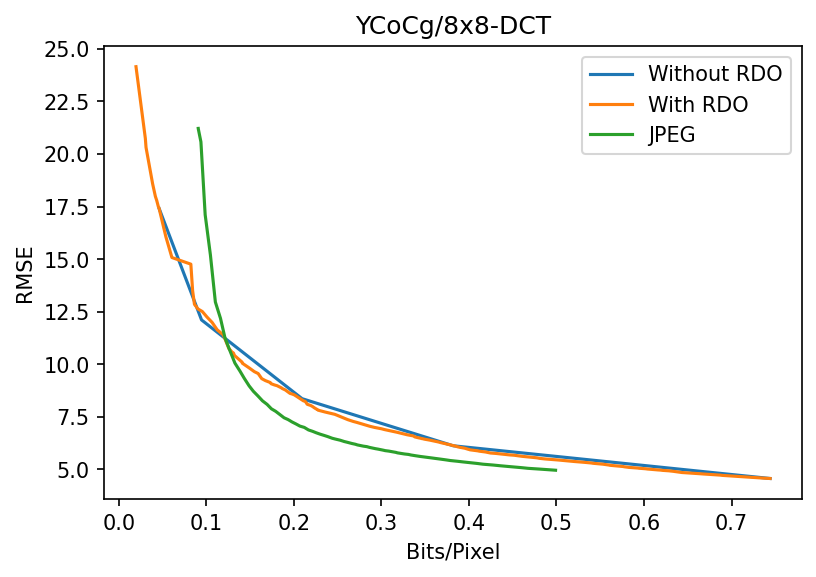

In [61]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_subbands), label="Without RDO")
pylab.plot(*zip(*optimal_RD_points), label="With RDO")
#pylab.plot(*zip(*optimal_RD_points_128), label="optimal quantization 128")
pylab.plot(*zip(*JPEG_RD_points), label="JPEG")
#pylab.plot(*zip(*DCT2), label="old")
pylab.title(f"{YUV.name}/{block_y_side}x{block_x_side}-DCT")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc="best")
#pylab.yscale('log')
#pylab.xscale('log')
pylab.show()

In [62]:
with open('DCT_RDO.txt', 'w') as f:
    for item in optimal_RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

## Conclusions

RDO over $\Delta$ provides optimality in those combinations where $\Delta$ is not the same for all subband-components. This is a consequence of progressively selecting those quantization steps for the subband-components that contribute more to the quality of the reconstruction between constant-$\Delta$ quantization patterns. Notice that between each different constant-$\Delta$ quantization pattern there are so many different-$\Delta$ quantization patterns as the number of subband-components. Notice also that the pattern of quantization steps must be known by the decoder to reconstruct the image.

## Use the RGB domain to compare the distortion (TODO)

## Optimizing the block-size

So far, we have used a constant block-size. However, this can be suboptimal (different images and areas of those images can be analyzed better, from a RD point of view, variying the block-size). The idea is to decompose the image into blocks building a quad-tree, in which a node (a quadrant) is splitted if its RD slope considering the quadrant as a single block (of for example 16x16 pixels) is smaller than its RD slope considering 4 blocks (of 8x8 pixels). We have supposed that the image is a square. On the contrary, the image should be procesed by squared tiles (TO-DO).

The optimal splitting pattern is chosen computing, for the given quantization step, the best score:
$$
\frac{1}{\text{RMSE}\times\text{BPP}}
$$

Notice that the quad-tree must be transmitted to the decoder, and a way of encode the tree is to send a sequence of symbols 0 and 1, symbol 0 representing that the quadrant is not divided, and symbol 1 that the quadrant is divided. For example:

    +-------+---+---+ +---+---+
    |       |   |   | | 1 | 2 |
    |       +---+---+ +---+---+
    |       |   |   | | 3 | 4 |
    +---+-+-+---+---+ +---+---+
    |   + + +       |
    +---+-+-+       |
    |   |   |       |
    +---+---+-------+
    01    1        0
      0000 01    00
             0000 <- removable if the minimum block size has been reached
             
Only luminance is considered.

In [97]:
# Returns True if the current block_size if optimal
def is_block_size_optimal(block, Q_step):
    # First compute the slope of the block
    DCT = block_DCT.analyze_block(block)
    Q_DCT = Q.quantize(DCT, Q_step)
    R = information.entropy(Q_DCT.flatten().astype(np.int16))
    D = distortion.RMSE(Q_DCT, DCT)
    block_slope = 1/(R*D)
    # Now compute the slope, but applying the block_DCT to each quadrant
    DCT = block_DCT.analyze_image(block, block.shape[0]//2, block.shape[1]//2)
    Q_DCT = Q.quantize(DCT, Q_step)
    R = information.entropy(Q_DCT.flatten().astype(np.int16))
    D = distortion.RMSE(Q_DCT, DCT)
    splitted_block_slope = 1/(R*D)
    #print(block_slope, splitted_block_slope)
    return block_slope > splitted_block_slope

In [104]:
max_block_side = 32
min_block_side = 4
Q_step = 64

luma = YUV_img[..., 0]

for log_block_side in range(6, 1, -1): # min_block_side = 2²=4, max_block_side = 2⁵=32
    block_side = 1 << log_block_side
    block_size_is_optimal = np.zeros(shape=(luma.shape[0]//block_side, luma.shape[1]//block_side), dtype=bool)
    #DCT_luma = block_DCT.analyze_image(luma, block_side, block_side)
    # For each block
    for y in range(luma.shape[0]//block_side):
        for x in range(luma.shape[1]//block_side):
            if not block_size_is_optimal[y, x]:
                block = luma[y*block_side:(y+1)*block_side, x*block_side:(x+1)*block_side]
                if is_block_size_optimal(block, Q_step):
                    block_size_is_optimal[y, x] = 1
                    print('.', end='') # No divide the block
                else:
                    block_is_optimal[y, x] = 0
                    print('O', end='') # Divide the block
    block_is_optimal_copy = block_is_optimal.copy()
    print('')

...OOO.O......O...OOOO.O.O.......O..OO......O...O.O.OOO.OO.O.OO.
...............OO.......O.....O.........O.....O....OO..O.OO.OOOO...O.......OOO.....O.....O.O.......OOOO.O.OOO.......O.............O..O........................O.......O.....O........O...O.....O..OO.O....OO..O.....OO.......O.............O.................O..
...........................................................O...........................................................................................O....O..O..................OO.......O.......................O........................O..........O..O..........................O.O....O..........O.................................................O....................O..........O..............................O......................................................O.........O...........................O...................O.O...........................O......O.........O...............O....O.......................O..................O...............O...O........O................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
Q_DCT_blocks = block_DCT.uniform_quantize(DCT_blocks, max_block_side, max_block_side, N_components, Q_step)
for y in range(luma.shape[0]//max_block_side):
    for x in range(luma.shape[1]//max_block_side):
        Q_DCT_block = Q_DCT_blocks[y*max_block_side:(y+1)*max_block_side, x*max_block_side:(x+1)*max_block_side]
        DCT_block = DCT_blocks[y*max_block_side:(y+1)*max_block_side, x*max_block_side:(x+1)*max_block_side]
        block_rate = distortion.entropy(Q_DCT_block.flatten().astype(np.int16))
        block_distortion = distortion.RMSE(Q_DCT_block, DCT_block)
        block_slope = 1/block_rate*block_distortion
        for yy in range(DCT_block.shape[0]):
            for xx in range(DCT_block.shape[1])

component=0 max=224 min=32 dtype=uint8
component=1 max=192 min=32 dtype=uint8
component=2 max=192 min=32 dtype=uint8
192 32 uint8


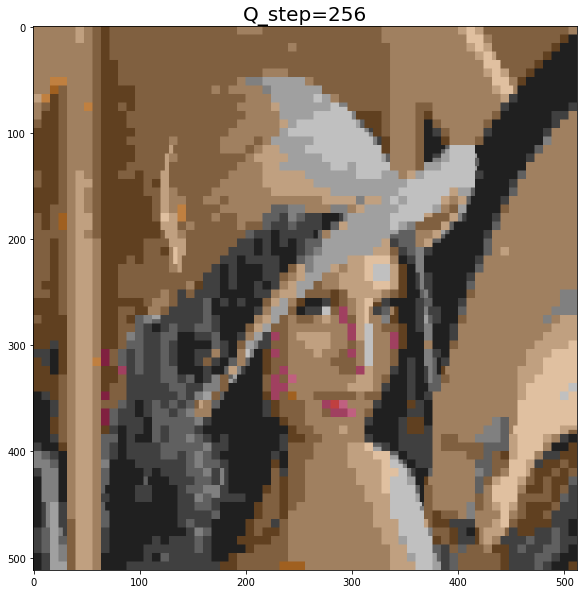

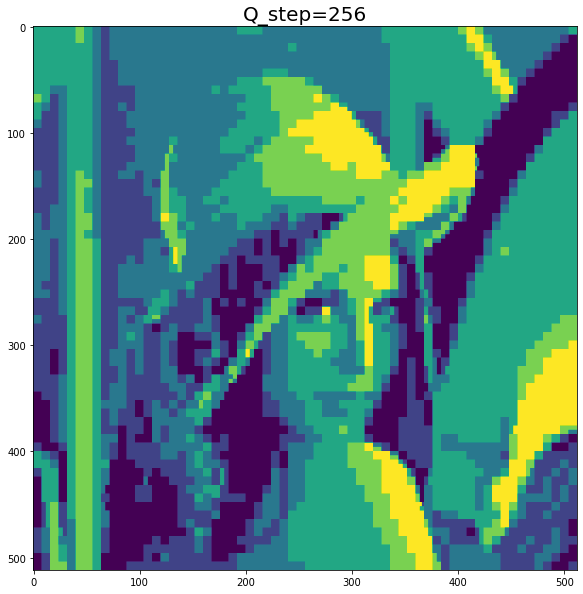

In [74]:
def local_entropy(image, x_range, y_range):
    pass

!ln -sf ~/MRVC/src/DWT.py .
import DWT
import pywt

img = image_3.read(test_image, 0)
YUV_img = YUV.from_RGB(img.astype(np.int16))

wavelet_name = "Haar"
wavelet = pywt.Wavelet(wavelet_name)
N_levels = 3
decom = DWT.analyze(YUV_img, wavelet, N_levels)

Q_step = 256

LL = decom[0]
LL_k = Q.quantize(LL, Q_step) # Baybe bettter Q.get_indexes()
LL_dQ = Q.dequantize(LL_k, Q_step) # Q.get_signal()
decom_dQ = [LL_dQ]
for sr in decom[1:]: # sr = spatial_resolution
    sr_dQ = []
    for sb in sr: # sb = subband
        sb_k = Q.quantize(sb, Q_step)
        sb_dQ = Q.dequantize(sb_k, Q_step)
        sr_dQ.append(sb_dQ)
    decom_dQ.append(tuple(sr_dQ))
YUV_img_dQ = DWT.synthesize(decom_dQ, wavelet, N_levels)
img_dQ = YUV.to_RGB(YUV_img_dQ)
img_dQ = np.clip(img_dQ, a_min=0, a_max=255).astype(np.uint8)
image_3.show(img_dQ.astype(np.uint8), f"Q_step={Q_step}")
image_1.show(YUV_img_dQ[...,0].astype(np.uint8), f"Q_step={Q_step}")

## Optimizing the block-shape